# Decision program using machine learning methods
## PostgreSQL, basic features + POS features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
!pip install torch==1.13.1
!pip install tqdm==4.66.4
!pip install dhg==0.9.4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
import dhg
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import pickle
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

#### Distribution of the runtimes in orders of magnitude

For the original queries:

In [3]:
df = pd.read_csv('results/SPA_Scala_comparison_TO_augment_server.csv')

df.loc[df['orig mean'] == 'TO', 'orig mean'] = 101
column = df['orig mean'].astype("float64")

count_0_01_orig = 0
count_0_1_orig = 0
count_1_orig = 0
count_10_orig = 0
count_100_orig = 0
count_TO_orig = 0

for value in column:
    if value <= 0.01:
        count_0_01_orig += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_orig += 1
    elif value > 0.1 and value <= 1:
        count_1_orig += 1
    elif value > 1 and value <= 10:
        count_10_orig += 1
    elif value > 10 and value <= 100:
        count_100_orig += 1
    else:
        count_TO_orig += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_orig)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_orig)
print("Number of instances with original runtime (0.1, 1]:", count_1_orig)
print("Number of instances with original runtime (1,10]:", count_10_orig)
print("Number of instances with original runtime (10,100]:", count_100_orig)
print("Number of instances with original runtime TO:", count_TO_orig)

Number of instances with original runtime <= 0.01: 0
Number of instances with original runtime (0.01, 0.1]: 35
Number of instances with original runtime (0.1, 1]: 1638
Number of instances with original runtime (1,10]: 598
Number of instances with original runtime (10,100]: 241
Number of instances with original runtime TO: 424


for the rewritten queries:

In [4]:
df.loc[df['rewr mean'] == 'TO', 'rewr mean'] = 101
column = df['rewr mean'].astype("float64")

count_0_01_rewr = 0
count_0_1_rewr = 0
count_1_rewr = 0
count_10_rewr = 0
count_100_rewr = 0
count_TO_rewr = 0

for value in column:
    if value <= 0.01:
        count_0_01_rewr += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_rewr += 1
    elif value > 0.1 and value <= 1:
        count_1_rewr += 1
    elif value > 1 and value <= 10:
        count_10_rewr += 1
    elif value > 10 and value <= 100:
        count_100_rewr += 1
    else:
        count_TO_rewr += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_rewr)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_rewr)
print("Number of instances with original runtime (0.1, 1]:", count_1_rewr)
print("Number of instances with original runtime (1,10]:", count_10_rewr)
print("Number of instances with original runtime (10,100]:", count_100_rewr)
print("Number of instances with original runtime TO:", count_TO_rewr)

Number of instances with original runtime <= 0.01: 0
Number of instances with original runtime (0.01, 0.1]: 12
Number of instances with original runtime (0.1, 1]: 2179
Number of instances with original runtime (1,10]: 461
Number of instances with original runtime (10,100]: 282
Number of instances with original runtime TO: 2


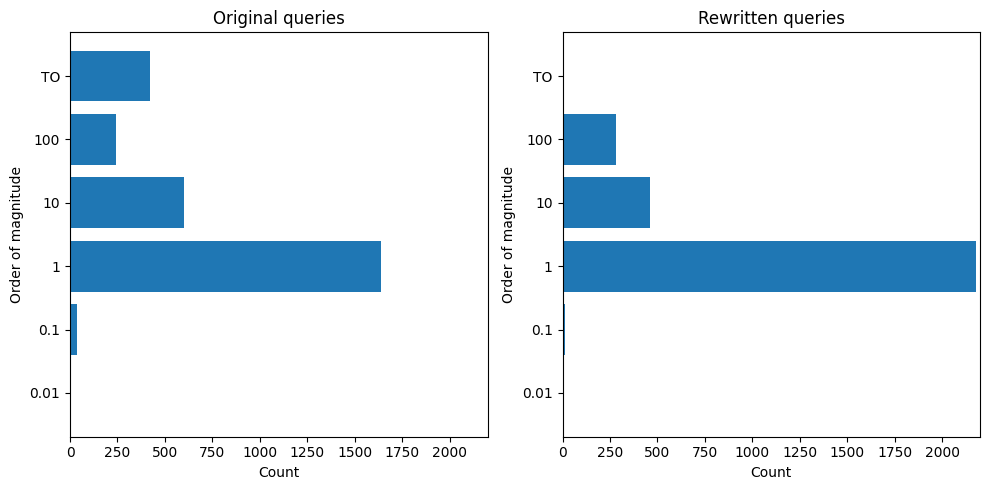

In [5]:
numbers_orig = [count_0_01_orig, count_0_1_orig, count_1_orig, count_10_orig, count_100_orig, count_TO_orig]
numbers_rewr = [count_0_01_rewr, count_0_1_rewr, count_1_rewr, count_10_rewr, count_100_rewr, count_TO_rewr]

# Indices for each number
indices = ["0.01", "0.1", "1", "10", "100", "TO"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original numbers
axs[0].barh(indices, numbers_orig)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Order of magnitude')
axs[0].set_title('Original queries')
axs[0].set_xlim(0, 2200)

# Plot rewritten numbers
axs[1].barh(indices, numbers_rewr)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Order of magnitude')
axs[1].set_title('Rewritten queries')
axs[1].set_xlim(0, 2200)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Import the data

In [6]:
file_path = 'results/features_times_SPA.csv'
df = pd.read_csv(file_path)
df.head()

bench                query orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  \
0  STATS              001-014            orig                 orig   0.215220   
1  STATS        001-014-augA1            orig                 orig   0.343959   
2  STATS        001-014-augA2            orig                 orig   0.241465   
3  STATS        001-014-augF1            orig                 orig   0.223958   
4  STATS  001-014-augF1-augA1            orig                 orig   0.258606   

   rewr mean  rewr mean+rewr  diff rewr-orig  diff rewr+rewr-orig  #relations  \
0   0.332952        2.258359        0.117732             2.043140           3   
1   0.465946        2.262779        0.121988             1.918820           3   
2   0.358131        2.176462        0.116667             1.934997           3   
3   0.286062        2.118357        0.062104             1.894398           3   
4   0.327809        2.182811        0.069203             1.924205           3   

   ...  max(branching factors)  mean(branching factors)  \
0  ...                       2                      2.0   
1  ...                       1                      1.0   
2  ...                       1                      1.0   
3  ...                       2                      2.0   
4  ...                       1                      1.0   

   median(branching factors)  q25(branching factors)  q75(branching factors)  \
0                        2.0                     2.0                     2.0   
1                        1.0                     1.0                     1.0   
2                        1.0                     1.0                     1.0   
3                        2.0                     2.0                     2.0   
4                        1.0                     1.0                     1.0   

   balancedness factor                          container counts list  \
0                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
1                  NaN  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
2                  NaN  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
3                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
4                  NaN  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   

   branching factors list                                         hypergraph  \
0                     [2]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
1                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
2                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
3                     [2]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
4                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   

                                                text  
0  SELECT MIN(u.Id) FROM comments as c, votes as ...  
1  SELECT MIN(c.id) FROM comments as c, votes as ...  
2  SELECT MIN(v.id) FROM comments as c, votes as ...  
3  SELECT MIN(u.Id) FROM comments as c, votes as ...  
4  SELECT MIN(c.id) FROM comments as c, votes as ...  

[5 rows x 31 columns]

In [7]:
df.dtypes

bench                         object
query                         object
orig/rewr(mean)               object
orig/rewr+rewr(mean)          object
orig mean                    float64
rewr mean                    float64
rewr mean+rewr               float64
diff rewr-orig               float64
diff rewr+rewr-orig          float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
min(branching factors)         int64
max(branching factors)         int64
mean(branching factors)      float64
median(branching factors)    float64
q25(branching factors)       float64
q75(branching factors)       float64
balancedness factor          float64
c

Transform the hypergraph, which is saved as pickle object, back to a dhg hypergraph object.

In [8]:
df["hypergraph"] = df["hypergraph"].apply(lambda x: pickle.loads(eval(x)))

Also load the POS features

In [9]:
file_path_pos = 'results/features_times_POS_extra.csv'
df_pos = pd.read_csv(file_path_pos)
df_pos.head()

bench                query orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  \
0  STATS              001-014            orig                 orig   0.030513   
1  STATS        001-014-augA1            orig                 orig   0.030952   
2  STATS        001-014-augA2            orig                 orig   0.030812   
3  STATS        001-014-augF1            orig                 orig   0.029663   
4  STATS  001-014-augF1-augA1            orig                 orig   0.030595   

   rewr mean  rewr mean+rewr  diff rewr-orig  diff rewr+rewr-orig  #relations  \
0   0.063829        1.989236        0.033316             1.958724           3   
1   0.043271        1.840104        0.012320             1.809152           3   
2   0.168679        1.987010        0.137867             1.956198           3   
3   0.156431        1.988726        0.126768             1.959062           3   
4   0.043383        1.898386        0.012788             1.867790           3   

   ...  median(branching factors)  q25(branching factors)  \
0  ...                        2.0                     2.0   
1  ...                        1.0                     1.0   
2  ...                        1.0                     1.0   
3  ...                        2.0                     2.0   
4  ...                        1.0                     1.0   

   q75(branching factors)  balancedness factor  list table rows  \
0                     2.0                  1.0  [99392, 985, 1]   
1                     1.0                  NaN  [99392, 985, 1]   
2                     1.0                  NaN  [99392, 985, 1]   
3                     2.0                  1.0  [99392, 798, 1]   
4                     1.0                  NaN  [99392, 798, 1]   

   list join rows                          container counts list  \
0     [27256, 84]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
1     [27256, 84]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
2     [27256, 84]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
3     [22078, 68]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
4     [22078, 68]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   

   branching factors list                                         hypergraph  \
0                     [2]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
1                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
2                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
3                     [2]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
4                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   

                                                text  
0  SELECT MIN(u.Id) FROM comments as c, votes as ...  
1  SELECT MIN(c.id) FROM comments as c, votes as ...  
2  SELECT MIN(v.id) FROM comments as c, votes as ...  
3  SELECT MIN(u.Id) FROM comments as c, votes as ...  
4  SELECT MIN(c.id) FROM comments as c, votes as ...  

[5 rows x 46 columns]

In [10]:
df_pos.dtypes

bench                         object
query                         object
orig/rewr(mean)               object
orig/rewr+rewr(mean)          object
orig mean                    float64
rewr mean                    float64
rewr mean+rewr               float64
diff rewr-orig               float64
diff rewr+rewr-orig          float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
total cost                   float64
min(table rows)                int64
max(table rows)                int64
mean(table rows)             float64
q25(table rows)              float64
median(table rows)           float64
q75(table rows)              float64
min(join rows)                 int64
max(join rows)                object
mean(join rows)              float64
q25(join rows)               float64
median(join rows)            float64
q75(join rows)               float64
depth                          int64
m

In [11]:
df_pos['max(join rows)'] = df_pos['max(join rows)'].astype("float64")

In [12]:
pos_features = df_pos[['bench', 'query', 'total cost', 'min(table rows)', 'max(table rows)', 'mean(table rows)', 'q25(table rows)', 
                       'median(table rows)', 'q75(table rows)', 'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)', 
                       'median(join rows)', 'q75(join rows)']]

In [13]:
df.shape

(2936, 31)

In [14]:
df = pd.merge(df, pos_features, on=["bench", "query"], how='inner')

In [15]:
df.shape

(2936, 44)

In [16]:
df.columns

Index(['bench', 'query', 'orig/rewr(mean)', 'orig/rewr+rewr(mean)',
       'orig mean', 'rewr mean', 'rewr mean+rewr', 'diff rewr-orig',
       'diff rewr+rewr-orig', '#relations', '#conditions', '#filters',
       '#joins', 'depth', 'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)',
       'balancedness factor', 'container counts list',
       'branching factors list', 'hypergraph', 'text', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

#### Delete those examples, where both methods gave a timeout

In [17]:
df[df["orig/rewr(mean)"] == "-"]

bench              query orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  \
2092  SNAP        wiki-path08               -                    -      100.0   
2093  SNAP  wiki-path08-augA1               -                    -      100.0   

      rewr mean  rewr mean+rewr  diff rewr-orig  diff rewr+rewr-orig  \
2092      100.0           100.0             0.0                  0.0   
2093      100.0           100.0             0.0                  0.0   

      #relations  ...  mean(table rows)  q25(table rows)  median(table rows)  \
2092           9  ...      2.666326e+07       28511210.0          28511210.0   
2093           9  ...      2.666326e+07       28511210.0          28511210.0   

      q75(table rows)  min(join rows)  max(join rows)  mean(join rows)  \
2092       28511210.0      2040287492    8.992907e+24     1.124113e+24   
2093       28511210.0      2040287492    8.992907e+24     1.124113e+24   

      q25(join rows)  median(join rows)  q75(join rows)  
2092    4.896690e+09       1.776541e+11    2.692326e+15  
2093    4.896690e+09       1.776541e+11    2.692326e+15  

[2 rows x 44 columns]

For the SNAP dataset the wiki-path06, wiki-path07, wiki-path08 and wiki-tree03 (for all augmentation cases) did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those 32 samples.

In [18]:
df = df[df["orig/rewr(mean)"] != "-"]
df.shape

(2934, 44)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [19]:
X = pd.concat([df.iloc[:, 9:26], df.iloc[:, 31:44]], axis = 1)
X.head()

#relations  #conditions  #filters  #joins  depth  min(container counts)  \
0           3            7         5       2      1                      1   
1           3            7         5       2      2                      1   
2           3            7         5       2      2                      1   
3           3            7         5       2      1                      1   
4           3            7         5       2      2                      1   

   max(container counts)  mean(container counts)  q25(container counts)  \
0                      3                1.133333                    1.0   
1                      3                1.133333                    1.0   
2                      3                1.133333                    1.0   
3                      3                1.133333                    1.0   
4                      3                1.133333                    1.0   

   median(container counts)  ...  mean(table rows)  q25(table rows)  \
0                       1.0  ...      33459.333333            493.0   
1                       1.0  ...      33459.333333            493.0   
2                       1.0  ...      33459.333333            493.0   
3                       1.0  ...      33397.000000            399.5   
4                       1.0  ...      33397.000000            399.5   

   median(table rows)  q75(table rows)  min(join rows)  max(join rows)  \
0               985.0          50188.5              84         27256.0   
1               985.0          50188.5              84         27256.0   
2               985.0          50188.5              84         27256.0   
3               798.0          50095.0              68         22078.0   
4               798.0          50095.0              68         22078.0   

   mean(join rows)  q25(join rows)  median(join rows)  q75(join rows)  
0          13670.0          6877.0            13670.0         20463.0  
1          13670.0          6877.0            13670.0         20463.0  
2          13670.0          6877.0            13670.0         20463.0  
3          11073.0          5570.5            11073.0         16575.5  
4          11073.0          5570.5            11073.0         16575.5  

[5 rows x 30 columns]

In [20]:
X.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

Get the feature matrix, which additionally includes the hypergraph information/representation.

In [21]:
X_hg = pd.concat([X, df.iloc[:,29]], axis = 1)
X_hg.head()

#relations  #conditions  #filters  #joins  depth  min(container counts)  \
0           3            7         5       2      1                      1   
1           3            7         5       2      2                      1   
2           3            7         5       2      2                      1   
3           3            7         5       2      1                      1   
4           3            7         5       2      2                      1   

   max(container counts)  mean(container counts)  q25(container counts)  \
0                      3                1.133333                    1.0   
1                      3                1.133333                    1.0   
2                      3                1.133333                    1.0   
3                      3                1.133333                    1.0   
4                      3                1.133333                    1.0   

   median(container counts)  ...  q25(table rows)  median(table rows)  \
0                       1.0  ...            493.0               985.0   
1                       1.0  ...            493.0               985.0   
2                       1.0  ...            493.0               985.0   
3                       1.0  ...            399.5               798.0   
4                       1.0  ...            399.5               798.0   

   q75(table rows)  min(join rows)  max(join rows)  mean(join rows)  \
0          50188.5              84         27256.0          13670.0   
1          50188.5              84         27256.0          13670.0   
2          50188.5              84         27256.0          13670.0   
3          50095.0              68         22078.0          11073.0   
4          50095.0              68         22078.0          11073.0   

   q25(join rows)  median(join rows)  q75(join rows)  \
0          6877.0            13670.0         20463.0   
1          6877.0            13670.0         20463.0   
2          6877.0            13670.0         20463.0   
3          5570.5            11073.0         16575.5   
4          5570.5            11073.0         16575.5   

                      hypergraph  
0  Hypergraph(num_v=17, num_e=3)  
1  Hypergraph(num_v=17, num_e=3)  
2  Hypergraph(num_v=17, num_e=3)  
3  Hypergraph(num_v=17, num_e=3)  
4  Hypergraph(num_v=17, num_e=3)  

[5 rows x 31 columns]

#### Log-transformations

In [22]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min           Max          Diff
#relations                   2.000000  1.100000e+01  9.000000e+00
#conditions                  2.000000  2.000000e+01  1.800000e+01
#filters                     0.000000  1.600000e+01  1.600000e+01
#joins                       1.000000  1.200000e+01  1.100000e+01
depth                        1.000000  7.000000e+00  6.000000e+00
min(container counts)        1.000000  1.000000e+00  0.000000e+00
max(container counts)        2.000000  5.000000e+00  3.000000e+00
mean(container counts)       1.047619  1.600000e+00  5.523810e-01
q25(container counts)        1.000000  1.000000e+00  0.000000e+00
median(container counts)     1.000000  1.000000e+00  0.000000e+00
q75(container counts)        1.000000  1.000000e+00  0.000000e+00
min(branching factors)       1.000000  6.000000e+00  5.000000e+00
max(branching factors)       1.000000  6.000000e+00  5.000000e+00
mean(branching factors)      1.000000  6.000000e+00  5.000000e+00
median(branching factors)    1.000000  6.000000e+00  5.000000e+00
q25(branching factors)       1.000000  6.000000e+00  5.000000e+00
q75(branching factors)       1.000000  6.000000e+00  5.000000e+00
total cost                 209.970000  1.573759e+23  1.573759e+23
min(table rows)              1.000000  1.187967e+07  1.187967e+07
max(table rows)             19.000000  2.851121e+07  2.851119e+07
mean(table rows)             4.600000  2.666326e+07  2.666326e+07
q25(table rows)              1.000000  2.851121e+07  2.851121e+07
median(table rows)           1.000000  2.851121e+07  2.851121e+07
q75(table rows)              1.000000  2.851121e+07  2.851121e+07
min(join rows)               1.000000  2.000964e+10  2.000964e+10
max(join rows)               2.000000  8.992907e+24  8.992907e+24
mean(join rows)              1.200000  1.124113e+24  1.124113e+24
q25(join rows)               1.000000  8.913309e+10  8.913309e+10
median(join rows)            1.000000  4.229421e+11  4.229421e+11
q75(join rows)               1.000000  2.558033e+18  2.558033e+18

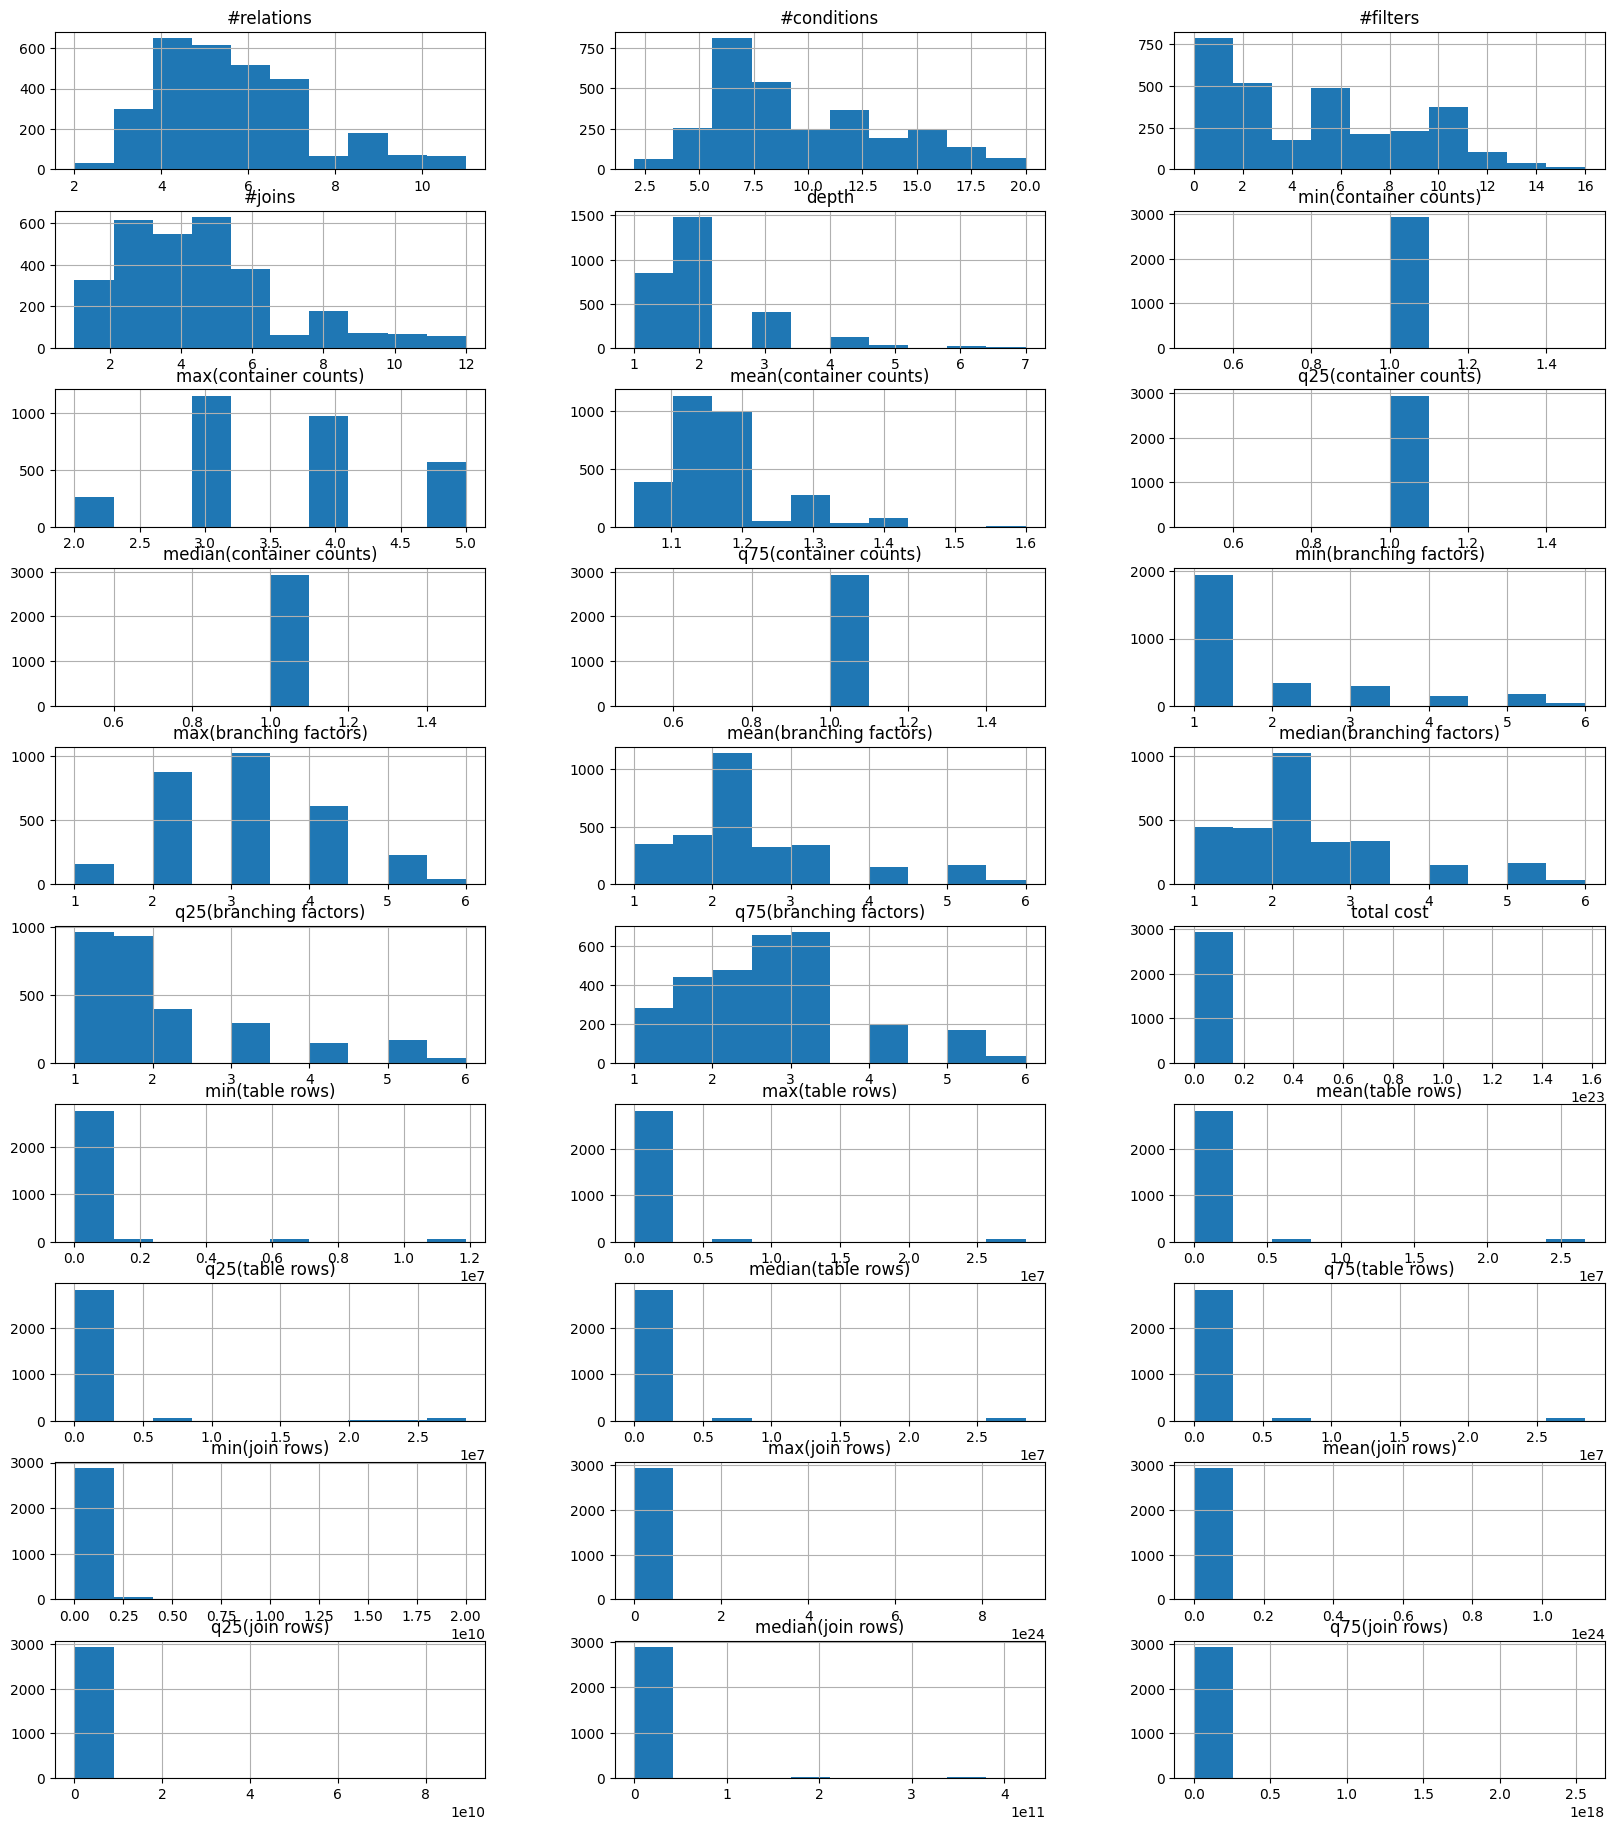

In [23]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

We transform all table rows and join rows variables and the total cost.

In [24]:
columns_to_log = ['total cost', 'min(table rows)', 'max(table rows)',
       'mean(table rows)', 'q25(table rows)', 'median(table rows)',
       'q75(table rows)', 'min(join rows)', 'max(join rows)',
       'mean(join rows)', 'q25(join rows)', 'median(join rows)',
       'q75(join rows)']
X[columns_to_log] = X[columns_to_log].apply(np.log)

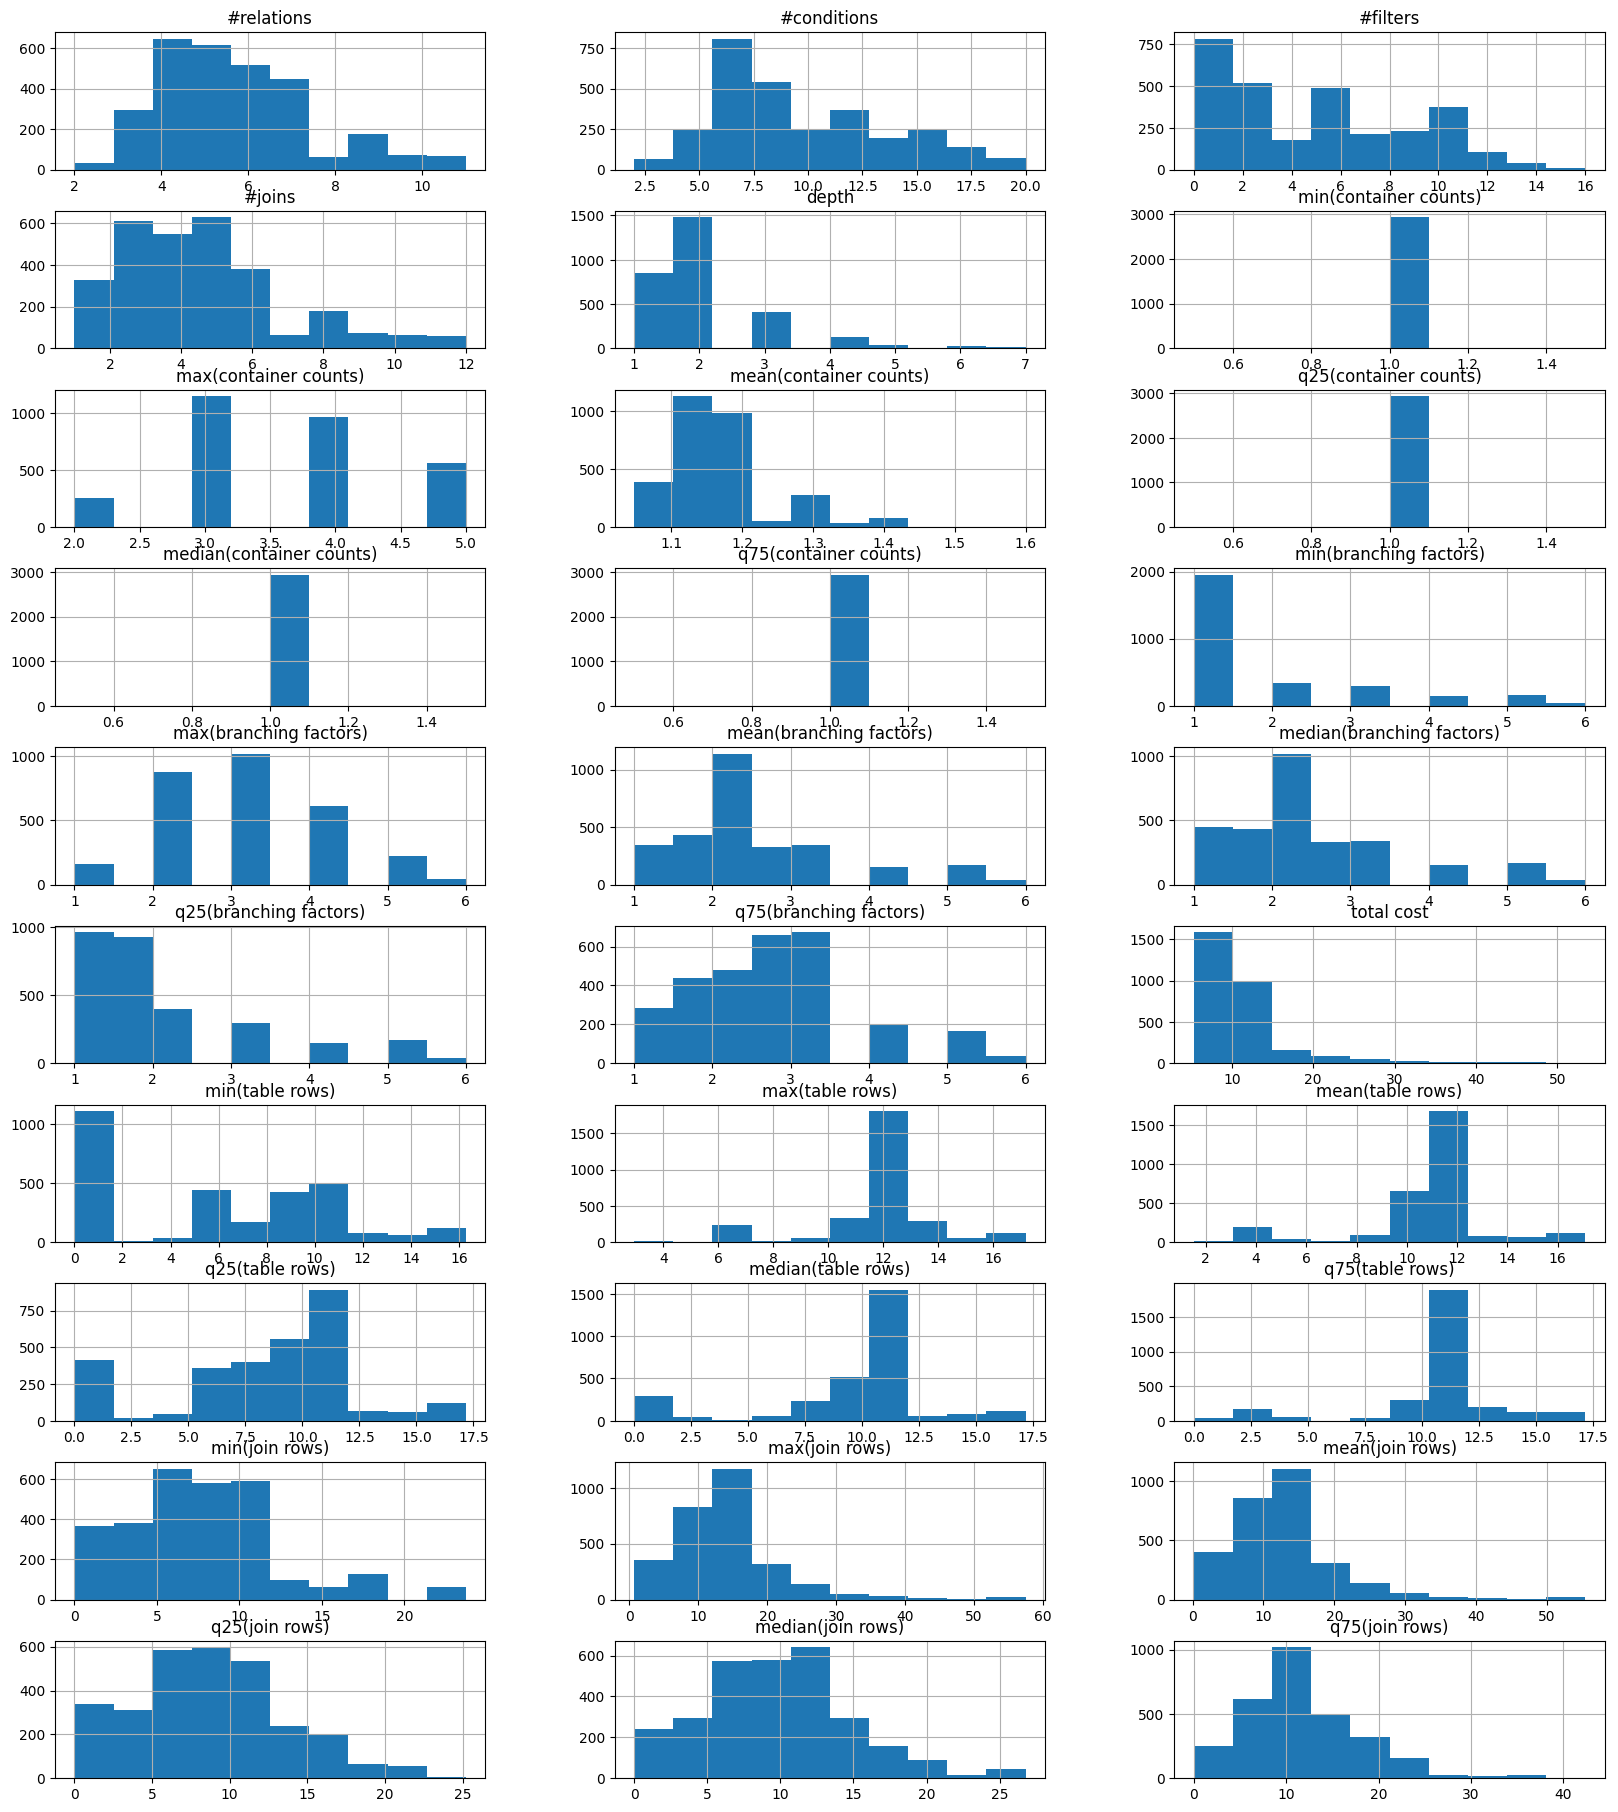

In [25]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Boxplots of running times for both cases (either original or rewritten)

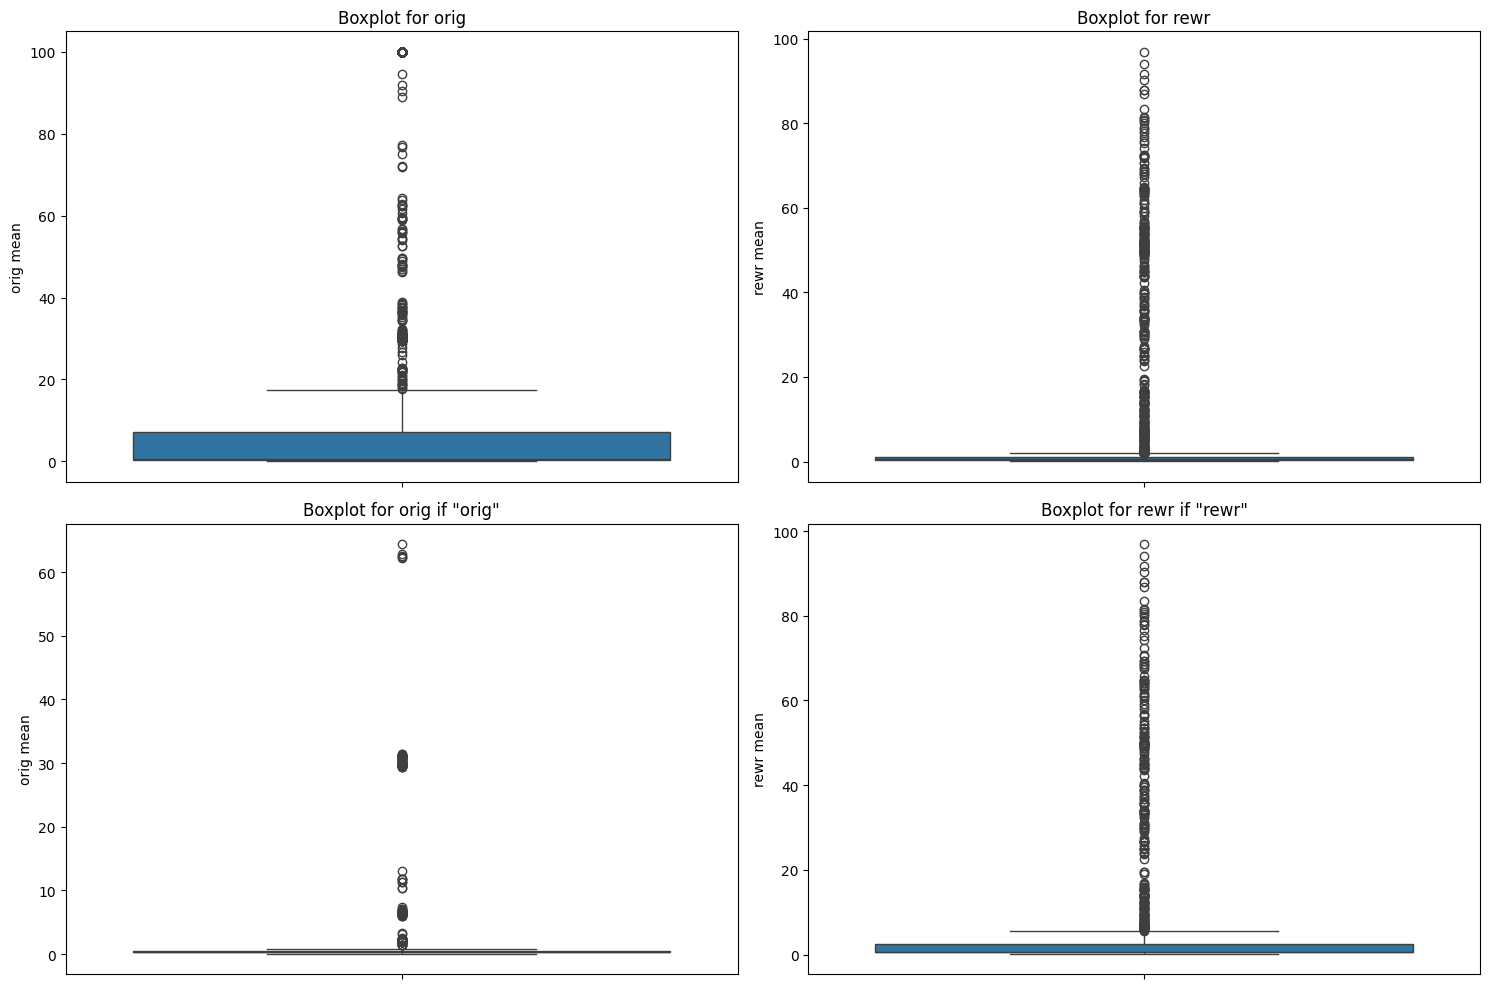

In [26]:
df_orig = df[df['orig/rewr(mean)'] == 'orig']
df_rewr = df[df['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')

sns.boxplot(y='rewr mean', data=df, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr')

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr if "rewr"')

plt.tight_layout()
plt.show()

The runtimes are highly skewed. Therefore, we log transform them

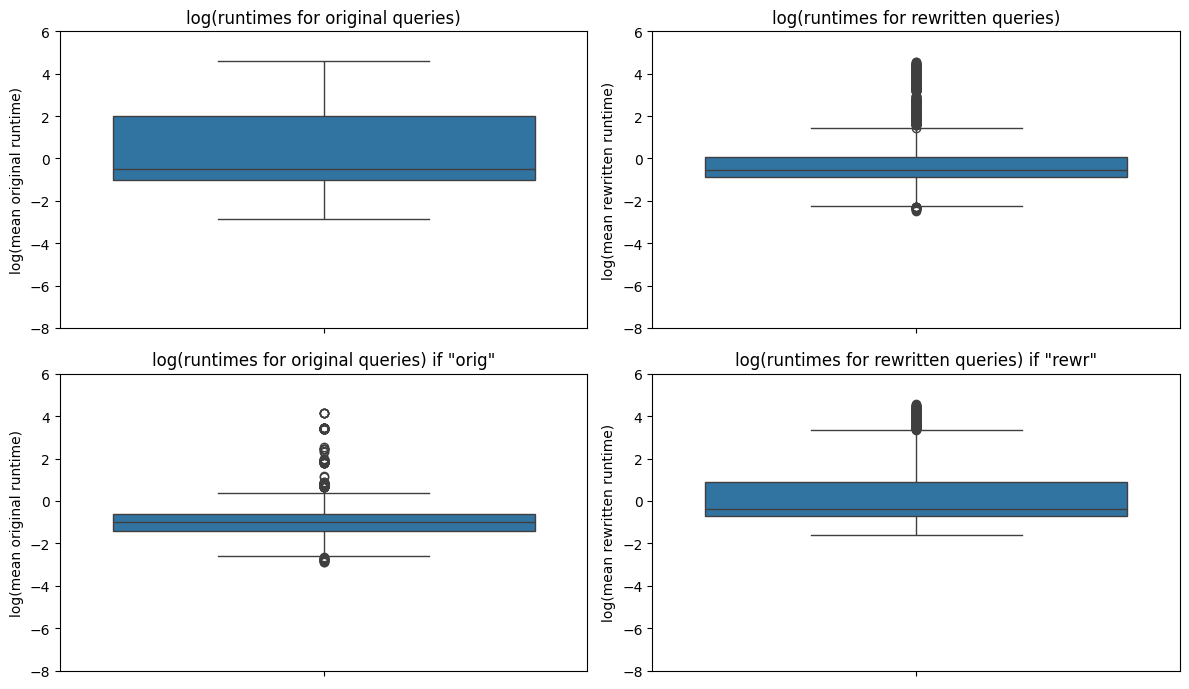

In [27]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(12,7))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0,0])
axes[0,0].set_title(f'log(runtimes for original queries)')
axes[0,0].set_ylabel("log(mean original runtime)")
axes[0,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[0,1])
axes[0,1].set_title(f'log(runtimes for rewritten queries)')
axes[0,1].set_ylabel("log(mean rewritten runtime)")
axes[0,1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'log(runtimes for original queries) if "orig"')
axes[1,0].set_ylabel("log(mean original runtime)")
axes[1,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[1,1].set_ylabel("log(mean rewritten runtime)")
axes[1,1].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

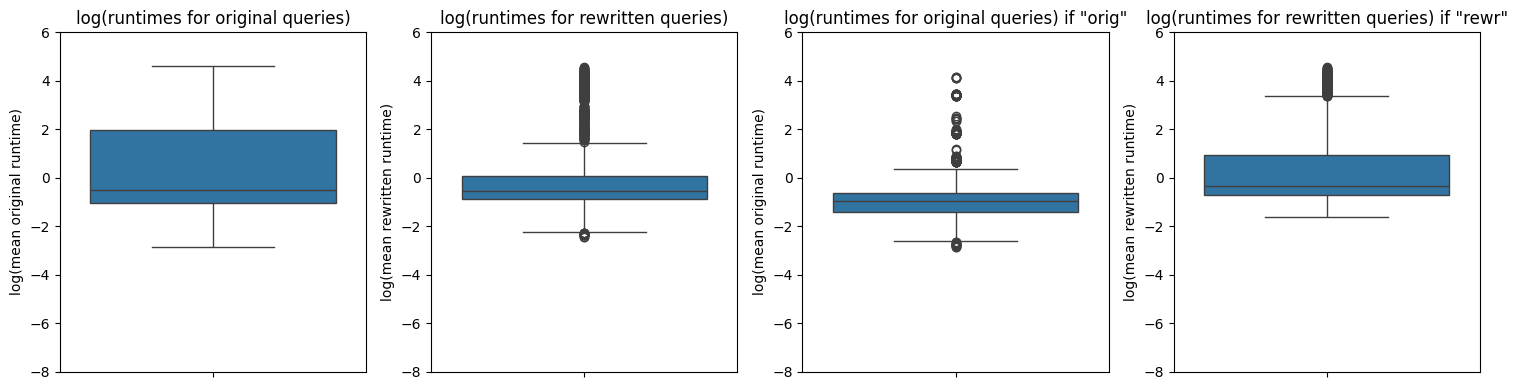

In [28]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(1,4, figsize=(15,4))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0])
axes[0].set_title(f'log(runtimes for original queries)')
axes[0].set_ylabel("log(mean original runtime)")
axes[0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[1])
axes[1].set_title(f'log(runtimes for rewritten queries)')
axes[1].set_ylabel("log(mean rewritten runtime)")
axes[1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[2])
axes[2].set_title(f'log(runtimes for original queries) if "orig"')
axes[2].set_ylabel("log(mean original runtime)")
axes[2].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[3])
axes[3].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[3].set_ylabel("log(mean rewritten runtime)")
axes[3].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

#### Scatterplot of running times

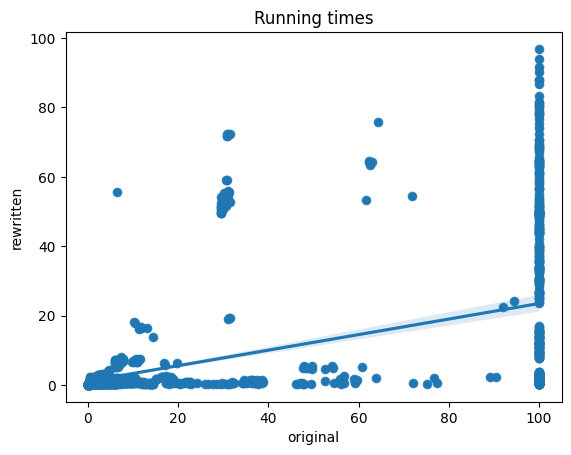

In [29]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df)
sns.regplot(x="orig mean", y="rewr mean", data=df) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

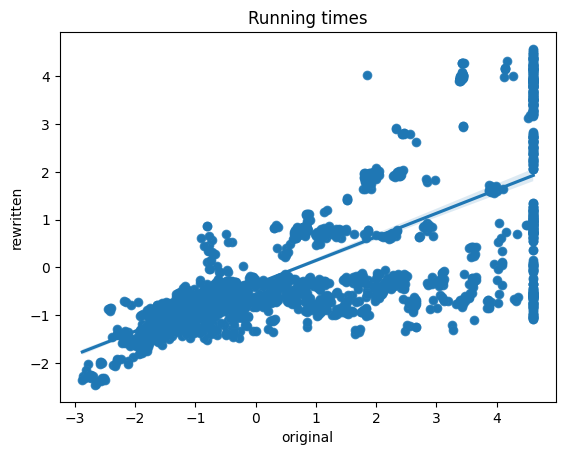

In [30]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df_log)
sns.regplot(x="orig mean", y="rewr mean", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [31]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(mean)'].map(mapping)
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr(mean), dtype: int64

The number of appearances of original and rewritten is very balanced.

In [32]:
y1.value_counts()

orig/rewr(mean)
1    1482
0    1452
Name: count, dtype: int64

In [33]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["orig", "rewr", "equal"]
count

orig     1452
rewr     1482
equal       -
dtype: object

In [34]:
df["orig/rewr(mean)"].value_counts()

orig/rewr(mean)
rewr    1482
orig    1452
Name: count, dtype: int64

#### Classification response with three cases

In [35]:
condition = abs(df["diff rewr-orig"]) < 0.5
df["orig/rewr/equal 0.5"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.5'] = 'equal'

In [36]:
condition = abs(df["diff rewr-orig"]) < 0.1
df["orig/rewr/equal 0.1"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.1'] = 'equal'

In [37]:
condition = abs(df["diff rewr-orig"]) < 0.05
df["orig/rewr/equal 0.05"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.05'] = 'equal'

In [38]:
condition = abs(df["diff rewr-orig"]) < 0.01
df["orig/rewr/equal 0.01"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.01'] = 'equal'

In [39]:
count_05 = df["orig/rewr/equal 0.5"].value_counts()
count_01 = df["orig/rewr/equal 0.1"].value_counts()
count_005 = df["orig/rewr/equal 0.05"].value_counts()
count_001 = df["orig/rewr/equal 0.01"].value_counts()

In [40]:
count_001

orig/rewr/equal 0.01
rewr     1444
orig     1412
equal      78
Name: count, dtype: int64

In [41]:
counts = pd.concat([count_001, count_005, count_01, count_05], axis = 1)
counts.iloc[[0, 1]] = counts.iloc[[1, 0]].values
counts.index = ["orig", "rewr", "equal"]
counts = pd.concat([count, counts], axis = 1)
counts.columns = ["2 classes", "3 classes (0.01)", "3 classes (0.05)", "3 classes (0.1)", "3 classes (0.5)"]
counts

2 classes  3 classes (0.01)  3 classes (0.05)  3 classes (0.1)  \
orig       1452              1412              1146              726   
rewr       1482              1444              1351             1260   
equal         -                78               437              948   

       3 classes (0.5)  
orig               104  
rewr              1028  
equal             1802

In [42]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_05 = df['orig/rewr/equal 0.5'].map(mapping1)
y1_equal_05.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr/equal 0.5, dtype: int64

In [43]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_01 = df['orig/rewr/equal 0.1'].map(mapping1)
y1_equal_01.head()

0   -1
1   -1
2   -1
3    0
4    0
Name: orig/rewr/equal 0.1, dtype: int64

In [44]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_005 = df['orig/rewr/equal 0.05'].map(mapping1)
y1_equal_005.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: orig/rewr/equal 0.05, dtype: int64

In [45]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_001 = df['orig/rewr/equal 0.01'].map(mapping1)
y1_equal_001.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: orig/rewr/equal 0.01, dtype: int64

#### Regression response

We also have the time differences between the original and rewritten method and we want to use that as numerical response.

In [46]:
y1_diff = df["diff rewr-orig"]
#y1_diff = df["diff rewr+rewr-orig"]

We can see that the time difference has a wide range of values (or is skewed).

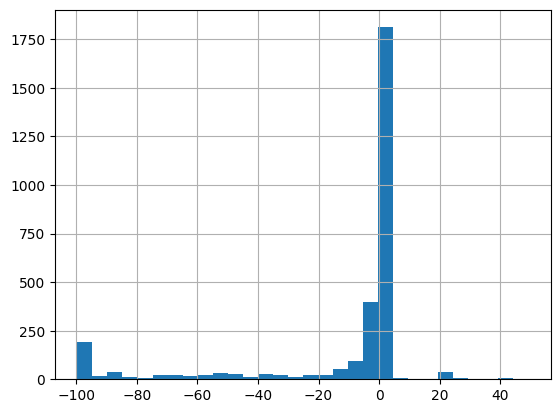

In [47]:
y1_diff.hist(bins = 30)
plt.show()

Therefore, we are going to transform it. As before with the features, we would like to apply a log transformation. Neverthless, since we have negative values this cannot be applied directly. We are going to multiple to log of the absolute values with the sign they had before. Additionally, since we have a lot of values close to zero, which leads to very low log values, we add 1 to the absolute values, which is a common method.   
$x = sgn(x) * log(|x| + 1)$

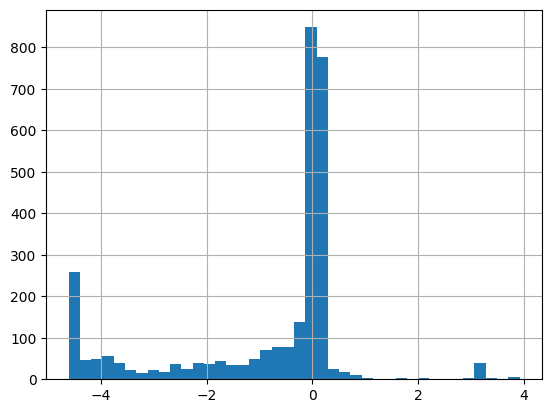

In [48]:
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) +1)
y1_diff_log.hist(bins = 40)
plt.show()

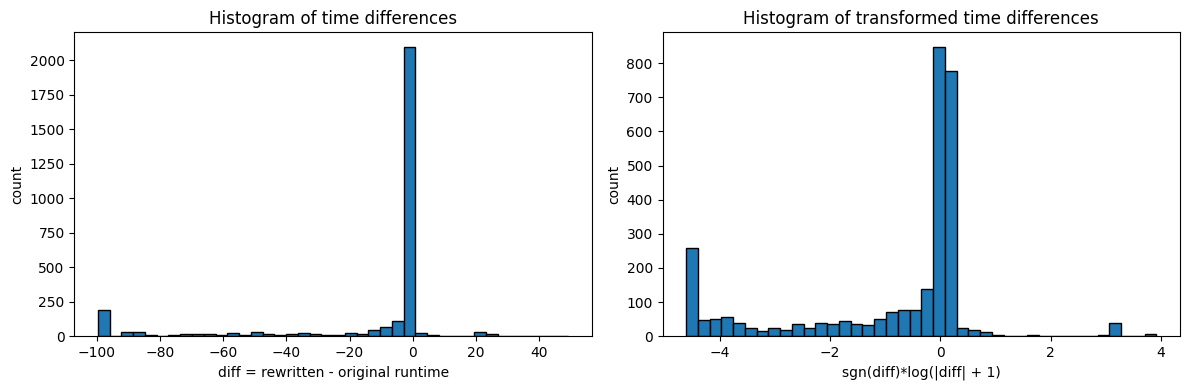

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(y1_diff, bins=40, edgecolor='black')
axs[0].set_title('Histogram of time differences')
axs[0].set_ylabel("count")
axs[0].set_xlabel("diff = rewritten - original runtime")

# Create the second histogram
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) + 1)
axs[1].hist(y1_diff_log, bins=40, edgecolor='black')
axs[1].set_title('Histogram of transformed time differences')
axs[1].set_ylabel("count")
axs[1].set_xlabel("sgn(diff)*log(|diff| + 1)")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [50]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)
X_train_hg = X_hg.loc[X_train.index]
X_val_hg = X_hg.loc[X_val.index]
X_test_hg = X_hg.loc[X_test.index]
y1_diff_log_train = y1_diff_log.loc[y1_train.index]
y1_diff_log_val = y1_diff_log.loc[y1_val.index]
y1_diff_log_test = y1_diff_log.loc[y1_test.index]
y1_equal_05_train = y1_equal_05.loc[y1_train.index]
y1_equal_05_val = y1_equal_05.loc[y1_val.index]
y1_equal_05_test = y1_equal_05.loc[y1_test.index]
y1_equal_01_train = y1_equal_01.loc[y1_train.index]
y1_equal_01_val = y1_equal_01.loc[y1_val.index]
y1_equal_01_test = y1_equal_01.loc[y1_test.index]
y1_equal_005_train = y1_equal_005.loc[y1_train.index]
y1_equal_005_val = y1_equal_005.loc[y1_val.index]
y1_equal_005_test = y1_equal_005.loc[y1_test.index]
y1_equal_001_train = y1_equal_001.loc[y1_train.index]
y1_equal_001_val = y1_equal_001.loc[y1_val.index]
y1_equal_001_test = y1_equal_001.loc[y1_test.index]

#### Cross-validation split

We take the same 10% as test set and use the rest for cross-validation.

In [51]:
X_train_cv = pd.concat([X_train, X_val], axis = 0)
y1_train_cv = pd.concat([y1_train, y1_val], axis = 0)
y1_diff_log_train_cv = pd.concat([y1_diff_log_train, y1_diff_log_val], axis = 0)
y1_equal_05_train_cv = pd.concat([y1_equal_05_train, y1_equal_05_val], axis = 0)
y1_equal_01_train_cv = pd.concat([y1_equal_01_train, y1_equal_01_val], axis = 0)
y1_equal_005_train_cv = pd.concat([y1_equal_005_train, y1_equal_005_val], axis = 0)
y1_equal_001_train_cv = pd.concat([y1_equal_001_train, y1_equal_001_val], axis = 0)

In [56]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree_reg = model.predict(X_val)
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree_reg)
print(mse)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree_reg)
print(mae)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree_reg)
print(r2)

0.022211472630904092
0.08196182212493615
0.9930514782515745


In [57]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.8464163822525598
0.7027027027027027


array([[144,   1],
       [ 44, 104]])

In [58]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.8464163822525598
0.7027027027027027


array([[144,   1],
       [ 44, 104]])

In [59]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.8805460750853242
0.7905405405405406


array([[141,   4],
       [ 31, 117]])

## ML models

In [52]:
table_2_classes = pd.DataFrame(columns=['acc', 'rec', 'acc', 'rec'])
table_3_classes = pd.DataFrame(columns=['acc', 'rec-mic', 'rec_mac', 'acc', 'rec-mic', 'rec-mac'])
table_time_diff = pd.DataFrame(columns=['MSE', 'MAE', 'R2', 'MSE', 'MAE', 'R2'])

### k-Nearest Neighbors with two classes

Train-test split:

In [53]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_train)
y1_pred_knn = clf.predict(X_val)

In [54]:
accuracy = accuracy_score(y1_val, y1_pred_knn)
recall = recall_score(y1_val, y1_pred_knn)
conf_matrix = confusion_matrix(y1_val, y1_pred_knn)
conf_matrix

array([[130,  15],
       [ 25, 123]])

CV:

In [55]:
y1_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [56]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_knn_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv

array([[1119,  188],
       [ 198, 1135]])

Adding the values to the result table:

In [57]:
table_2_classes.loc["5-NN"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN  0.863481  0.831081  0.853788  0.851463

### k-Nearest Neighbors with three classes

##### equal cut off: 0.5

Train-test split:

In [58]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_knn = clf.predict(X_val)

In [59]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_knn)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_knn)
conf_matrix

array([[ 11,   1,   0],
       [  0, 173,   8],
       [  0,   8,  92]])

CV:

In [60]:
y1_equal_05_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [61]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
conf_matrix_cv

array([[  79,   17,    0],
       [  16, 1541,   62],
       [   4,   72,  849]])

Adding the values to the result table:

In [62]:
table_3_classes.loc["5-NN 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc  rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5  0.94198  0.94198  0.930823  0.935227  0.935227  0.897526

##### equal cut off: 0.1

Train-test split:

In [63]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_knn = clf.predict(X_val)

In [64]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_knn)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_knn)
conf_matrix

array([[ 48,  21,   1],
       [ 26,  69,   8],
       [  3,   6, 111]])

CV:

In [65]:
y1_equal_01_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [66]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
conf_matrix_cv

array([[ 466,  164,   25],
       [ 158,  626,   71],
       [  31,   94, 1005]])

Adding the values to the result table:

In [67]:
table_3_classes.loc["5-NN 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5  0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1  0.778157  0.778157  0.760206  0.794318  0.794318  0.777665

##### equal cut off: 0.05

Train-test split:

In [68]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_knn = clf.predict(X_val)

In [69]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_knn)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_knn)
conf_matrix

array([[105,  10,   4],
       [ 26,  10,   9],
       [ 11,   4, 114]])

CV:

In [70]:
y1_equal_005_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [71]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
conf_matrix_cv

array([[ 875,   95,   66],
       [ 191,  141,   62],
       [ 106,   39, 1065]])

Adding the values to the result table:

In [72]:
table_3_classes.loc["5-NN 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5   0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1   0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05  0.781570  0.781570  0.662765  0.788258  0.788258  0.694209

##### equal cut off: 0.01

Train-test split:

In [73]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_knn = clf.predict(X_val)

In [74]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_knn)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_knn)
conf_matrix

array([[129,   1,  12],
       [  5,   0,   4],
       [ 20,   4, 118]])

CV:

In [75]:
y1_equal_001_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [76]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
conf_matrix_cv

array([[1116,    6,  153],
       [  37,    2,   28],
       [ 180,   10, 1108]])

Adding the values to the result table:

In [77]:
table_3_classes.loc["5-NN 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5   0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1   0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05  0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01  0.843003  0.843003  0.579812  0.843182  0.843182  0.586255

### k-Nearest Neighbors with time difference

Train-test split:

In [78]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y1_diff_log_train)
y1_pred_knn = model.predict(X_val)

In [79]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_knn)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_knn)
r2 = r2_score(y1_diff_log_val, y1_pred_knn)

CV:

In [80]:
y1_pred_knn_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [81]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_knn_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_knn_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_knn_cv)

Adding the values to the result table:

In [82]:
table_time_diff.loc["5-NN"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE      MAE        R2
5-NN  0.286269  0.218538  0.910445  0.214337  0.19882  0.928887

### Decision tree with two classes

Train-test split:

In [83]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [84]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
recall = recall_score(y1_val, y1_pred_dec_tree)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

array([[138,   7],
       [ 26, 122]])

CV:

In [85]:
y1_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [86]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_dec_tree_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv

array([[1207,  100],
       [ 169, 1164]])

Adding the values to the result table:

In [87]:
table_2_classes.loc["Decision tree"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.863481  0.831081  0.853788  0.851463
Decision tree  0.887372  0.824324  0.898106  0.873218

### Decision tree with three classes

##### equal cut off: 0.5

Train-test split:

In [88]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_dec_tree = clf.predict(X_val)

In [89]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_dec_tree)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_dec_tree)
conf_matrix

array([[ 12,   0,   0],
       [  3, 174,   4],
       [  0,   2,  98]])

CV:

In [90]:
y1_equal_05_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [91]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
conf_matrix_cv

array([[  87,    7,    2],
       [  14, 1591,   14],
       [   5,   21,  899]])

Adding the values to the result table:

In [92]:
table_3_classes.loc["Decision tree 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5           0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1           0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05          0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01          0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5  0.969283  0.969283  0.980442  0.976136  0.976136  0.953616

##### equal cut off: 0.1

Train-test split:

In [93]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_val)

In [94]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_dec_tree)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_dec_tree)
conf_matrix

array([[ 54,  15,   1],
       [ 30,  67,   6],
       [  2,   5, 113]])

CV:

In [95]:
y1_equal_01_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [96]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
conf_matrix_cv

array([[ 527,  115,   13],
       [ 193,  625,   37],
       [  23,   52, 1055]])

Adding the values to the result table:

In [97]:
table_3_classes.loc["Decision tree 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5           0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1           0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05          0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01          0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5  0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1  0.798635  0.798635  0.787860  0.835985  0.835985  0.823068

##### equal cut off: 0.05

Train-test split:

In [98]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [99]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

array([[102,  13,   4],
       [ 21,  21,   3],
       [  8,   4, 117]])

CV:

In [100]:
y1_equal_005_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [101]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
conf_matrix_cv

array([[ 904,  102,   30],
       [ 171,  193,   30],
       [  61,   46, 1103]])

Adding the values to the result table:

In [102]:
table_3_classes.loc["Decision tree 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002

##### equal cut off: 0.01

Train-test split:

In [103]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [104]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

array([[132,   4,   6],
       [  8,   0,   1],
       [ 17,   4, 121]])

CV:

In [105]:
y1_equal_001_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [106]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
conf_matrix_cv

array([[1168,   30,   77],
       [  42,    4,   21],
       [ 138,   18, 1142]])

Adding the values to the result table:

In [107]:
table_3_classes.loc["Decision tree 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532

### Decision tree with time difference

Train-test split:

In [108]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [109]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree)

CV:

In [110]:
y1_pred_dec_tree_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [111]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_dec_tree_cv)

Adding the values to the result table:

In [112]:
table_time_diff.loc["Decision tree"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.286269  0.218538  0.910445  0.214337  0.198820  0.928887
Decision tree  0.022211  0.081962  0.993051  0.064583  0.093711  0.978573

### Random forest with two classes

Train-test split:

In [113]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

In [114]:
accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
recall = recall_score(y1_val, y1_pred_rand_forest)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

array([[138,   7],
       [ 25, 123]])

CV:

In [115]:
y1_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [116]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_rand_forest_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv

array([[1203,  104],
       [ 153, 1180]])

Adding the values to the result table:

In [117]:
table_2_classes.loc["Random forest"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.863481  0.831081  0.853788  0.851463
Decision tree  0.887372  0.824324  0.898106  0.873218
Random forest  0.890785  0.831081  0.902652  0.885221

### Random forest with three classes

##### equal cut off: 0.5

Train-test split:

In [118]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_rand_forest = clf.predict(X_val)

In [119]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_rand_forest)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_rand_forest)
conf_matrix

array([[ 12,   0,   0],
       [  1, 175,   5],
       [  0,   2,  98]])

CV:

In [120]:
y1_equal_05_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [121]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
conf_matrix_cv

array([[  85,    8,    3],
       [  12, 1589,   18],
       [   5,   22,  898]])

Adding the values to the result table:

In [122]:
table_3_classes.loc["Random forest 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899

##### equal cut off: 0.1

Train-test split:

In [123]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_rand_forest = clf.predict(X_val)

In [124]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_rand_forest)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_rand_forest)
conf_matrix

array([[ 54,  15,   1],
       [ 25,  71,   7],
       [  1,   4, 115]])

CV:

In [125]:
y1_equal_01_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [126]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
conf_matrix_cv

array([[ 496,  144,   15],
       [ 150,  666,   39],
       [  19,   47, 1064]])

Adding the values to the result table:

In [127]:
table_3_classes.loc["Random forest 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931

##### equal cut off: 0.05

Train-test split:

In [128]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_rand_forest = clf.predict(X_val)

In [129]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_rand_forest)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_rand_forest)
conf_matrix

array([[104,  11,   4],
       [ 18,  22,   5],
       [  7,   3, 119]])

CV:

In [130]:
y1_equal_005_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [131]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
conf_matrix_cv

array([[ 886,  117,   33],
       [ 147,  208,   39],
       [  49,   43, 1118]])

Adding the values to the result table:

In [132]:
table_3_classes.loc["Random forest 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033

##### equal cut off: 0.01

Train-test split:

In [133]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_rand_forest = clf.predict(X_val)

In [134]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_rand_forest)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_rand_forest)
conf_matrix

array([[133,   2,   7],
       [  8,   0,   1],
       [ 16,   4, 122]])

CV:

In [135]:
y1_equal_001_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [136]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
conf_matrix_cv

array([[1161,   26,   88],
       [  42,    2,   23],
       [ 123,   17, 1158]])

Adding the values to the result table:

In [137]:
table_3_classes.loc["Random forest 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860

### Random forest with time difference

Train-test split:

In [138]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_val)

In [139]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_rand_forest)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_rand_forest)
r2 = r2_score(y1_diff_log_val, y1_pred_rand_forest)

CV:

In [140]:
y1_pred_rand_forest_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [141]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_rand_forest_cv)

Adding the values to the result table:

In [142]:
table_time_diff.loc["Random forest"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.286269  0.218538  0.910445  0.214337  0.198820  0.928887
Decision tree  0.022211  0.081962  0.993051  0.064583  0.093711  0.978573
Random forest  0.025220  0.084005  0.992110  0.040798  0.089323  0.986464

### SVM (Support Vector Machine) with two classes, linear kernel

Train-test split:

In [143]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [144]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[118,  27],
       [ 35, 113]])

CV:

In [145]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [146]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1090,  217],
       [ 329, 1004]])

Adding the values to the result table:

In [147]:
table_2_classes.loc["SVM linear"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.863481  0.831081  0.853788  0.851463
Decision tree  0.887372  0.824324  0.898106  0.873218
Random forest  0.890785  0.831081  0.902652  0.885221
SVM linear     0.788396  0.763514  0.793182  0.753188

### SVM with three classes, linear kernel

##### equal cut off: 0.5

Train-test split:

In [148]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [149]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 12,   0,   0],
       [  0, 167,  14],
       [  0,  24,  76]])

CV:

In [150]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [151]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[  80,   15,    1],
       [  17, 1487,  115],
       [   2,  239,  684]])

Adding the values to the result table:

In [152]:
table_3_classes.loc["SVM linear 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420

##### equal cut off: 0.1

Train-test split:

In [153]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [154]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[ 30,  35,   5],
       [ 17,  64,  22],
       [  0,  17, 103]])

CV:

In [155]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [156]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[301, 279,  75],
       [120, 606, 129],
       [ 34, 143, 953]])

Adding the values to the result table:

In [157]:
table_3_classes.loc["SVM linear 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559

##### equal cut off: 0.05

Train-test split:

In [158]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [159]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[104,   2,  13],
       [ 35,   1,   9],
       [ 18,   1, 110]])

CV:

In [160]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [161]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[873,  15, 148],
       [283,  25,  86],
       [211,   9, 990]])

Adding the values to the result table:

In [162]:
table_3_classes.loc["SVM linear 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766

##### equal cut off: 0.01

Train-test split:

In [163]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [164]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[116,   0,  26],
       [  7,   0,   2],
       [ 29,   0, 113]])

CV:

In [165]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [166]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1077,    0,  198],
       [  36,    0,   31],
       [ 303,    0,  995]])

Adding the values to the result table:

In [167]:
table_3_classes.loc["SVM linear 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090

### SVM with time difference, linear kernel

Train-test split:

In [168]:
model = SVR(kernel='linear')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [169]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [170]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [171]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [172]:
table_time_diff.loc["SVM linear"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.286269  0.218538  0.910445  0.214337  0.198820  0.928887
Decision tree  0.022211  0.081962  0.993051  0.064583  0.093711  0.978573
Random forest  0.025220  0.084005  0.992110  0.040798  0.089323  0.986464
SVM linear     2.191319  0.862848  0.314479  2.028572  0.843926  0.326962

### SVM (Support Vector Machine) with two classes, polynomial kernel

Train-test split:

In [173]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [174]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[118,  27],
       [ 37, 111]])

CV:

In [175]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [176]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1104,  203],
       [ 324, 1009]])

Adding the values to the result table:

In [177]:
table_2_classes.loc["SVM poly"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.863481  0.831081  0.853788  0.851463
Decision tree  0.887372  0.824324  0.898106  0.873218
Random forest  0.890785  0.831081  0.902652  0.885221
SVM linear     0.788396  0.763514  0.793182  0.753188
SVM poly       0.781570  0.750000  0.800379  0.756939

### SVM with three classes, polynomial kernel

##### equal cut off: 0.5

Train-test split:

In [178]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [179]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[  7,   4,   1],
       [  0, 173,   8],
       [  0,  20,  80]])

CV:

In [180]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [181]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[  57,   34,    5],
       [   4, 1534,   81],
       [   0,  224,  701]])

Adding the values to the result table:

In [182]:
table_3_classes.loc["SVM poly 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090
SVM poly 0.5        0.887372  0.887372  0.779711  0.868182  0.868182  0.766362

##### equal cut off: 0.1

Train-test split:

In [183]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [184]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[ 23,  40,   7],
       [  9,  70,  24],
       [  1,  11, 108]])

CV:

In [185]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [186]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[262, 297,  96],
       [ 85, 607, 163],
       [ 33, 125, 972]])

Adding the values to the result table:

In [187]:
table_3_classes.loc["SVM poly 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090
SVM poly 0.5        0.887372  0.887372  0.779711  0.868182  0.868182  0.766362
SVM poly 0.1        0.686007  0.686007  0.636061  0.697348  0.697348  0.656706

##### equal cut off: 0.05

Train-test split:

In [188]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [189]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 98,   1,  20],
       [ 30,   0,  15],
       [ 18,   0, 111]])

CV:

In [190]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [191]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 844,    2,  190],
       [ 272,   10,  112],
       [ 189,    1, 1020]])

Adding the values to the result table:

In [192]:
table_3_classes.loc["SVM poly 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090
SVM poly 0.5        0.887372  0.887372  0.779711  0.868182  0.868182  0.766362
SVM poly 0.1        0.686007  0.686007  0.636061  0.697348  0.697348  0.656706
SVM poly 0.05       0.713311  0.713311  0.561332  0.709848  0.709848  0.561009

##### equal cut off: 0.01

Train-test split:

In [193]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [194]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[116,   0,  26],
       [  7,   0,   2],
       [ 31,   0, 111]])

CV:

In [195]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [196]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1085,    0,  190],
       [  38,    0,   29],
       [ 300,    0,  998]])

Adding the values to the result table:

In [197]:
table_3_classes.loc["SVM poly 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090
SVM poly 0.5        0.887372  0.887372  0.779711  0.868182  0.868182  0.766362
SVM poly 0.1        0.686007  0.686007  0.636061  0.697348  0.697348  0.656706
SVM poly 0.05       0.713311  0.713311  0.561332  0.709848  0.709848  0.561009
SVM poly 0.01       0.774744  0.774744  0.532864  0.789015  0.789015  0.539952

### SVM with time difference, polynomial kernel

Train-test split:

In [198]:
model = SVR(kernel='poly')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [199]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [200]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [201]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [202]:
table_time_diff.loc["SVM poly"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.286269  0.218538  0.910445  0.214337  0.198820  0.928887
Decision tree  0.022211  0.081962  0.993051  0.064583  0.093711  0.978573
Random forest  0.025220  0.084005  0.992110  0.040798  0.089323  0.986464
SVM linear     2.191319  0.862848  0.314479  2.028572  0.843926  0.326962
SVM poly       1.106534  0.592669  0.653838  1.162119  0.612699  0.614433

### SVM (Support Vector Machine) with two classes, rbf kernel

Train-test split:

In [203]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [204]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[109,  36],
       [ 24, 124]])

CV:

In [205]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [206]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1017,  290],
       [ 240, 1093]])

Adding the values to the result table:

In [207]:
table_2_classes.loc["SVM rbf"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.863481  0.831081  0.853788  0.851463
Decision tree  0.887372  0.824324  0.898106  0.873218
Random forest  0.890785  0.831081  0.902652  0.885221
SVM linear     0.788396  0.763514  0.793182  0.753188
SVM poly       0.781570  0.750000  0.800379  0.756939
SVM rbf        0.795222  0.837838  0.799242  0.819955

### SVM with three classes, rbf kernel

##### equal cut off: 0.5

Train-test split:

In [208]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [209]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[  7,   4,   1],
       [  0, 171,  10],
       [  0,  19,  81]])

CV:

In [210]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [211]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[  54,   37,    5],
       [   0, 1552,   67],
       [   0,  225,  700]])

Adding the values to the result table:

In [212]:
table_3_classes.loc["SVM rbf 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090
SVM poly 0.5        0.887372  0.887372  0.779711  0.868182  0.868182  0.766362
SVM poly 0.1        0.686007  0.686007  0.636061  0.697348  0.697348  0.656706
SVM poly 0.05       0.713311  0.713311  0.561332  0.709848  0.709848  0.561009
SVM poly 0.01       0.774744  0.774744  0.532864  0.789015  0.789015  0.539952
SVM rbf 0.5         0.883959  0.883959  0.779362  0.873485  0.873485  0.759291

##### equal cut off: 0.1

Train-test split:

In [213]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [214]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[ 26,  36,   8],
       [  8,  68,  27],
       [  0,  13, 107]])

CV:

In [215]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [216]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[282, 285,  88],
       [ 89, 605, 161],
       [ 21, 140, 969]])

Adding the values to the result table:

In [217]:
table_3_classes.loc["SVM rbf 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090
SVM poly 0.5        0.887372  0.887372  0.779711  0.868182  0.868182  0.766362
SVM poly 0.1        0.686007  0.686007  0.636061  0.697348  0.697348  0.656706
SVM poly 0.05       0.713311  0.713311  0.561332  0.709848  0.709848  0.561009
SVM poly 0.01       0.774744  0.774744  0.532864  0.789015  0.789015  0.539952
SVM rbf 0.5         0.883959  0.883959  0.779362  0.873485  0.873485  0.759291
SVM rbf 0.1         0.686007  0.686007  0.641096  0.703030  0.703030  0.665220

##### equal cut off: 0.05

Train-test split:

In [218]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [219]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 91,   0,  28],
       [ 23,   0,  22],
       [ 10,   0, 119]])

CV:

In [220]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [221]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 810,    0,  226],
       [ 249,    0,  145],
       [ 151,    0, 1059]])

Adding the values to the result table:

In [222]:
table_3_classes.loc["SVM rbf 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090
SVM poly 0.5        0.887372  0.887372  0.779711  0.868182  0.868182  0.766362
SVM poly 0.1        0.686007  0.686007  0.636061  0.697348  0.697348  0.656706
SVM poly 0.05       0.713311  0.713311  0.561332  0.709848  0.709848  0.561009
SVM poly 0.01       0.774744  0.774744  0.532864  0.789015  0.789015  0.539952
SVM rbf 0.5         0.883959  0.883959  0.779362  0.873485  0.873485  0.759291
SVM rbf 0.1         0.686007  0.686007  0.641096  0.703030  0.703030  0.665220
SVM rbf 0.05        0.716724  0.716724  0.562396  0.707955  0.707955  0.552353

##### equal cut off: 0.01

Train-test split:

In [223]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [224]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[108,   0,  34],
       [  6,   0,   3],
       [ 20,   0, 122]])

CV:

In [225]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [226]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1016,    0,  259],
       [  32,    0,   35],
       [ 223,    0, 1075]])

Adding the values to the result table:

In [227]:
table_3_classes.loc["SVM rbf 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.941980  0.941980  0.930823  0.935227  0.935227  0.897526
5-NN 0.1            0.778157  0.778157  0.760206  0.794318  0.794318  0.777665
5-NN 0.05           0.781570  0.781570  0.662765  0.788258  0.788258  0.694209
5-NN 0.01           0.843003  0.843003  0.579812  0.843182  0.843182  0.586255
Decision tree 0.5   0.969283  0.969283  0.980442  0.976136  0.976136  0.953616
Decision tree 0.1   0.798635  0.798635  0.787860  0.835985  0.835985  0.823068
Decision tree 0.05  0.819113  0.819113  0.743595  0.833333  0.833333  0.758002
Decision tree 0.01  0.863481  0.863481  0.593897  0.876515  0.876515  0.618532
Random forest 0.5   0.972696  0.972696  0.982284  0.974242  0.974242  0.945899
Random forest 0.1   0.819113  0.819113  0.806361  0.843182  0.843182  0.825931
Random forest 0.05  0.836177  0.836177  0.761773  0.837879  0.837879  0.769033
Random forest 0.01  0.870307  0.870307  0.598592  0.879167  0.879167  0.610860
SVM linear 0.5      0.870307  0.870307  0.894217  0.852652  0.852652  0.830420
SVM linear 0.1      0.672355  0.672355  0.636088  0.704545  0.704545  0.670559
SVM linear 0.05     0.733788  0.733788  0.582962  0.715152  0.715152  0.574766
SVM linear 0.01     0.781570  0.781570  0.537559  0.784848  0.784848  0.537090
SVM poly 0.5        0.887372  0.887372  0.779711  0.868182  0.868182  0.766362
SVM poly 0.1        0.686007  0.686007  0.636061  0.697348  0.697348  0.656706
SVM poly 0.05       0.713311  0.713311  0.561332  0.709848  0.709848  0.561009
SVM poly 0.01       0.774744  0.774744  0.532864  0.789015  0.789015  0.539952
SVM rbf 0.5         0.883959  0.883959  0.779362  0.873485  0.873485  0.759291
SVM rbf 0.1         0.686007  0.686007  0.641096  0.703030  0.703030  0.665220
SVM rbf 0.05        0.716724  0.716724  0.562396  0.707955  0.707955  0.552353
SVM rbf 0.01        0.784983  0.784983  0.539906  0.792045  0.792045  0.541687

### SVM with time difference, rbf kernel

Train-test split:

In [228]:
model = SVR(kernel='rbf')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [229]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [230]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [231]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [232]:
table_time_diff.loc["SVM rbf"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.286269  0.218538  0.910445  0.214337  0.198820  0.928887
Decision tree  0.022211  0.081962  0.993051  0.064583  0.093711  0.978573
Random forest  0.025220  0.084005  0.992110  0.040798  0.089323  0.986464
SVM linear     2.191319  0.862848  0.314479  2.028572  0.843926  0.326962
SVM poly       1.106534  0.592669  0.653838  1.162119  0.612699  0.614433
SVM rbf        1.017639  0.550528  0.681647  1.107940  0.579015  0.632409

### Deep MLP with two classes

In [233]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [234]:
def MLP_classification(X_training, y_training, X_validation, y_validation, type, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

    mlp = MLPClassifier(random_seed=20)

    loss_function = nn.CrossEntropyLoss()  
        
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            targets = targets.long()  # Convert target tensor to torch.long data type
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data).squeeze()
            val_targets = val_targets.long()
            val_loss = loss_function(val_outputs, val_targets).item()
            #print(f'Validation loss: {val_loss}')
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    print("Training has completed")


    mlp2 = MLPClassifier(random_seed=20)
    mlp2.load_state_dict(best_model_state)
    
    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data).squeeze()
        predicted_labels = torch.argmax(outputs, dim=1).numpy()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)

    if type == "2_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall = recall_score(val_targets, predicted_labels)
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall_micro = recall_score(val_targets, predicted_labels, average='micro')
        recall_macro = recall_score(val_targets, predicted_labels, average='macro')
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 30 - 5 - 2

In [235]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
            
        )

    def forward(self, x):
        return self.layers(x)

In [236]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-5-2")

Starting Epoch 1
1.0435908486445744
New best model found at epoch 1 with validation loss 0.6373949646949768
Starting Epoch 2
0.6063475894431273
New best model found at epoch 2 with validation loss 0.6318553686141968
Starting Epoch 3
0.6024321292837461
Starting Epoch 4
0.5594203186531862
New best model found at epoch 4 with validation loss 0.528757631778717
Starting Epoch 5
0.5538380853831768
Starting Epoch 6
0.5256042604645094
Starting Epoch 7
0.5249124343196551
Starting Epoch 8
0.5281572975218296
Starting Epoch 9
0.49805635834733647
Starting Epoch 10
0.5084367084006468
Starting Epoch 11
0.5039610328773657
Starting Epoch 12
0.49318663279215497
New best model found at epoch 12 with validation loss 0.48219454288482666
Starting Epoch 13
0.48160377393166226
Starting Epoch 14
0.48429573078950244
Starting Epoch 15
0.48965545867880184
Starting Epoch 16
0.4830281113584836
Starting Epoch 17
0.47979199265440303
Starting Epoch 18
0.4769792730609576
New best model found at epoch 18 with validation

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 30 - 10 - 2

In [237]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [238]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-10-2")

Starting Epoch 1
1.0527736668785412
New best model found at epoch 1 with validation loss 0.5626518726348877
Starting Epoch 2
0.5587786808609962
New best model found at epoch 2 with validation loss 0.549223005771637
Starting Epoch 3
0.5141393256684145
New best model found at epoch 3 with validation loss 0.48150479793548584
Starting Epoch 4
0.49917259564002353
Starting Epoch 5
0.48412784685691196
Starting Epoch 6
0.4728625292579333
Starting Epoch 7
0.48045390968521434
Starting Epoch 8
0.46309828261534375
New best model found at epoch 8 with validation loss 0.4531107246875763
Starting Epoch 9
0.4587334816654523
Starting Epoch 10
0.4456244943042596
Starting Epoch 11
0.45385368540883064
New best model found at epoch 11 with validation loss 0.44723406434059143
Starting Epoch 12
0.45510421320796013
Starting Epoch 13
0.44618034735322
New best model found at epoch 13 with validation loss 0.44480225443840027
Starting Epoch 14
0.4473089762032032
Starting Epoch 15
0.4470430041352908
Starting Epoch

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 30 - 20 - 2

In [239]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [240]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-20-2")

Starting Epoch 1
2.108093660324812
New best model found at epoch 1 with validation loss 0.530312716960907
Starting Epoch 2
0.5242892429232597
New best model found at epoch 2 with validation loss 0.5124627351760864
Starting Epoch 3
0.5032695891956488
New best model found at epoch 3 with validation loss 0.4900754988193512
Starting Epoch 4
0.47930246715744335
New best model found at epoch 4 with validation loss 0.4702696204185486
Starting Epoch 5
0.46880866462985676
Starting Epoch 6
0.4685232564806938
Starting Epoch 7
0.462792298446099
Starting Epoch 8
0.46354317540923756
Starting Epoch 9
0.47373124087850255
Starting Epoch 10
0.45143965383370716
New best model found at epoch 10 with validation loss 0.4467078745365143
Starting Epoch 11
0.4492313613494237
Starting Epoch 12
0.453129426886638
Starting Epoch 13
0.4505427231391271
Starting Epoch 14
0.44679197917381924
New best model found at epoch 14 with validation loss 0.44518834352493286
Starting Epoch 15
0.4434640196462472
New best model fo

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 30 - 25 - 2

In [241]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 25),
            nn.ReLU(),
            nn.Linear(25, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [242]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-25-2")

Starting Epoch 1
3.5187432741125426
New best model found at epoch 1 with validation loss 0.7184519171714783
Starting Epoch 2
0.6420362057785193
New best model found at epoch 2 with validation loss 0.6632199883460999
Starting Epoch 3
0.5155958905816078
New best model found at epoch 3 with validation loss 0.653765082359314
Starting Epoch 4
0.5142381663123766
New best model found at epoch 4 with validation loss 0.48000556230545044
Starting Epoch 5
0.48814231902360916
New best model found at epoch 5 with validation loss 0.4716621935367584
Starting Epoch 6
0.4945801409582297
Starting Epoch 7
0.4807807480295499
New best model found at epoch 7 with validation loss 0.4698731005191803
Starting Epoch 8
0.47690410166978836
Starting Epoch 9
0.4711567436655362
Starting Epoch 10
0.4869736408193906
New best model found at epoch 10 with validation loss 0.45729413628578186
Starting Epoch 11
0.4625019195179145
Starting Epoch 12
0.4620473211010297
Starting Epoch 13
0.4559820269544919
Starting Epoch 14
0.

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 30 - 40 - 2

In [243]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [244]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-40-2")

Starting Epoch 1
5.352262596289317
New best model found at epoch 1 with validation loss 0.9523546695709229
Starting Epoch 2
0.7034560615817705
New best model found at epoch 2 with validation loss 0.5122775435447693
Starting Epoch 3
0.5714694224298
Starting Epoch 4
0.5323988199234009
Starting Epoch 5
0.4813874885439873
New best model found at epoch 5 with validation loss 0.4932538568973541
Starting Epoch 6
0.4719125454624494
Starting Epoch 7
0.48232823982834816
Starting Epoch 8
0.5212216203411421
New best model found at epoch 8 with validation loss 0.48139500617980957
Starting Epoch 9
0.46999872972567874
Starting Epoch 10
0.4769518735508124
New best model found at epoch 10 with validation loss 0.46566370129585266
Starting Epoch 11
0.47278520464897156
Starting Epoch 12
0.4808051387468974
Starting Epoch 13
0.47593673566977185
New best model found at epoch 13 with validation loss 0.46192067861557007
Starting Epoch 14
0.47297755380471546
Starting Epoch 15
0.4701019152998924
New best model f

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 30 - 60 - 2

In [245]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [246]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-60-2")

Starting Epoch 1
6.00632493942976
New best model found at epoch 1 with validation loss 0.6679893732070923
Starting Epoch 2
0.5983187804619471
New best model found at epoch 2 with validation loss 0.6010562777519226
Starting Epoch 3
0.484051172931989
New best model found at epoch 3 with validation loss 0.4750799536705017
Starting Epoch 4
0.48860568056503934
New best model found at epoch 4 with validation loss 0.4636111259460449
Starting Epoch 5
0.4697656991581122
New best model found at epoch 5 with validation loss 0.46067559719085693
Starting Epoch 6
0.48728055382768315
Starting Epoch 7
0.4743957829972108
Starting Epoch 8
0.4515757163365682
Starting Epoch 9
0.4650265413026015
Starting Epoch 10
0.4565164049466451
Starting Epoch 11
0.46300383533040684
Starting Epoch 12
0.45883797357479733
Starting Epoch 13
0.4424985299507777
Starting Epoch 14
0.45072024563948315
New best model found at epoch 14 with validation loss 0.4548821449279785
Starting Epoch 15
0.4367240096131961
New best model fou

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 30 - 10 - 5 - 2

In [247]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [248]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-10-5-2")

Starting Epoch 1
0.8498571986953417
New best model found at epoch 1 with validation loss 0.6669067740440369
Starting Epoch 2
0.6368599732716879
New best model found at epoch 2 with validation loss 0.6525614261627197
Starting Epoch 3
0.6035556942224503
New best model found at epoch 3 with validation loss 0.5796688199043274
Starting Epoch 4
0.5774108258386453
Starting Epoch 5
0.576227476199468
New best model found at epoch 5 with validation loss 0.5295212864875793
Starting Epoch 6
0.535848451157411
New best model found at epoch 6 with validation loss 0.49861589074134827
Starting Epoch 7
0.5237190102537473
Starting Epoch 8
0.5014463153978189
New best model found at epoch 8 with validation loss 0.4824167788028717
Starting Epoch 9
0.4936104627947013
New best model found at epoch 9 with validation loss 0.4728606939315796
Starting Epoch 10
0.49164337913195294
Starting Epoch 11
0.490987379103899
New best model found at epoch 11 with validation loss 0.461838960647583
Starting Epoch 12
0.4708506

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 30 - 20 - 10 - 2

In [249]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [250]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-20-10-2")

Starting Epoch 1
1.3347700412074726
New best model found at epoch 1 with validation loss 0.5888269543647766
Starting Epoch 2
0.5638605381051699
New best model found at epoch 2 with validation loss 0.5230089426040649
Starting Epoch 3
0.5237300756076971
New best model found at epoch 3 with validation loss 0.5182620286941528
Starting Epoch 4
0.4995546725889047
Starting Epoch 5
0.4865063677231471
Starting Epoch 6
0.47296199823419255
New best model found at epoch 6 with validation loss 0.48014408349990845
Starting Epoch 7
0.47472689549128216
New best model found at epoch 7 with validation loss 0.46005159616470337
Starting Epoch 8
0.4573958267768224
Starting Epoch 9
0.4554057891170184
Starting Epoch 10
0.45949632301926613
New best model found at epoch 10 with validation loss 0.4515019953250885
Starting Epoch 11
0.4469572914143403
Starting Epoch 12
0.45140696316957474
New best model found at epoch 12 with validation loss 0.4466480314731598
Starting Epoch 13
0.4414505399763584
Starting Epoch 1

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 30 - 40 - 20 - 2

In [251]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [252]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-40-20-2")

Starting Epoch 1
3.016441099345684
New best model found at epoch 1 with validation loss 0.6403471827507019
Starting Epoch 2
0.607089546819528
New best model found at epoch 2 with validation loss 0.5711304545402527
Starting Epoch 3
0.5486008413136005
New best model found at epoch 3 with validation loss 0.5475677251815796
Starting Epoch 4
0.5406904990474383
New best model found at epoch 4 with validation loss 0.4997532069683075
Starting Epoch 5
0.5083755465845267
New best model found at epoch 5 with validation loss 0.49210017919540405
Starting Epoch 6
0.5035233000914255
Starting Epoch 7
0.5248018329342207
New best model found at epoch 7 with validation loss 0.4815291166305542
Starting Epoch 8
0.4830213027695815
New best model found at epoch 8 with validation loss 0.46510711312294006
Starting Epoch 9
0.4617056262989839
New best model found at epoch 9 with validation loss 0.457683265209198
Starting Epoch 10
0.47083257138729095
Starting Epoch 11
0.4611247777938843
Starting Epoch 12
0.449340

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 30 - 40 - 10 - 2

In [253]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [254]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-40-10-2")

Starting Epoch 1
1.1810022294521332
New best model found at epoch 1 with validation loss 0.6932632923126221
Starting Epoch 2
0.690038820107778
New best model found at epoch 2 with validation loss 0.6721336841583252
Starting Epoch 3
0.640695778032144
New best model found at epoch 3 with validation loss 0.6299877166748047
Starting Epoch 4
0.6117831915616989
Starting Epoch 5
0.5878631224234899
New best model found at epoch 5 with validation loss 0.5533879995346069
Starting Epoch 6
0.5409951135516167
New best model found at epoch 6 with validation loss 0.549659013748169
Starting Epoch 7
0.5058608452479044
New best model found at epoch 7 with validation loss 0.49438366293907166
Starting Epoch 8
0.49128425245483714
Starting Epoch 9
0.4698270509640376
Starting Epoch 10
0.4703180690606435
New best model found at epoch 10 with validation loss 0.4649871587753296
Starting Epoch 11
0.48412569363911945
New best model found at epoch 11 with validation loss 0.4640257656574249
Starting Epoch 12
0.4601

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 30 - 60 - 40 - 2

In [255]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [256]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-60-40-2")

Starting Epoch 1
10.612670614073673
New best model found at epoch 1 with validation loss 0.5369477868080139
Starting Epoch 2
0.5218460236986479
New best model found at epoch 2 with validation loss 0.4902407228946686
Starting Epoch 3
0.5077219990392526
New best model found at epoch 3 with validation loss 0.484992116689682
Starting Epoch 4
0.48791801060239476
New best model found at epoch 4 with validation loss 0.4594399631023407
Starting Epoch 5
0.4633372177680333
Starting Epoch 6
0.46622805794080097
New best model found at epoch 6 with validation loss 0.44586315751075745
Starting Epoch 7
0.47337352608640987
Starting Epoch 8
0.45580778395136196
Starting Epoch 9
0.4561796436707179
Starting Epoch 10
0.45133330921332043
New best model found at epoch 10 with validation loss 0.43411484360694885
Starting Epoch 11
0.43891029556592304
Starting Epoch 12
0.43743902693192166
Starting Epoch 13
0.4324594549834728
Starting Epoch 14
0.44364893312255543
Starting Epoch 15
0.4371602001289527
New best mod

##### 4-layer MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 30 - 60 - 20 - 2

In [257]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [258]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-60-20-2")

Starting Epoch 1
3.102352204422156
New best model found at epoch 1 with validation loss 0.6805698275566101
Starting Epoch 2
0.6650234485665957
New best model found at epoch 2 with validation loss 0.6496765613555908
Starting Epoch 3
0.6159619142611822
New best model found at epoch 3 with validation loss 0.6038864254951477
Starting Epoch 4
0.5631392374634743
New best model found at epoch 4 with validation loss 0.5397769808769226
Starting Epoch 5
0.5317803186674913
New best model found at epoch 5 with validation loss 0.5129384994506836
Starting Epoch 6
0.530454703917106
New best model found at epoch 6 with validation loss 0.4980582296848297
Starting Epoch 7
0.5039663861195246
New best model found at epoch 7 with validation loss 0.4936860501766205
Starting Epoch 8
0.5112744557360808
Starting Epoch 9
0.49131301542123157
Starting Epoch 10
0.4906930737197399
New best model found at epoch 10 with validation loss 0.48581308126449585
Starting Epoch 11
0.48443153003851575
Starting Epoch 12
0.4737

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 30 - 80 - 50 - 2

In [259]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [260]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-80-50-2")

Starting Epoch 1
10.697824753820896
New best model found at epoch 1 with validation loss 0.5907491445541382
Starting Epoch 2
0.5557183598478636
New best model found at epoch 2 with validation loss 0.5357180237770081
Starting Epoch 3
0.5107826938231786
New best model found at epoch 3 with validation loss 0.5051630139350891
Starting Epoch 4
0.49901063988606137
Starting Epoch 5
0.48538609718283016
Starting Epoch 6
0.47815882538755733
New best model found at epoch 6 with validation loss 0.47270968556404114
Starting Epoch 7
0.47453006853659946
Starting Epoch 8
0.47446662187576294
Starting Epoch 9
0.4625503582259019
Starting Epoch 10
0.4486608641843001
New best model found at epoch 10 with validation loss 0.45653441548347473
Starting Epoch 11
0.44886817658940953
Starting Epoch 12
0.44400200992822647
Starting Epoch 13
0.445213017364343
Starting Epoch 14
0.4448289821545283
New best model found at epoch 14 with validation loss 0.4483109712600708
Starting Epoch 15
0.43528664857149124
New best mo

In [261]:
table_2_classes

acc       rec       acc       rec
5-NN             0.863481  0.831081  0.853788  0.851463
Decision tree    0.887372  0.824324  0.898106  0.873218
Random forest    0.890785  0.831081  0.902652  0.885221
SVM linear       0.788396  0.763514  0.793182  0.753188
SVM poly         0.781570  0.750000  0.800379  0.756939
SVM rbf          0.795222  0.837838  0.799242  0.819955
MLP: 30-5-2      0.795222  0.736486         -         -
MLP: 30-10-2     0.802048  0.804054         -         -
MLP: 30-20-2     0.829352  0.797297         -         -
MLP: 30-25-2     0.798635  0.783784         -         -
MLP: 30-40-2     0.825939  0.837838         -         -
MLP: 30-60-2     0.863481  0.824324         -         -
MLP: 30-10-5-2   0.829352  0.790541         -         -
MLP: 30-20-10-2  0.839590  0.804054         -         -
MLP: 30-40-20-2  0.849829  0.804054         -         -
MLP: 30-40-10-2  0.863481  0.898649         -         -
MLP: 30-60-40-2  0.832765  0.810811         -         -
MLP: 30-60-20-2  0.839590  0.797297         -         -
MLP: 30-80-50-2  0.822526  0.797297         -         -

best performing model until now: 4 layers, 30-40-2/30-40-10-2
We choose to use 30-40-10-2 in the following

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 10 - 40 - 10 - 2 (best model before)
*  For each feature occuring multiple times only using the median

In [379]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [380]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14,17,22,28]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14,17,22,28]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14,17,22,28]]

In [381]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)', 'total cost',
       'median(table rows)', 'median(join rows)'],
      dtype='object')

In [382]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [383]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-median: 10-40-10-2")

Starting Epoch 1
0.848349317908287
New best model found at epoch 1 with validation loss 0.6303640007972717
Starting Epoch 2
0.6278261542320251
New best model found at epoch 2 with validation loss 0.611626148223877
Starting Epoch 3
0.6104759921630224
New best model found at epoch 3 with validation loss 0.608043372631073
Starting Epoch 4
0.5938835243384043
Starting Epoch 5
0.5866586392124494
New best model found at epoch 5 with validation loss 0.578484833240509
Starting Epoch 6
0.5754034494360288
Starting Epoch 7
0.5665115800996622
New best model found at epoch 7 with validation loss 0.5668739676475525
Starting Epoch 8
0.5565737088521322
New best model found at epoch 8 with validation loss 0.552566409111023
Starting Epoch 9
0.5498049470285574
New best model found at epoch 9 with validation loss 0.5470941662788391
Starting Epoch 10
0.5407065326968828
Starting Epoch 11
0.5358956878383955
New best model found at epoch 11 with validation loss 0.5380839705467224
Starting Epoch 12
0.5319310675

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 10 - 40 - 10 - 2 (best model before)
*  For each feature occuring multiple times only using the mean

In [270]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [271]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13,17,20,26]]

In [272]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)', 'total cost',
       'mean(table rows)', 'mean(join rows)'],
      dtype='object')

In [273]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [274]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-mean: 10-40-10-2")

Starting Epoch 1
0.8348289951682091
New best model found at epoch 1 with validation loss 0.6151398420333862
Starting Epoch 2
0.6031248023112615
New best model found at epoch 2 with validation loss 0.5830630660057068
Starting Epoch 3
0.5570915912588438
New best model found at epoch 3 with validation loss 0.5542100071907043
Starting Epoch 4
0.5359253982702891
Starting Epoch 5
0.5423062505821387
New best model found at epoch 5 with validation loss 0.5291818976402283
Starting Epoch 6
0.5252991542220116
Starting Epoch 7
0.5226963981986046
New best model found at epoch 7 with validation loss 0.5192126035690308
Starting Epoch 8
0.5130772739648819
Starting Epoch 9
0.5091429029901823
New best model found at epoch 9 with validation loss 0.5146812796592712
Starting Epoch 10
0.4998477374513944
Starting Epoch 11
0.49568482612570125
New best model found at epoch 11 with validation loss 0.5068472027778625
Starting Epoch 12
0.49462059512734413
Starting Epoch 13
0.4865291900932789
New best model found 

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 10 - 40 - 10 - 2 (best model before)
*  For each feature occuring multiple times only using the min

In [275]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [276]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11,17,18,24]]

In [277]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)', 'total cost',
       'min(table rows)', 'min(join rows)'],
      dtype='object')

In [278]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [279]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-min: 10-40-10-2")

Starting Epoch 1
0.944761224091053
New best model found at epoch 1 with validation loss 0.5705631971359253
Starting Epoch 2
0.5824020964403948
New best model found at epoch 2 with validation loss 0.5505356788635254
Starting Epoch 3
0.5587273811300596
New best model found at epoch 3 with validation loss 0.5254510045051575
Starting Epoch 4
0.550485280652841
Starting Epoch 5
0.5381020369629065
New best model found at epoch 5 with validation loss 0.5173110365867615
Starting Epoch 6
0.5328717815379301
Starting Epoch 7
0.5310023898879687
New best model found at epoch 7 with validation loss 0.5033702254295349
Starting Epoch 8
0.5232662471632162
Starting Epoch 9
0.5075299926102161
Starting Epoch 10
0.5219157810012499
Starting Epoch 11
0.5013890291253725
New best model found at epoch 11 with validation loss 0.48568302392959595
Starting Epoch 12
0.5103948873778185
Starting Epoch 13
0.49359844500819844
New best model found at epoch 13 with validation loss 0.4767408072948456
Starting Epoch 14
0.50

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 10 - 40 - 10 - 2 (best model before)
*  For each feature occuring multiple times only using the max

In [280]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [281]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12,17,19,25]]

In [282]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)', 'total cost',
       'max(table rows)', 'max(join rows)'],
      dtype='object')

In [283]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [284]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-max: 10-40-10-2")

Starting Epoch 1
0.9675895012915134
New best model found at epoch 1 with validation loss 0.5097878575325012
Starting Epoch 2
0.5272969305515289
New best model found at epoch 2 with validation loss 0.48528626561164856
Starting Epoch 3
0.472299937158823
Starting Epoch 4
0.4634792283177376
Starting Epoch 5
0.4680498068531354
New best model found at epoch 5 with validation loss 0.46910569071769714
Starting Epoch 6
0.447363859663407
Starting Epoch 7
0.45019008964300156
New best model found at epoch 7 with validation loss 0.4541081190109253
Starting Epoch 8
0.44208887219429016
New best model found at epoch 8 with validation loss 0.4518541991710663
Starting Epoch 9
0.435630922516187
Starting Epoch 10
0.4342849726478259
Starting Epoch 11
0.4326104260981083
Starting Epoch 12
0.4352858600517114
Starting Epoch 13
0.43176137904326123
New best model found at epoch 13 with validation loss 0.4440765976905823
Starting Epoch 14
0.43238702416419983
Starting Epoch 15
0.432156244913737
Starting Epoch 16
0

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 10 - 40 - 10 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [384]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [385]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15,17,21,27]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15,17,21,27]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15,17,21,27]]

In [386]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)', 'total cost',
       'q25(table rows)', 'q25(join rows)'],
      dtype='object')

In [387]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [388]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q25: 10-40-10-2")

Starting Epoch 1
0.8538011486331621
New best model found at epoch 1 with validation loss 0.6345973014831543
Starting Epoch 2
0.6353669613599777
New best model found at epoch 2 with validation loss 0.6180852651596069
Starting Epoch 3
0.6180129771431287
New best model found at epoch 3 with validation loss 0.6100929975509644
Starting Epoch 4
0.608505035440127
Starting Epoch 5
0.6044177313645681
New best model found at epoch 5 with validation loss 0.5913826823234558
Starting Epoch 6
0.5956281622250875
Starting Epoch 7
0.587369063248237
New best model found at epoch 7 with validation loss 0.5828806757926941
Starting Epoch 8
0.5791100263595581
New best model found at epoch 8 with validation loss 0.5621368288993835
Starting Epoch 9
0.5683530122041702
New best model found at epoch 9 with validation loss 0.5572770237922668
Starting Epoch 10
0.5665130168199539
Starting Epoch 11
0.54318214332064
New best model found at epoch 11 with validation loss 0.5194020867347717
Starting Epoch 12
0.522072315

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 10 - 40 - 10 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [290]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [291]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16,17,23,29]]

In [292]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)', 'total cost',
       'q75(table rows)', 'q75(join rows)'],
      dtype='object')

In [293]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [294]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q75: 10-40-10-2")

Starting Epoch 1
0.8509243627389272
New best model found at epoch 1 with validation loss 0.6243868470191956
Starting Epoch 2
0.6121328920125961
New best model found at epoch 2 with validation loss 0.5943534970283508
Starting Epoch 3
0.5820768028497696
New best model found at epoch 3 with validation loss 0.5787603259086609
Starting Epoch 4
0.5597661025822163
Starting Epoch 5
0.5505104114611944
New best model found at epoch 5 with validation loss 0.5401669144630432
Starting Epoch 6
0.5374473569293817
Starting Epoch 7
0.5301641846696535
New best model found at epoch 7 with validation loss 0.5205234289169312
Starting Epoch 8
0.5177155112226804
New best model found at epoch 8 with validation loss 0.5167782306671143
Starting Epoch 9
0.5107609815895557
New best model found at epoch 9 with validation loss 0.514646053314209
Starting Epoch 10
0.5065936880807081
Starting Epoch 11
0.5017330162227154
New best model found at epoch 11 with validation loss 0.5033786296844482
Starting Epoch 12
0.501683

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 10 - 40 - 10 - 2 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [295]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [296]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [297]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(1, 1) 
        self.fc9 = nn.Linear(6, 1) 
        self.fc10 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:18]), 
                                     self.fc9(x[:, 18:24]), self.fc10(x[:, 24:30])), dim=1)
        
        return grouped_features

In [298]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(10, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [299]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP, custom: 10-40-10-2")

Starting Epoch 1
0.7683847372730573
New best model found at epoch 1 with validation loss 0.6914571523666382
Starting Epoch 2
0.6779820943872134
New best model found at epoch 2 with validation loss 0.6517266631126404
Starting Epoch 3
0.629191018640995
New best model found at epoch 3 with validation loss 0.585196316242218
Starting Epoch 4
0.5778391050795714
New best model found at epoch 4 with validation loss 0.5223279595375061
Starting Epoch 5
0.507931225001812
New best model found at epoch 5 with validation loss 0.5130348801612854
Starting Epoch 6
0.48179229473074275
Starting Epoch 7
0.4886861319343249
New best model found at epoch 7 with validation loss 0.4671992361545563
Starting Epoch 8
0.4606663721303145
Starting Epoch 9
0.45925891896088916
Starting Epoch 10
0.44939687475562096
New best model found at epoch 10 with validation loss 0.45093756914138794
Starting Epoch 11
0.43954944238066673
Starting Epoch 12
0.4493275160590808
New best model found at epoch 12 with validation loss 0.44

In [389]:
table_2_classes

acc       rec       acc       rec
5-NN                           0.863481  0.831081  0.853788  0.851463
Decision tree                  0.887372  0.824324  0.898106  0.873218
Random forest                  0.890785  0.831081  0.902652  0.885221
SVM linear                     0.788396  0.763514  0.793182  0.753188
SVM poly                       0.781570  0.750000  0.800379  0.756939
SVM rbf                        0.795222  0.837838  0.799242  0.819955
MLP: 30-5-2                    0.795222  0.736486         -         -
MLP: 30-10-2                   0.802048  0.804054         -         -
MLP: 30-20-2                   0.829352  0.797297         -         -
MLP: 30-25-2                   0.798635  0.783784         -         -
MLP: 30-40-2                   0.825939  0.837838         -         -
MLP: 30-60-2                   0.863481  0.824324         -         -
MLP: 30-10-5-2                 0.829352  0.790541         -         -
MLP: 30-20-10-2                0.839590  0.804054         -         -
MLP: 30-40-20-2                0.849829  0.804054         -         -
MLP: 30-40-10-2                0.863481  0.898649         -         -
MLP: 30-60-40-2                0.832765  0.810811         -         -
MLP: 30-60-20-2                0.839590  0.797297         -         -
MLP: 30-80-50-2                0.822526  0.797297         -         -
MLP, small-median: 10-40-10-2  0.815700  0.804054         -         -
MLP, small-mean: 10-40-10-2    0.805461  0.804054         -         -
MLP, small-min: 10-40-10-2     0.812287  0.777027         -         -
MLP, small-max: 10-40-10-2     0.832765  0.864865         -         -
MLP, small-q25: 10-40-10-2     0.795222  0.777027         -         -
MLP, small-q75: 10-40-10-2     0.808874  0.804054         -         -
MLP, custom: 10-40-10-2        0.853242  0.824324         -         -

### Deep MLP with three classes

In [301]:
y1_equal_05_train_mlp = y1_equal_05_train + 1
y1_equal_05_val_mlp = y1_equal_05_val + 1
y1_equal_01_train_mlp = y1_equal_01_train + 1
y1_equal_01_val_mlp = y1_equal_01_val + 1
y1_equal_005_train_mlp = y1_equal_005_train + 1
y1_equal_005_val_mlp = y1_equal_005_val + 1
y1_equal_001_train_mlp = y1_equal_001_train + 1
y1_equal_001_val_mlp = y1_equal_001_val + 1

In [302]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 5 - 3

In [303]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [304]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-5-3")

Starting Epoch 1
0.8960100362698237
New best model found at epoch 1 with validation loss 0.8420003652572632
Starting Epoch 2
0.823297825952371
New best model found at epoch 2 with validation loss 0.815122663974762
Starting Epoch 3
0.8057789579033852
New best model found at epoch 3 with validation loss 0.8055184483528137
Starting Epoch 4
0.7962824652592341
New best model found at epoch 4 with validation loss 0.8010976910591125
Starting Epoch 5
0.7924889549612999
New best model found at epoch 5 with validation loss 0.7988125681877136
Starting Epoch 6
0.790243998169899
New best model found at epoch 6 with validation loss 0.7972776889801025
Starting Epoch 7
0.790334718922774
New best model found at epoch 7 with validation loss 0.796765923500061
Starting Epoch 8
0.7881024653712908
New best model found at epoch 8 with validation loss 0.7959893345832825
Starting Epoch 9
0.7892090777556101
New best model found at epoch 9 with validation loss 0.7958492636680603
Starting Epoch 10
0.7878486762444

In [305]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-5-3")

Starting Epoch 1
1.410403072834015
New best model found at epoch 1 with validation loss 0.9178019762039185
Starting Epoch 2
0.8848564301927885
New best model found at epoch 2 with validation loss 0.8576300144195557
Starting Epoch 3
0.8440000539024671
New best model found at epoch 3 with validation loss 0.8275941610336304
Starting Epoch 4
0.81767305235068
New best model found at epoch 4 with validation loss 0.8035731315612793
Starting Epoch 5
0.8092817241946856
New best model found at epoch 5 with validation loss 0.7967535853385925
Starting Epoch 6
0.7992270688215891
Starting Epoch 7
0.7957709381977717
Starting Epoch 8
0.7836352859934171
New best model found at epoch 8 with validation loss 0.7773272395133972
Starting Epoch 9
0.7795940786600113
Starting Epoch 10
0.7734262943267822
Starting Epoch 11
0.7704034174482027
New best model found at epoch 11 with validation loss 0.7671239376068115
Starting Epoch 12
0.7680762906869253
Starting Epoch 13
0.7672555620471636
Starting Epoch 14
0.757699

In [306]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-5-3")

Starting Epoch 1
1.3909481565157573
New best model found at epoch 1 with validation loss 0.8456346392631531
Starting Epoch 2
0.8083429709076881
New best model found at epoch 2 with validation loss 0.7982653975486755
Starting Epoch 3
0.7868796661496162
New best model found at epoch 3 with validation loss 0.7816293835639954
Starting Epoch 4
0.7588566889365514
New best model found at epoch 4 with validation loss 0.7645025253295898
Starting Epoch 5
0.7586380392313004
Starting Epoch 6
0.7533283308148384
New best model found at epoch 6 with validation loss 0.7633824944496155
Starting Epoch 7
0.7455781549215317
Starting Epoch 8
0.7357187221447626
New best model found at epoch 8 with validation loss 0.7388269305229187
Starting Epoch 9
0.7360519766807556
Starting Epoch 10
0.7310645878314972
Starting Epoch 11
0.7308457344770432
New best model found at epoch 11 with validation loss 0.7299053072929382
Starting Epoch 12
0.7270793269077936
New best model found at epoch 12 with validation loss 0.7294

In [307]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-5-3")

Starting Epoch 1
1.1806445022424061
New best model found at epoch 1 with validation loss 0.7127675414085388
Starting Epoch 2
0.6378947123885155
New best model found at epoch 2 with validation loss 0.6177545189857483
Starting Epoch 3
0.6281880177557468
New best model found at epoch 3 with validation loss 0.6102175712585449
Starting Epoch 4
0.59626579657197
Starting Epoch 5
0.577479454378287
New best model found at epoch 5 with validation loss 0.5938493013381958
Starting Epoch 6
0.5900348760187626
Starting Epoch 7
0.5736448640624682
Starting Epoch 8
0.5599390516678492
Starting Epoch 9
0.5626629802087942
New best model found at epoch 9 with validation loss 0.5923272371292114
Starting Epoch 10
0.5594105832278728
Starting Epoch 11
0.5692506072421869
Starting Epoch 12
0.5485835919777552
Starting Epoch 13
0.5630277507007122
New best model found at epoch 13 with validation loss 0.5796205401420593
Starting Epoch 14
0.5470042924086252
Starting Epoch 15
0.542737410714229
Starting Epoch 16
0.55010

##### 3-layer MLP: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 10 - 3

In [308]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [309]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-10-3")

Starting Epoch 1
2.0626518838107586
New best model found at epoch 1 with validation loss 0.49196159839630127
Starting Epoch 2
0.5321216161052386
Starting Epoch 3
0.5058582151929537
New best model found at epoch 3 with validation loss 0.44105175137519836
Starting Epoch 4
0.4710249776641528
New best model found at epoch 4 with validation loss 0.42613229155540466
Starting Epoch 5
0.47083669155836105
New best model found at epoch 5 with validation loss 0.41925057768821716
Starting Epoch 6
0.4654414976636569
Starting Epoch 7
0.4366965579489867
New best model found at epoch 7 with validation loss 0.40328651666641235
Starting Epoch 8
0.42898015926281613
New best model found at epoch 8 with validation loss 0.40110835433006287
Starting Epoch 9
0.41863664736350376
Starting Epoch 10
0.4277203865349293
Starting Epoch 11
0.41545198609431583
New best model found at epoch 11 with validation loss 0.37253904342651367
Starting Epoch 12
0.39843739320834476
Starting Epoch 13
0.39662251869837445
Starting E

In [310]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-10-3")

Starting Epoch 1
2.9910357544819512
New best model found at epoch 1 with validation loss 0.9465882182121277
Starting Epoch 2
0.9260797326763471
Starting Epoch 3
0.8524664416909218
New best model found at epoch 3 with validation loss 0.8174822926521301
Starting Epoch 4
0.8312350983421007
New best model found at epoch 4 with validation loss 0.8064004182815552
Starting Epoch 5
0.8358917435010275
New best model found at epoch 5 with validation loss 0.8062987923622131
Starting Epoch 6
0.8065801387031873
New best model found at epoch 6 with validation loss 0.8061442971229553
Starting Epoch 7
0.8087143575151762
New best model found at epoch 7 with validation loss 0.7750661373138428
Starting Epoch 8
0.7877992217739423
Starting Epoch 9
0.7848943173885345
New best model found at epoch 9 with validation loss 0.7719031572341919
Starting Epoch 10
0.79798707117637
Starting Epoch 11
0.7789927249153455
Starting Epoch 12
0.7714038640260696
Starting Epoch 13
0.7720641468962034
Starting Epoch 14
0.766391

In [311]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-10-3")

Starting Epoch 1
2.6690229699015617
New best model found at epoch 1 with validation loss 0.816952645778656
Starting Epoch 2
0.8231189846992493
Starting Epoch 3
0.8006587401032448
New best model found at epoch 3 with validation loss 0.7526969909667969
Starting Epoch 4
0.7788050125042597
New best model found at epoch 4 with validation loss 0.7474504113197327
Starting Epoch 5
0.7919567227363586
Starting Epoch 6
0.7697155773639679
Starting Epoch 7
0.7624732131759325
New best model found at epoch 7 with validation loss 0.7369849681854248
Starting Epoch 8
0.7362926403681437
Starting Epoch 9
0.7427005097270012
New best model found at epoch 9 with validation loss 0.7312701940536499
Starting Epoch 10
0.7523146023352941
Starting Epoch 11
0.7362064520517985
Starting Epoch 12
0.7310702502727509
Starting Epoch 13
0.7318589886029562
Starting Epoch 14
0.7265732487042745
New best model found at epoch 14 with validation loss 0.7229089140892029
Starting Epoch 15
0.7286935721834501
Starting Epoch 16
0.74

In [312]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-10-3")

Starting Epoch 1
2.236604126791159
New best model found at epoch 1 with validation loss 0.757811963558197
Starting Epoch 2
0.666250504553318
Starting Epoch 3
0.6235343453784784
New best model found at epoch 3 with validation loss 0.5913487076759338
Starting Epoch 4
0.5660871975123882
New best model found at epoch 4 with validation loss 0.5893967151641846
Starting Epoch 5
0.5869850640495619
Starting Epoch 6
0.5836468897759914
Starting Epoch 7
0.5634776676694552
New best model found at epoch 7 with validation loss 0.5779779553413391
Starting Epoch 8
0.550770086546739
Starting Epoch 9
0.5618661406139532
Starting Epoch 10
0.5602300179501375
Starting Epoch 11
0.5521804392337799
New best model found at epoch 11 with validation loss 0.5720220804214478
Starting Epoch 12
0.5438062337537607
Starting Epoch 13
0.5452172160148621
Starting Epoch 14
0.5394885564843813
New best model found at epoch 14 with validation loss 0.572006344795227
Starting Epoch 15
0.5386572480201721
Starting Epoch 16
0.53925

##### 3-layer MLP: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 20 - 3

In [313]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [314]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-20-3")

Starting Epoch 1
1.7747815946737926
New best model found at epoch 1 with validation loss 0.5974746346473694
Starting Epoch 2
0.5747965648770332
New best model found at epoch 2 with validation loss 0.5214783549308777
Starting Epoch 3
0.5170413690308729
Starting Epoch 4
0.4787193735440572
New best model found at epoch 4 with validation loss 0.4770858883857727
Starting Epoch 5
0.5003913578887781
New best model found at epoch 5 with validation loss 0.43757206201553345
Starting Epoch 6
0.45871935908993083
Starting Epoch 7
0.45710041622320813
New best model found at epoch 7 with validation loss 0.4272655248641968
Starting Epoch 8
0.44167565554380417
Starting Epoch 9
0.4455264061689377
Starting Epoch 10
0.4203980701665084
Starting Epoch 11
0.42379459117849666
Starting Epoch 12
0.41501301278670627
New best model found at epoch 12 with validation loss 0.3910612165927887
Starting Epoch 13
0.4368113540112972
Starting Epoch 14
0.40367792670925456
Starting Epoch 15
0.4032633788883686
New best model

In [315]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-20-3")

Starting Epoch 1
2.0195217008392015
New best model found at epoch 1 with validation loss 0.8921798467636108
Starting Epoch 2
0.9035945758223534
New best model found at epoch 2 with validation loss 0.8757331371307373
Starting Epoch 3
0.8718318864703178
New best model found at epoch 3 with validation loss 0.8688552379608154
Starting Epoch 4
0.8318804005781809
New best model found at epoch 4 with validation loss 0.8155829310417175
Starting Epoch 5
0.8254231562217077
Starting Epoch 6
0.8072503631313642
Starting Epoch 7
0.8134776055812836
New best model found at epoch 7 with validation loss 0.7794590592384338
Starting Epoch 8
0.7914108112454414
Starting Epoch 9
0.7826022431254387
Starting Epoch 10
0.7705105319619179
Starting Epoch 11
0.7763035818934441
New best model found at epoch 11 with validation loss 0.7711222171783447
Starting Epoch 12
0.7675376956661543
Starting Epoch 13
0.767847994963328
New best model found at epoch 13 with validation loss 0.7705408334732056
Starting Epoch 14
0.758

In [316]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-20-3")

Starting Epoch 1
2.9546597376465797
New best model found at epoch 1 with validation loss 0.8207226991653442
Starting Epoch 2
0.8191084439555804
New best model found at epoch 2 with validation loss 0.7708927989006042
Starting Epoch 3
0.7848267604907354
New best model found at epoch 3 with validation loss 0.7678262591362
Starting Epoch 4
0.7508416349689165
New best model found at epoch 4 with validation loss 0.7345497608184814
Starting Epoch 5
0.7440602034330368
Starting Epoch 6
0.7377654314041138
Starting Epoch 7
0.7399529740214348
New best model found at epoch 7 with validation loss 0.723270833492279
Starting Epoch 8
0.7307031154632568
Starting Epoch 9
0.7231699029604594
Starting Epoch 10
0.7121507947643598
New best model found at epoch 10 with validation loss 0.711317777633667
Starting Epoch 11
0.7163385127981504
Starting Epoch 12
0.7090775966644287
New best model found at epoch 12 with validation loss 0.702861487865448
Starting Epoch 13
0.7099821045994759
Starting Epoch 14
0.70990981

In [317]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-20-3")

Starting Epoch 1
2.322022870182991
New best model found at epoch 1 with validation loss 0.7069845795631409
Starting Epoch 2
0.6246365470190843
New best model found at epoch 2 with validation loss 0.5991719961166382
Starting Epoch 3
0.6216605554024378
New best model found at epoch 3 with validation loss 0.5906188488006592
Starting Epoch 4
0.5712747921546301
New best model found at epoch 4 with validation loss 0.5795424580574036
Starting Epoch 5
0.5722415670752525
New best model found at epoch 5 with validation loss 0.5743659138679504
Starting Epoch 6
0.5603361626466116
Starting Epoch 7
0.5651484467089176
Starting Epoch 8
0.560018344471852
Starting Epoch 9
0.5492625882228216
Starting Epoch 10
0.5405420996248722
New best model found at epoch 10 with validation loss 0.5680344700813293
Starting Epoch 11
0.5538455819090208
Starting Epoch 12
0.5478467171390852
New best model found at epoch 12 with validation loss 0.5588465929031372
Starting Epoch 13
0.5412805130084356
Starting Epoch 14
0.5432

##### 3-layer MLP: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 25 - 3

In [318]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [319]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-25-3")

Starting Epoch 1
2.940166095892588
New best model found at epoch 1 with validation loss 0.6021955013275146
Starting Epoch 2
0.5150321659942468
Starting Epoch 3
0.4635101445019245
New best model found at epoch 3 with validation loss 0.4278446435928345
Starting Epoch 4
0.4542211629450321
Starting Epoch 5
0.424352440983057
New best model found at epoch 5 with validation loss 0.38408055901527405
Starting Epoch 6
0.4321716365714868
Starting Epoch 7
0.4110521823167801
New best model found at epoch 7 with validation loss 0.3798568546772003
Starting Epoch 8
0.39565397426486015
New best model found at epoch 8 with validation loss 0.3778550326824188
Starting Epoch 9
0.4088582918047905
Starting Epoch 10
0.39320653552810353
New best model found at epoch 10 with validation loss 0.37723132967948914
Starting Epoch 11
0.3888489107290904
Starting Epoch 12
0.3891330113013585
New best model found at epoch 12 with validation loss 0.35727521777153015
Starting Epoch 13
0.3776492451628049
Starting Epoch 14
0

In [320]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-25-3")

Starting Epoch 1
3.8108063240846
New best model found at epoch 1 with validation loss 0.8360221982002258
Starting Epoch 2
0.8723486239711443
Starting Epoch 3
0.8482392554481825
New best model found at epoch 3 with validation loss 0.8355896472930908
Starting Epoch 4
0.8235325564940771
Starting Epoch 5
0.7856240247686704
New best model found at epoch 5 with validation loss 0.8048853278160095
Starting Epoch 6
0.7794235795736313
New best model found at epoch 6 with validation loss 0.7863845825195312
Starting Epoch 7
0.7680269107222557
New best model found at epoch 7 with validation loss 0.7550384402275085
Starting Epoch 8
0.7529509961605072
New best model found at epoch 8 with validation loss 0.751808762550354
Starting Epoch 9
0.7620847200353941
Starting Epoch 10
0.7476816872755686
New best model found at epoch 10 with validation loss 0.7449870109558105
Starting Epoch 11
0.7503986209630966
Starting Epoch 12
0.7410533130168915
Starting Epoch 13
0.7439974596103033
Starting Epoch 14
0.7363170

In [321]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-25-3")

Starting Epoch 1
2.461556519071261
New best model found at epoch 1 with validation loss 0.8101165294647217
Starting Epoch 2
0.8255754634737968
New best model found at epoch 2 with validation loss 0.7777613401412964
Starting Epoch 3
0.7908405587077141
New best model found at epoch 3 with validation loss 0.7576007843017578
Starting Epoch 4
0.7749729777375857
New best model found at epoch 4 with validation loss 0.737369179725647
Starting Epoch 5
0.7381992364923159
New best model found at epoch 5 with validation loss 0.7371624112129211
Starting Epoch 6
0.7354195912679037
New best model found at epoch 6 with validation loss 0.7325602173805237
Starting Epoch 7
0.7291509509086609
New best model found at epoch 7 with validation loss 0.7137003540992737
Starting Epoch 8
0.7235184162855148
Starting Epoch 9
0.726997934281826
New best model found at epoch 9 with validation loss 0.7111106514930725
Starting Epoch 10
0.7131683652599653
New best model found at epoch 10 with validation loss 0.7062116265

In [322]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-25-3")

Starting Epoch 1
2.6256719877322516
New best model found at epoch 1 with validation loss 0.6083446741104126
Starting Epoch 2
0.6271194033324718
New best model found at epoch 2 with validation loss 0.58957839012146
Starting Epoch 3
0.5760263899962107
Starting Epoch 4
0.5966707654297352
New best model found at epoch 4 with validation loss 0.5766698122024536
Starting Epoch 5
0.5557829638322195
Starting Epoch 6
0.5642515284319719
Starting Epoch 7
0.5528532328704993
New best model found at epoch 7 with validation loss 0.5644200444221497
Starting Epoch 8
0.5516160974899927
Starting Epoch 9
0.5489559310177962
New best model found at epoch 9 with validation loss 0.5641472339630127
Starting Epoch 10
0.53870565071702
New best model found at epoch 10 with validation loss 0.55531907081604
Starting Epoch 11
0.5428692549467087
Starting Epoch 12
0.5328969818850359
Starting Epoch 13
0.5494282754758993
Starting Epoch 14
0.5310631754497687
New best model found at epoch 14 with validation loss 0.54924452

##### 3-layer MLP: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 40 - 3

In [323]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [324]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-40-3")

Starting Epoch 1
2.937956108401219
New best model found at epoch 1 with validation loss 0.5117256045341492
Starting Epoch 2
0.5057491784294447
New best model found at epoch 2 with validation loss 0.49627456068992615
Starting Epoch 3
0.505407323439916
Starting Epoch 4
0.44412050147851306
New best model found at epoch 4 with validation loss 0.4247296154499054
Starting Epoch 5
0.43030396352211636
Starting Epoch 6
0.411251666645209
New best model found at epoch 6 with validation loss 0.3876001238822937
Starting Epoch 7
0.41789084548751515
Starting Epoch 8
0.42389391114314395
Starting Epoch 9
0.44436758880813915
New best model found at epoch 9 with validation loss 0.382846862077713
Starting Epoch 10
0.40099968885382015
Starting Epoch 11
0.38875392576058704
Starting Epoch 12
0.3804757942756017
Starting Epoch 13
0.35983595562477905
New best model found at epoch 13 with validation loss 0.3474395275115967
Starting Epoch 14
0.38084835062424344
Starting Epoch 15
0.35180723294615746
Starting Epoch

In [325]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-40-3")

Starting Epoch 1
4.938522728780906
New best model found at epoch 1 with validation loss 1.229382038116455
Starting Epoch 2
1.0184119070569675
New best model found at epoch 2 with validation loss 1.0513370037078857
Starting Epoch 3
0.8798640122016271
New best model found at epoch 3 with validation loss 0.9369327425956726
Starting Epoch 4
0.8413115441799164
New best model found at epoch 4 with validation loss 0.8700852990150452
Starting Epoch 5
0.8359978174169859
New best model found at epoch 5 with validation loss 0.8340267539024353
Starting Epoch 6
0.7997646977504095
New best model found at epoch 6 with validation loss 0.8256042003631592
Starting Epoch 7
0.8071333393454552
New best model found at epoch 7 with validation loss 0.8029444217681885
Starting Epoch 8
0.7870377947886785
New best model found at epoch 8 with validation loss 0.7858509421348572
Starting Epoch 9
0.7673959533373514
New best model found at epoch 9 with validation loss 0.7686734795570374
Starting Epoch 10
0.7670709118

In [326]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-40-3")

Starting Epoch 1
4.045691182216008
New best model found at epoch 1 with validation loss 0.8050962686538696
Starting Epoch 2
0.7769228493173918
New best model found at epoch 2 with validation loss 0.758033037185669
Starting Epoch 3
0.7549216027061144
New best model found at epoch 3 with validation loss 0.7447618842124939
Starting Epoch 4
0.7418882275621096
New best model found at epoch 4 with validation loss 0.7435876727104187
Starting Epoch 5
0.7488261188069979
Starting Epoch 6
0.7388682241241137
Starting Epoch 7
0.7252641469240189
New best model found at epoch 7 with validation loss 0.7185068726539612
Starting Epoch 8
0.7155652915438017
Starting Epoch 9
0.7173556437095007
New best model found at epoch 9 with validation loss 0.7173593044281006
Starting Epoch 10
0.7150418038169543
Starting Epoch 11
0.7041949952642123
Starting Epoch 12
0.7027649531761805
Starting Epoch 13
0.7003463134169579
New best model found at epoch 13 with validation loss 0.7091206312179565
Starting Epoch 14
0.70009

In [327]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-40-3")

Starting Epoch 1
3.717283527056376
New best model found at epoch 1 with validation loss 0.6790401935577393
Starting Epoch 2
0.5822339405616125
New best model found at epoch 2 with validation loss 0.5977731943130493
Starting Epoch 3
0.5912332435448965
New best model found at epoch 3 with validation loss 0.5810950398445129
Starting Epoch 4
0.5616538363198439
Starting Epoch 5
0.6019697996477286
Starting Epoch 6
0.5698237518469492
Starting Epoch 7
0.5544799429674944
Starting Epoch 8
0.5510812637706598
New best model found at epoch 8 with validation loss 0.565460205078125
Starting Epoch 9
0.5497443291048209
New best model found at epoch 9 with validation loss 0.5585657954216003
Starting Epoch 10
0.5470265932381153
Starting Epoch 11
0.534250178684791
Starting Epoch 12
0.5344527773559093
Starting Epoch 13
0.534310324738423
Starting Epoch 14
0.5321877027551333
Starting Epoch 15
0.5247775514920553
Starting Epoch 16
0.5244567108651003
Starting Epoch 17
0.5195680744946003
New best model found at 

##### 3-layer MLP: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 60 - 3

In [328]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30,60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [329]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-60-3")

Starting Epoch 1
4.308838069438934
New best model found at epoch 1 with validation loss 0.7258689999580383
Starting Epoch 2
0.5294944606721401
New best model found at epoch 2 with validation loss 0.5422580242156982
Starting Epoch 3
0.517067247380813
New best model found at epoch 3 with validation loss 0.4381759762763977
Starting Epoch 4
0.470620047301054
New best model found at epoch 4 with validation loss 0.424367755651474
Starting Epoch 5
0.5000244739154974
Starting Epoch 6
0.4782837989429633
New best model found at epoch 6 with validation loss 0.40933552384376526
Starting Epoch 7
0.4363480856021245
Starting Epoch 8
0.4546553095181783
New best model found at epoch 8 with validation loss 0.39444270730018616
Starting Epoch 9
0.41608203450838727
New best model found at epoch 9 with validation loss 0.3844326436519623
Starting Epoch 10
0.42293310910463333
New best model found at epoch 10 with validation loss 0.38147297501564026
Starting Epoch 11
0.4037020243704319
New best model found at 

In [330]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-60-3")

Starting Epoch 1
3.8590904970963797
New best model found at epoch 1 with validation loss 0.8055638670921326
Starting Epoch 2
0.8176520938674608
New best model found at epoch 2 with validation loss 0.7706452012062073
Starting Epoch 3
0.7690815726915995
Starting Epoch 4
0.779289630552133
Starting Epoch 5
0.754488947490851
New best model found at epoch 5 with validation loss 0.7613409757614136
Starting Epoch 6
0.7531120032072067
New best model found at epoch 6 with validation loss 0.7451055645942688
Starting Epoch 7
0.7474345192313194
Starting Epoch 8
0.7515513921777407
Starting Epoch 9
0.7338981330394745
Starting Epoch 10
0.7139940932393074
New best model found at epoch 10 with validation loss 0.7361698150634766
Starting Epoch 11
0.7192443932096163
Starting Epoch 12
0.7105007767677307
New best model found at epoch 12 with validation loss 0.7348317503929138
Starting Epoch 13
0.7175061901410421
New best model found at epoch 13 with validation loss 0.7338036894798279
Starting Epoch 14
0.722

In [331]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-60-3")

Starting Epoch 1
5.401357583701611
New best model found at epoch 1 with validation loss 0.7924749851226807
Starting Epoch 2
0.8348963086803755
New best model found at epoch 2 with validation loss 0.7552207112312317
Starting Epoch 3
0.7780740161736807
New best model found at epoch 3 with validation loss 0.7365028858184814
Starting Epoch 4
0.7635886669158936
Starting Epoch 5
0.7526030788818995
New best model found at epoch 5 with validation loss 0.7283706665039062
Starting Epoch 6
0.7322409401337305
New best model found at epoch 6 with validation loss 0.7213821411132812
Starting Epoch 7
0.7361566250522932
Starting Epoch 8
0.7291853129863739
New best model found at epoch 8 with validation loss 0.7180590629577637
Starting Epoch 9
0.722618910173575
Starting Epoch 10
0.7061706508199374
Starting Epoch 11
0.7047799900174141
New best model found at epoch 11 with validation loss 0.7100555896759033
Starting Epoch 12
0.7050943002104759
New best model found at epoch 12 with validation loss 0.703989

In [332]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-60-3")

Starting Epoch 1
4.611903548240662
New best model found at epoch 1 with validation loss 0.6499727964401245
Starting Epoch 2
0.6761330626904964
New best model found at epoch 2 with validation loss 0.6070200204849243
Starting Epoch 3
0.6044398757318655
New best model found at epoch 3 with validation loss 0.5884148478507996
Starting Epoch 4
0.5784669667482376
Starting Epoch 5
0.5911761373281479
New best model found at epoch 5 with validation loss 0.5745750665664673
Starting Epoch 6
0.5585481884578863
Starting Epoch 7
0.5572568277517954
Starting Epoch 8
0.5435541595021883
New best model found at epoch 8 with validation loss 0.5686505436897278
Starting Epoch 9
0.5514868559936682
Starting Epoch 10
0.527546264231205
New best model found at epoch 10 with validation loss 0.5577008128166199
Starting Epoch 11
0.530843642850717
Starting Epoch 12
0.5245704017579556
New best model found at epoch 12 with validation loss 0.5572408437728882
Starting Epoch 13
0.522369651744763
Starting Epoch 14
0.533821

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 10 - 5 - 3

In [333]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [334]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-10-5-3")

Starting Epoch 1
0.7836059480905533
New best model found at epoch 1 with validation loss 0.6698191165924072
Starting Epoch 2
0.6460371315479279
New best model found at epoch 2 with validation loss 0.6185778379440308
Starting Epoch 3
0.6067111566662788
New best model found at epoch 3 with validation loss 0.6054614186286926
Starting Epoch 4
0.5800563308099905
Starting Epoch 5
0.5609658844769001
New best model found at epoch 5 with validation loss 0.588222086429596
Starting Epoch 6
0.5412221774458885
New best model found at epoch 6 with validation loss 0.5645670890808105
Starting Epoch 7
0.5229422847429911
New best model found at epoch 7 with validation loss 0.5495649576187134
Starting Epoch 8
0.522341676056385
New best model found at epoch 8 with validation loss 0.5186636447906494
Starting Epoch 9
0.510269625733296
New best model found at epoch 9 with validation loss 0.4998141825199127
Starting Epoch 10
0.49508048221468925
Starting Epoch 11
0.48785890514651936
Starting Epoch 12
0.4851621

In [335]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-10-5-3")

Starting Epoch 1
1.2783284435669582
New best model found at epoch 1 with validation loss 0.9401034712791443
Starting Epoch 2
0.9368395457665125
Starting Epoch 3
0.8873633419473966
New best model found at epoch 3 with validation loss 0.8955674767494202
Starting Epoch 4
0.8715189521511396
New best model found at epoch 4 with validation loss 0.8356733322143555
Starting Epoch 5
0.8461614226301511
Starting Epoch 6
0.8535639295975367
Starting Epoch 7
0.838553786277771
New best model found at epoch 7 with validation loss 0.8169516324996948
Starting Epoch 8
0.833719531695048
New best model found at epoch 8 with validation loss 0.80506432056427
Starting Epoch 9
0.8146556839346886
New best model found at epoch 9 with validation loss 0.798121452331543
Starting Epoch 10
0.8157124072313309
Starting Epoch 11
0.8322390044728915
New best model found at epoch 11 with validation loss 0.7968579530715942
Starting Epoch 12
0.8079605549573898
Starting Epoch 13
0.8321902056535085
Starting Epoch 14
0.81815656

In [336]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-10-5-3")

Starting Epoch 1
1.2363688175876935
New best model found at epoch 1 with validation loss 0.8678769469261169
Starting Epoch 2
0.8710977509617805
Starting Epoch 3
0.8226505840818087
Starting Epoch 4
0.8051568244894346
New best model found at epoch 4 with validation loss 0.786214292049408
Starting Epoch 5
0.7972020506858826
Starting Epoch 6
0.7879414334893227
Starting Epoch 7
0.7737359975775083
New best model found at epoch 7 with validation loss 0.7712966799736023
Starting Epoch 8
0.7731620197494825
New best model found at epoch 8 with validation loss 0.7599363327026367
Starting Epoch 9
0.7566993236541748
New best model found at epoch 9 with validation loss 0.7485871315002441
Starting Epoch 10
0.7552840759356817
Starting Epoch 11
0.7618270143866539
New best model found at epoch 11 with validation loss 0.7445629835128784
Starting Epoch 12
0.7470528607567152
Starting Epoch 13
0.773013802866141
New best model found at epoch 13 with validation loss 0.7434353232383728
Starting Epoch 14
0.7581

In [337]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-10-5-3")

Starting Epoch 1
1.010653279721737
New best model found at epoch 1 with validation loss 0.8107326626777649
Starting Epoch 2
0.6690433522065481
New best model found at epoch 2 with validation loss 0.7833487391471863
Starting Epoch 3
0.6272743679583073
New best model found at epoch 3 with validation loss 0.6385165452957153
Starting Epoch 4
0.617326577504476
Starting Epoch 5
0.5978144047160944
New best model found at epoch 5 with validation loss 0.600283682346344
Starting Epoch 6
0.5788628744582335
New best model found at epoch 6 with validation loss 0.5867027640342712
Starting Epoch 7
0.563337237884601
New best model found at epoch 7 with validation loss 0.5864159464836121
Starting Epoch 8
0.5802774106462797
New best model found at epoch 8 with validation loss 0.5846760869026184
Starting Epoch 9
0.5596059660116831
Starting Epoch 10
0.5663965344429016
Starting Epoch 11
0.5633438241978487
Starting Epoch 12
0.5540423169732094
Starting Epoch 13
0.5829148714741071
New best model found at epoc

##### 4-layer MLP: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 20 - 10 - 3

In [338]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [339]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-20-10-3")

Starting Epoch 1
1.3716188048322995
New best model found at epoch 1 with validation loss 0.7146782279014587
Starting Epoch 2
0.5429799755414327
New best model found at epoch 2 with validation loss 0.4724397659301758
Starting Epoch 3
0.5177491096158823
New best model found at epoch 3 with validation loss 0.4471288025379181
Starting Epoch 4
0.4525708270569642
New best model found at epoch 4 with validation loss 0.4224819242954254
Starting Epoch 5
0.4339314413567384
New best model found at epoch 5 with validation loss 0.42126473784446716
Starting Epoch 6
0.4053260398407777
Starting Epoch 7
0.4315539325277011
New best model found at epoch 7 with validation loss 0.3869369328022003
Starting Epoch 8
0.38648369163274765
New best model found at epoch 8 with validation loss 0.3528372347354889
Starting Epoch 9
0.3925088346004486
Starting Epoch 10
0.38483403374751407
Starting Epoch 11
0.3827754942079385
Starting Epoch 12
0.3945073162515958
Starting Epoch 13
0.369444082180659
Starting Epoch 14
0.37

In [340]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-20-10-3")

Starting Epoch 1
1.2809481422106426
New best model found at epoch 1 with validation loss 1.0201972723007202
Starting Epoch 2
0.9791361689567566
New best model found at epoch 2 with validation loss 0.9678095579147339
Starting Epoch 3
0.8985289633274078
New best model found at epoch 3 with validation loss 0.8714312314987183
Starting Epoch 4
0.8352550541361173
New best model found at epoch 4 with validation loss 0.8146188259124756
Starting Epoch 5
0.815261979897817
New best model found at epoch 5 with validation loss 0.7981647849082947
Starting Epoch 6
0.7915996263424555
New best model found at epoch 6 with validation loss 0.7728592753410339
Starting Epoch 7
0.778372565905253
Starting Epoch 8
0.7541162768999735
Starting Epoch 9
0.7356541703144709
Starting Epoch 10
0.7489814311265945
New best model found at epoch 10 with validation loss 0.73920738697052
Starting Epoch 11
0.7226934656500816
Starting Epoch 12
0.7231690709789594
Starting Epoch 13
0.7263050600886345
Starting Epoch 14
0.7127337

In [341]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-20-10-3")

Starting Epoch 1
1.4301067863901455
New best model found at epoch 1 with validation loss 0.8997296690940857
Starting Epoch 2
0.8652214854955673
Starting Epoch 3
0.8155739679932594
New best model found at epoch 3 with validation loss 0.7906967997550964
Starting Epoch 4
0.7870828211307526
Starting Epoch 5
0.7644897972544035
New best model found at epoch 5 with validation loss 0.7392763495445251
Starting Epoch 6
0.7520133083065351
New best model found at epoch 6 with validation loss 0.7179495096206665
Starting Epoch 7
0.7438389857610067
Starting Epoch 8
0.7437119161089262
Starting Epoch 9
0.7237164850036303
New best model found at epoch 9 with validation loss 0.709834098815918
Starting Epoch 10
0.7112437585989634
Starting Epoch 11
0.7113112583756447
Starting Epoch 12
0.7130782877405485
Starting Epoch 13
0.7095625475049019
Starting Epoch 14
0.7086233223477999
Starting Epoch 15
0.6975298648079237
New best model found at epoch 15 with validation loss 0.6879637241363525
Starting Epoch 16
0.69

In [342]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-20-10-3")

Starting Epoch 1
1.3621238122383754
New best model found at epoch 1 with validation loss 0.7370460629463196
Starting Epoch 2
0.7120233898361524
New best model found at epoch 2 with validation loss 0.7276522517204285
Starting Epoch 3
0.6297065044442812
New best model found at epoch 3 with validation loss 0.6689327955245972
Starting Epoch 4
0.6109588332474232
New best model found at epoch 4 with validation loss 0.6542617082595825
Starting Epoch 5
0.5865117534995079
New best model found at epoch 5 with validation loss 0.5780332684516907
Starting Epoch 6
0.5675411932170391
New best model found at epoch 6 with validation loss 0.5755847692489624
Starting Epoch 7
0.5621427409350872
Starting Epoch 8
0.5552685521543026
Starting Epoch 9
0.5419126152992249
Starting Epoch 10
0.5313989718755087
New best model found at epoch 10 with validation loss 0.5649313926696777
Starting Epoch 11
0.5340213167170683
Starting Epoch 12
0.5388494941095511
New best model found at epoch 12 with validation loss 0.5647

##### 4-layer MLP: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 40 - 20 - 3

In [343]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [344]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-40-20-3")

Starting Epoch 1
1.9721770423154037
New best model found at epoch 1 with validation loss 0.5582215785980225
Starting Epoch 2
0.5547007247805595
New best model found at epoch 2 with validation loss 0.496512770652771
Starting Epoch 3
0.5263529010117054
New best model found at epoch 3 with validation loss 0.4910370409488678
Starting Epoch 4
0.4845912729700406
New best model found at epoch 4 with validation loss 0.43613895773887634
Starting Epoch 5
0.46207913880546886
Starting Epoch 6
0.4394182215134303
Starting Epoch 7
0.4331168942153454
Starting Epoch 8
0.39670289556185406
New best model found at epoch 8 with validation loss 0.4218941926956177
Starting Epoch 9
0.3972116100291411
New best model found at epoch 9 with validation loss 0.3658595383167267
Starting Epoch 10
0.39645565177003544
Starting Epoch 11
0.37621263911326724
Starting Epoch 12
0.379875298589468
New best model found at epoch 12 with validation loss 0.3532634973526001
Starting Epoch 13
0.36720935131112736
Starting Epoch 14
0

In [345]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-40-20-3")

Starting Epoch 1
2.082384285827478
New best model found at epoch 1 with validation loss 0.8822364211082458
Starting Epoch 2
0.8847927525639534
Starting Epoch 3
0.8492898320158323
Starting Epoch 4
0.8239223038156828
New best model found at epoch 4 with validation loss 0.7891664505004883
Starting Epoch 5
0.7958073144157728
Starting Epoch 6
0.7923622205853462
New best model found at epoch 6 with validation loss 0.7723077535629272
Starting Epoch 7
0.7807557731866837
Starting Epoch 8
0.7517422537008921
New best model found at epoch 8 with validation loss 0.7474395036697388
Starting Epoch 9
0.7647961303591728
New best model found at epoch 9 with validation loss 0.7465179562568665
Starting Epoch 10
0.743730254471302
Starting Epoch 11
0.7451737721761068
Starting Epoch 12
0.7309565941492716
New best model found at epoch 12 with validation loss 0.741490364074707
Starting Epoch 13
0.7296741356452306
Starting Epoch 14
0.7279309059182802
Starting Epoch 15
0.7255604788661003
Starting Epoch 16
0.7030

In [346]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-40-20-3")

Starting Epoch 1
2.194510392844677
New best model found at epoch 1 with validation loss 0.9538093209266663
Starting Epoch 2
0.9086915055910746
New best model found at epoch 2 with validation loss 0.89380943775177
Starting Epoch 3
0.8752491449316343
New best model found at epoch 3 with validation loss 0.7926937341690063
Starting Epoch 4
0.7812262897690138
Starting Epoch 5
0.7812098736564318
Starting Epoch 6
0.7636615385611852
New best model found at epoch 6 with validation loss 0.7826967239379883
Starting Epoch 7
0.7548445711533228
New best model found at epoch 7 with validation loss 0.7256564497947693
Starting Epoch 8
0.7296545331676801
Starting Epoch 9
0.7356142501036326
Starting Epoch 10
0.7091628685593605
New best model found at epoch 10 with validation loss 0.7220109701156616
Starting Epoch 11
0.7143509412805239
New best model found at epoch 11 with validation loss 0.706050455570221
Starting Epoch 12
0.6950416962305704
Starting Epoch 13
0.7023187528053919
Starting Epoch 14
0.685038

In [347]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-40-20-3")

Starting Epoch 1
2.437740017970403
New best model found at epoch 1 with validation loss 0.6888245344161987
Starting Epoch 2
0.6185712789495786
New best model found at epoch 2 with validation loss 0.6218589544296265
Starting Epoch 3
0.6165469797948996
New best model found at epoch 3 with validation loss 0.5973230004310608
Starting Epoch 4
0.5823818470040957
New best model found at epoch 4 with validation loss 0.585645854473114
Starting Epoch 5
0.5686277796824774
Starting Epoch 6
0.5689080643157164
Starting Epoch 7
0.5488876476883888
New best model found at epoch 7 with validation loss 0.5627326965332031
Starting Epoch 8
0.5452138967812061
Starting Epoch 9
0.5560475339492162
Starting Epoch 10
0.5373921878635883
Starting Epoch 11
0.5375118503967921
Starting Epoch 12
0.5297064979871114
Starting Epoch 13
0.5320820659399033
Starting Epoch 14
0.5302201074858507
Starting Epoch 15
0.521623756736517
Starting Epoch 16
0.5152117709318796
Starting Epoch 17
0.5179730964203676
Starting Epoch 18
0.521

##### 4-layer MLP: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 40 - 10 - 3

In [348]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [349]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-40-10-3")

Starting Epoch 1
1.1717643936475117
New best model found at epoch 1 with validation loss 0.8758149147033691
Starting Epoch 2
0.5974050660928091
New best model found at epoch 2 with validation loss 0.48983055353164673
Starting Epoch 3
0.5241203395028909
New best model found at epoch 3 with validation loss 0.45734772086143494
Starting Epoch 4
0.47425441319743794
New best model found at epoch 4 with validation loss 0.41765040159225464
Starting Epoch 5
0.44531332577268284
Starting Epoch 6
0.4617025169233481
Starting Epoch 7
0.4054683583478133
New best model found at epoch 7 with validation loss 0.3683445453643799
Starting Epoch 8
0.4229274292786916
Starting Epoch 9
0.42100345467527706
New best model found at epoch 9 with validation loss 0.3620474636554718
Starting Epoch 10
0.37614691133300465
Starting Epoch 11
0.4026264858742555
Starting Epoch 12
0.38418221784134704
New best model found at epoch 12 with validation loss 0.3508188724517822
Starting Epoch 13
0.38510329462587833
Starting Epoch

In [350]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-40-10-3")

Starting Epoch 1
1.1695595631996791
New best model found at epoch 1 with validation loss 1.0770487785339355
Starting Epoch 2
1.0746987958749135
Starting Epoch 3
1.0739494413137436
Starting Epoch 4
1.0736398696899414
Starting Epoch 5
1.0748482396205266
Starting Epoch 6
1.0746574252843857
New best model found at epoch 6 with validation loss 1.0768567323684692
Starting Epoch 7
1.0745467295249302
Starting Epoch 8
1.074383611480395
Starting Epoch 9
1.0750774492820103
Starting Epoch 10
1.0735721985499065
Starting Epoch 11
1.074190412958463
New best model found at epoch 11 with validation loss 1.0767431259155273
Starting Epoch 12
1.0737696588039398
Starting Epoch 13
1.0731048434972763
Starting Epoch 14
1.0749146739641826
Starting Epoch 15
1.074092095096906
Starting Epoch 16
1.0747499813636143
Starting Epoch 17
1.0733549843231838
Starting Epoch 18
1.0744437177975972
Starting Epoch 19
1.0739700943231583
Starting Epoch 20
1.073551893234253
Starting Epoch 21
1.073600709438324
Starting Epoch 22
1.

In [351]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-40-10-3")

Starting Epoch 1
1.4937347372372944
New best model found at epoch 1 with validation loss 0.9153242111206055
Starting Epoch 2
0.8887290582060814
Starting Epoch 3
0.8589213043451309
New best model found at epoch 3 with validation loss 0.8158258199691772
Starting Epoch 4
0.8302701810995737
Starting Epoch 5
0.8177543630202612
Starting Epoch 6
0.802290290594101
New best model found at epoch 6 with validation loss 0.7919957041740417
Starting Epoch 7
0.7811148489514986
New best model found at epoch 7 with validation loss 0.7569454312324524
Starting Epoch 8
0.7720995197693507
New best model found at epoch 8 with validation loss 0.7563934922218323
Starting Epoch 9
0.776067333916823
Starting Epoch 10
0.7606557856003443
New best model found at epoch 10 with validation loss 0.7406492829322815
Starting Epoch 11
0.7617714752753576
Starting Epoch 12
0.7546153366565704
Starting Epoch 13
0.7512872219085693
Starting Epoch 14
0.7579313839475313
New best model found at epoch 14 with validation loss 0.7336

In [352]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-40-10-3")

Starting Epoch 1
1.6319476217031479
New best model found at epoch 1 with validation loss 0.7642601728439331
Starting Epoch 2
0.6886492297053337
New best model found at epoch 2 with validation loss 0.7502624988555908
Starting Epoch 3
0.6417077394823233
New best model found at epoch 3 with validation loss 0.6395233869552612
Starting Epoch 4
0.6197695198158423
Starting Epoch 5
0.6051673963665962
Starting Epoch 6
0.6035962278644244
New best model found at epoch 6 with validation loss 0.627302885055542
Starting Epoch 7
0.5837413445115089
New best model found at epoch 7 with validation loss 0.5897199511528015
Starting Epoch 8
0.5634746290743351
Starting Epoch 9
0.5764418182273706
New best model found at epoch 9 with validation loss 0.5869038701057434
Starting Epoch 10
0.5563225038349628
Starting Epoch 11
0.5657909512519836
New best model found at epoch 11 with validation loss 0.5729199051856995
Starting Epoch 12
0.5501413519183794
Starting Epoch 13
0.5477307935555776
New best model found at 

##### 4-layer MLP: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 60 - 40 - 3

In [353]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [354]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-60-40-3")

Starting Epoch 1
3.879545467595259
New best model found at epoch 1 with validation loss 0.5947636365890503
Starting Epoch 2
0.5824664632479349
New best model found at epoch 2 with validation loss 0.509935200214386
Starting Epoch 3
0.5234948086241881
New best model found at epoch 3 with validation loss 0.4912828505039215
Starting Epoch 4
0.48150184253851575
New best model found at epoch 4 with validation loss 0.44806891679763794
Starting Epoch 5
0.4825829118490219
Starting Epoch 6
0.4611522617439429
Starting Epoch 7
0.4670344553887844
New best model found at epoch 7 with validation loss 0.3923734724521637
Starting Epoch 8
0.4500054543217023
New best model found at epoch 8 with validation loss 0.388906866312027
Starting Epoch 9
0.4346430115401745
Starting Epoch 10
0.41635917748014134
Starting Epoch 11
0.4097183234989643
New best model found at epoch 11 with validation loss 0.3770608603954315
Starting Epoch 12
0.4102325489123662
Starting Epoch 13
0.38694225003321964
Starting Epoch 14
0.38

In [355]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-60-40-3")

Starting Epoch 1
2.5779409681757293
New best model found at epoch 1 with validation loss 0.9429758787155151
Starting Epoch 2
0.941670705874761
Starting Epoch 3
0.8956823994716009
New best model found at epoch 3 with validation loss 0.8702242374420166
Starting Epoch 4
0.8620485365390778
New best model found at epoch 4 with validation loss 0.8366550207138062
Starting Epoch 5
0.8640550474325815
Starting Epoch 6
0.8520232910911242
Starting Epoch 7
0.8144676685333252
New best model found at epoch 7 with validation loss 0.813286542892456
Starting Epoch 8
0.8212248856822649
New best model found at epoch 8 with validation loss 0.7832005620002747
Starting Epoch 9
0.7982833733161291
Starting Epoch 10
0.7919517606496811
New best model found at epoch 10 with validation loss 0.7757794260978699
Starting Epoch 11
0.7889598781863848
New best model found at epoch 11 with validation loss 0.7709813714027405
Starting Epoch 12
0.7772996053099632
Starting Epoch 13
0.7659505183498064
New best model found at 

In [356]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-60-40-3")

Starting Epoch 1
2.8611250271399817
New best model found at epoch 1 with validation loss 0.9481393694877625
Starting Epoch 2
0.8947018211086591
New best model found at epoch 2 with validation loss 0.9290966391563416
Starting Epoch 3
0.8393013179302216
New best model found at epoch 3 with validation loss 0.818439781665802
Starting Epoch 4
0.787477488319079
New best model found at epoch 4 with validation loss 0.7806916236877441
Starting Epoch 5
0.7928567628065745
New best model found at epoch 5 with validation loss 0.7739054560661316
Starting Epoch 6
0.7673941055933634
Starting Epoch 7
0.7461793397863706
New best model found at epoch 7 with validation loss 0.7437334060668945
Starting Epoch 8
0.7468100587526957
New best model found at epoch 8 with validation loss 0.7436171770095825
Starting Epoch 9
0.733011985818545
Starting Epoch 10
0.7178546165426573
New best model found at epoch 10 with validation loss 0.7174541354179382
Starting Epoch 11
0.7085583930214246
Starting Epoch 12
0.70403754

In [357]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-60-40-3")

Starting Epoch 1
3.0179633225003877
New best model found at epoch 1 with validation loss 0.6946490406990051
Starting Epoch 2
0.6611928393443426
Starting Epoch 3
0.619401216506958
Starting Epoch 4
0.5944200021525224
New best model found at epoch 4 with validation loss 0.5958912968635559
Starting Epoch 5
0.5794147948424021
Starting Epoch 6
0.5686694023509821
Starting Epoch 7
0.5537651777267456
New best model found at epoch 7 with validation loss 0.5594760775566101
Starting Epoch 8
0.5514450793464979
Starting Epoch 9
0.549679854263862
Starting Epoch 10
0.5315542767445246
New best model found at epoch 10 with validation loss 0.5480623841285706
Starting Epoch 11
0.5308775740365187
Starting Epoch 12
0.5156157227853934
Starting Epoch 13
0.5235318330427011
Starting Epoch 14
0.5187751725316048
Starting Epoch 15
0.521315281589826
Starting Epoch 16
0.5188283969958624
Starting Epoch 17
0.5099024375279745
Starting Epoch 18
0.5076209381222725
Starting Epoch 19
0.5254532272617022
New best model found

##### 4-layers MLP: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 60 - 20 - 3

In [358]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [359]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-60-20-3")

Starting Epoch 1
2.8332621989150844
New best model found at epoch 1 with validation loss 0.5690397620201111
Starting Epoch 2
0.5722368061542511
New best model found at epoch 2 with validation loss 0.521568238735199
Starting Epoch 3
0.5221920522550741
New best model found at epoch 3 with validation loss 0.44987913966178894
Starting Epoch 4
0.5048329271376133
New best model found at epoch 4 with validation loss 0.4374540150165558
Starting Epoch 5
0.43798919891317684
New best model found at epoch 5 with validation loss 0.4059208631515503
Starting Epoch 6
0.4297589485843976
New best model found at epoch 6 with validation loss 0.40343177318573
Starting Epoch 7
0.420467346906662
New best model found at epoch 7 with validation loss 0.37688976526260376
Starting Epoch 8
0.41211672375599545
Starting Epoch 9
0.3983263410627842
New best model found at epoch 9 with validation loss 0.3668401539325714
Starting Epoch 10
0.3967544200519721
Starting Epoch 11
0.39149491488933563
Starting Epoch 12
0.39810

In [360]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-60-20-3")

Starting Epoch 1
2.296494017044703
New best model found at epoch 1 with validation loss 0.8245851397514343
Starting Epoch 2
0.8393515348434448
Starting Epoch 3
0.8109875495235125
New best model found at epoch 3 with validation loss 0.8157950043678284
Starting Epoch 4
0.8122521961728731
New best model found at epoch 4 with validation loss 0.810990035533905
Starting Epoch 5
0.7768632620573044
Starting Epoch 6
0.7637977252403895
Starting Epoch 7
0.7533634155988693
New best model found at epoch 7 with validation loss 0.7589043378829956
Starting Epoch 8
0.73094093054533
New best model found at epoch 8 with validation loss 0.7447351217269897
Starting Epoch 9
0.7322191124161085
Starting Epoch 10
0.716100146373113
Starting Epoch 11
0.7196352034807205
Starting Epoch 12
0.7058283810814222
Starting Epoch 13
0.7037883425752322
New best model found at epoch 13 with validation loss 0.730273425579071
Starting Epoch 14
0.7040967543919882
Starting Epoch 15
0.7075618728995323
Starting Epoch 16
0.6890398

In [361]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-60-20-3")

Starting Epoch 1
2.5457735459009805
New best model found at epoch 1 with validation loss 0.8881863951683044
Starting Epoch 2
0.8263314962387085
New best model found at epoch 2 with validation loss 0.8044753670692444
Starting Epoch 3
0.7846903279423714
New best model found at epoch 3 with validation loss 0.7522505521774292
Starting Epoch 4
0.7513239830732346
Starting Epoch 5
0.7460850204030672
New best model found at epoch 5 with validation loss 0.7489822506904602
Starting Epoch 6
0.7164054811000824
New best model found at epoch 6 with validation loss 0.7255187034606934
Starting Epoch 7
0.7199923619627953
New best model found at epoch 7 with validation loss 0.7175846695899963
Starting Epoch 8
0.714741013944149
New best model found at epoch 8 with validation loss 0.702065110206604
Starting Epoch 9
0.7154145737489065
Starting Epoch 10
0.6915020296971003
New best model found at epoch 10 with validation loss 0.6961885690689087
Starting Epoch 11
0.6986945445338885
New best model found at epo

In [362]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-60-20-3")

Starting Epoch 1
2.849429095784823
New best model found at epoch 1 with validation loss 0.7030172348022461
Starting Epoch 2
0.6424704069892565
New best model found at epoch 2 with validation loss 0.6525089144706726
Starting Epoch 3
0.6227497508128484
New best model found at epoch 3 with validation loss 0.6190736889839172
Starting Epoch 4
0.585297953337431
Starting Epoch 5
0.5652456519504389
Starting Epoch 6
0.5422610441843668
Starting Epoch 7
0.5569686479866505
New best model found at epoch 7 with validation loss 0.5656943321228027
Starting Epoch 8
0.5433973533411821
New best model found at epoch 8 with validation loss 0.5482671856880188
Starting Epoch 9
0.5374775131543478
Starting Epoch 10
0.5175679276386896
Starting Epoch 11
0.539201078315576
Starting Epoch 12
0.5137409890691439
Starting Epoch 13
0.5103887816270193
New best model found at epoch 13 with validation loss 0.5404805541038513
Starting Epoch 14
0.5143274118502935
New best model found at epoch 14 with validation loss 0.52991

##### 4-layer MLP: Version 7, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 80 - 50 - 3

In [363]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [364]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-80-50-3")

Starting Epoch 1
7.324932084729274
New best model found at epoch 1 with validation loss 0.746465802192688
Starting Epoch 2
0.570230690141519
New best model found at epoch 2 with validation loss 0.5739767551422119
Starting Epoch 3
0.483046293258667
Starting Epoch 4
0.482731893658638
New best model found at epoch 4 with validation loss 0.4296826720237732
Starting Epoch 5
0.44609126076102257
New best model found at epoch 5 with validation loss 0.4072226285934448
Starting Epoch 6
0.4456096179783344
Starting Epoch 7
0.42936426401138306
New best model found at epoch 7 with validation loss 0.3911808729171753
Starting Epoch 8
0.40769364560643834
New best model found at epoch 8 with validation loss 0.387617290019989
Starting Epoch 9
0.41187189022699994
Starting Epoch 10
0.3814365391929944
New best model found at epoch 10 with validation loss 0.355332612991333
Starting Epoch 11
0.3595246622959773
New best model found at epoch 11 with validation loss 0.3525039553642273
Starting Epoch 12
0.3782099

In [365]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-80-50-3")

Starting Epoch 1
5.277225064734618
New best model found at epoch 1 with validation loss 0.960770308971405
Starting Epoch 2
0.8978156348069509
New best model found at epoch 2 with validation loss 0.864547610282898
Starting Epoch 3
0.8335501303275427
Starting Epoch 4
0.8089591016372045
New best model found at epoch 4 with validation loss 0.7967910170555115
Starting Epoch 5
0.8091698711117109
New best model found at epoch 5 with validation loss 0.7957479357719421
Starting Epoch 6
0.7868450333674749
New best model found at epoch 6 with validation loss 0.7728603482246399
Starting Epoch 7
0.7744079430898031
Starting Epoch 8
0.7638258039951324
Starting Epoch 9
0.760739766061306
Starting Epoch 10
0.7517626509070396
New best model found at epoch 10 with validation loss 0.7532447576522827
Starting Epoch 11
0.7346797163287798
Starting Epoch 12
0.7211824556191763
Starting Epoch 13
0.7233708774050077
Starting Epoch 14
0.7317898273468018
New best model found at epoch 14 with validation loss 0.743507

In [366]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-80-50-3")

Starting Epoch 1
3.469336119790872
New best model found at epoch 1 with validation loss 0.9612276554107666
Starting Epoch 2
0.8681661685307821
New best model found at epoch 2 with validation loss 0.8456798195838928
Starting Epoch 3
0.8203505873680115
New best model found at epoch 3 with validation loss 0.8096456527709961
Starting Epoch 4
0.7960372567176819
New best model found at epoch 4 with validation loss 0.7579686641693115
Starting Epoch 5
0.7882134318351746
New best model found at epoch 5 with validation loss 0.756538450717926
Starting Epoch 6
0.7522753924131393
New best model found at epoch 6 with validation loss 0.722084105014801
Starting Epoch 7
0.7293901617328326
Starting Epoch 8
0.7267077167828878
New best model found at epoch 8 with validation loss 0.708147406578064
Starting Epoch 9
0.7175292149186134
New best model found at epoch 9 with validation loss 0.704188883304596
Starting Epoch 10
0.7120076616605123
Starting Epoch 11
0.6932847624023756
Starting Epoch 12
0.69483687976

In [367]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-80-50-3")

Starting Epoch 1
3.697828121483326
New best model found at epoch 1 with validation loss 0.7363712191581726
Starting Epoch 2
0.6584338471293449
New best model found at epoch 2 with validation loss 0.6347185373306274
Starting Epoch 3
0.6095821360747019
Starting Epoch 4
0.59196862205863
New best model found at epoch 4 with validation loss 0.5814693570137024
Starting Epoch 5
0.5769347883760929
Starting Epoch 6
0.5961576774716377
New best model found at epoch 6 with validation loss 0.569640040397644
Starting Epoch 7
0.5489674657583237
Starting Epoch 8
0.5430532246828079
Starting Epoch 9
0.5446335524320602
Starting Epoch 10
0.5432951301336288
New best model found at epoch 10 with validation loss 0.5481792092323303
Starting Epoch 11
0.5273811370134354
Starting Epoch 12
0.5253163625796636
Starting Epoch 13
0.5180917382240295
Starting Epoch 14
0.5199010893702507
New best model found at epoch 14 with validation loss 0.545076310634613
Starting Epoch 15
0.5119933957854906
Starting Epoch 16
0.51818

In [368]:
pd.set_option('display.max_rows', None)
table_3_classes[:76]

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5               0.941980  0.941980  0.930823  0.935227  0.935227   
5-NN 0.1               0.778157  0.778157  0.760206  0.794318  0.794318   
5-NN 0.05              0.781570  0.781570  0.662765  0.788258  0.788258   
5-NN 0.01              0.843003  0.843003  0.579812  0.843182  0.843182   
Decision tree 0.5      0.969283  0.969283  0.980442  0.976136  0.976136   
Decision tree 0.1      0.798635  0.798635  0.787860  0.835985  0.835985   
Decision tree 0.05     0.819113  0.819113  0.743595  0.833333  0.833333   
Decision tree 0.01     0.863481  0.863481  0.593897  0.876515  0.876515   
Random forest 0.5      0.972696  0.972696  0.982284  0.974242  0.974242   
Random forest 0.1      0.819113  0.819113  0.806361  0.843182  0.843182   
Random forest 0.05     0.836177  0.836177  0.761773  0.837879  0.837879   
Random forest 0.01     0.870307  0.870307  0.598592  0.879167  0.879167   
SVM linear 0.5         0.870307  0.870307  0.894217  0.852652  0.852652   
SVM linear 0.1         0.672355  0.672355  0.636088  0.704545  0.704545   
SVM linear 0.05        0.733788  0.733788  0.582962  0.715152  0.715152   
SVM linear 0.01        0.781570  0.781570  0.537559  0.784848  0.784848   
SVM poly 0.5           0.887372  0.887372  0.779711  0.868182  0.868182   
SVM poly 0.1           0.686007  0.686007  0.636061  0.697348  0.697348   
SVM poly 0.05          0.713311  0.713311  0.561332  0.709848  0.709848   
SVM poly 0.01          0.774744  0.774744  0.532864  0.789015  0.789015   
SVM rbf 0.5            0.883959  0.883959  0.779362  0.873485  0.873485   
SVM rbf 0.1            0.686007  0.686007  0.641096   0.70303   0.70303   
SVM rbf 0.05           0.716724  0.716724  0.562396  0.707955  0.707955   
SVM rbf 0.01           0.784983  0.784983  0.539906  0.792045  0.792045   
MLP 0.5:  30-5-3       0.617747  0.617747  0.333333         -         -   
MLP 0.1:  30-5-3       0.668942  0.668942  0.620346         -         -   
MLP 0.05:  30-5-3      0.706485  0.706485  0.557249         -         -   
MLP 0.01:  30-5-3      0.798635  0.798635  0.549296         -         -   
MLP 0.5:  30-10-3      0.877133  0.877133  0.829042         -         -   
MLP 0.1:  30-10-3      0.692833  0.692833  0.648185         -         -   
MLP 0.05:  30-10-3     0.730375  0.730375  0.594197         -         -   
MLP 0.01:  30-10-3     0.822526  0.822526  0.565728         -         -   
MLP 0.5:  30-20-3      0.897611  0.897611  0.861553         -         -   
MLP 0.1:  30-20-3      0.668942  0.668942  0.624006         -         -   
MLP 0.05:  30-20-3     0.737201  0.737201  0.608577         -         -   
MLP 0.01:  30-20-3     0.795222  0.795222  0.546948         -         -   
MLP 0.5:  30-25-3      0.931741  0.931741  0.894886         -         -   
MLP 0.1:  30-25-3      0.723549  0.723549  0.675778         -         -   
MLP 0.05:  30-25-3     0.737201  0.737201  0.604405         -         -   
MLP 0.01:  30-25-3     0.802048  0.802048  0.551643         -         -   
MLP 0.5:  30-40-3      0.924915  0.924915  0.915648         -         -   
MLP 0.1:  30-40-3      0.703072  0.703072  0.665673         -         -   
MLP 0.05:  30-40-3     0.740614  0.740614  0.620591         -         -   
MLP 0.01:  30-40-3     0.839590  0.839590  0.577465         -         -   
MLP 0.5:  30-60-3      0.931741  0.931741  0.891903         -         -   
MLP 0.1:  30-60-3      0.726962  0.726962  0.686184         -         -   
MLP 0.05:  30-60-3     0.771331  0.771331  0.631331         -         -   
MLP 0.01:  30-60-3     0.836177  0.836177  0.575117         -         -   
MLP 0.5:  30-10-5-3    0.873720  0.873720  0.596759         -         -   
MLP 0.1:  30-10-5-3    0.645051  0.645051  0.607913         -         -   
MLP 0.05:  30-10-5-3   0.706485  0.706485  0.585321         -         -   
MLP 0.01:  30-10-5-3   0.774744  0.774744  0.532864         -         -   
MLP 0.5:  30-20-10-3   0.911263  0.911263  0.876378  

In [369]:
df1 = table_3_classes.iloc[::4][6:19]
df1

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.5:  30-5-3      0.617747  0.617747  0.333333   -       -       -
MLP 0.5:  30-10-3     0.877133  0.877133  0.829042   -       -       -
MLP 0.5:  30-20-3     0.897611  0.897611  0.861553   -       -       -
MLP 0.5:  30-25-3     0.931741  0.931741  0.894886   -       -       -
MLP 0.5:  30-40-3     0.924915  0.924915  0.915648   -       -       -
MLP 0.5:  30-60-3     0.931741  0.931741  0.891903   -       -       -
MLP 0.5:  30-10-5-3   0.873720  0.873720  0.596759   -       -       -
MLP 0.5:  30-20-10-3  0.911263  0.911263  0.876378   -       -       -
MLP 0.5:  30-40-20-3  0.935154  0.935154  0.948600   -       -       -
MLP 0.5:  30-40-10-3  0.921502  0.921502  0.907839   -       -       -
MLP 0.5:  30-60-40-3  0.928328  0.928328  0.947901   -       -       -
MLP 0.5:  30-60-20-3  0.911263  0.911263  0.903806   -       -       -
MLP 0.5:  30-80-50-3  0.945392  0.945392  0.932664   -       -       -

In [370]:
df2 = table_3_classes.iloc[1::4][6:19]
df2

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.1:  30-5-3      0.668942  0.668942  0.620346   -       -       -
MLP 0.1:  30-10-3     0.692833  0.692833  0.648185   -       -       -
MLP 0.1:  30-20-3     0.668942  0.668942  0.624006   -       -       -
MLP 0.1:  30-25-3     0.723549  0.723549  0.675778   -       -       -
MLP 0.1:  30-40-3     0.703072  0.703072  0.665673   -       -       -
MLP 0.1:  30-60-3     0.726962  0.726962  0.686184   -       -       -
MLP 0.1:  30-10-5-3   0.645051  0.645051  0.607913   -       -       -
MLP 0.1:  30-20-10-3  0.716724  0.716724  0.668847   -       -       -
MLP 0.1:  30-40-20-3  0.713311  0.713311  0.665769   -       -       -
MLP 0.1:  30-40-10-3  0.409556  0.409556  0.333333   -       -       -
MLP 0.1:  30-60-40-3  0.675768  0.675768  0.634139   -       -       -
MLP 0.1:  30-60-20-3  0.730375  0.730375  0.696748   -       -       -
MLP 0.1:  30-80-50-3  0.733788  0.733788  0.691131   -       -       -

In [371]:
df3 = table_3_classes.iloc[2::4][6:19]
df3

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.05:  30-5-3      0.706485  0.706485  0.557249   -       -       -
MLP 0.05:  30-10-3     0.730375  0.730375  0.594197   -       -       -
MLP 0.05:  30-20-3     0.737201  0.737201  0.608577   -       -       -
MLP 0.05:  30-25-3     0.737201  0.737201  0.604405   -       -       -
MLP 0.05:  30-40-3     0.740614  0.740614  0.620591   -       -       -
MLP 0.05:  30-60-3     0.771331  0.771331  0.631331   -       -       -
MLP 0.05:  30-10-5-3   0.706485  0.706485  0.585321   -       -       -
MLP 0.05:  30-20-10-3  0.747440  0.747440  0.616546   -       -       -
MLP 0.05:  30-40-20-3  0.795222  0.795222  0.659500   -       -       -
MLP 0.05:  30-40-10-3  0.750853  0.750853  0.604008   -       -       -
MLP 0.05:  30-60-40-3  0.757679  0.757679  0.629339   -       -       -
MLP 0.05:  30-60-20-3  0.747440  0.747440  0.625107   -       -       -
MLP 0.05:  30-80-50-3  0.757679  0.757679  0.647547   -       -       -

In [372]:
df4 = table_3_classes.iloc[3::4][6:19]
df4

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.01:  30-5-3      0.798635  0.798635  0.549296   -       -       -
MLP 0.01:  30-10-3     0.822526  0.822526  0.565728   -       -       -
MLP 0.01:  30-20-3     0.795222  0.795222  0.546948   -       -       -
MLP 0.01:  30-25-3     0.802048  0.802048  0.551643   -       -       -
MLP 0.01:  30-40-3     0.839590  0.839590  0.577465   -       -       -
MLP 0.01:  30-60-3     0.836177  0.836177  0.575117   -       -       -
MLP 0.01:  30-10-5-3   0.774744  0.774744  0.532864   -       -       -
MLP 0.01:  30-20-10-3  0.822526  0.822526  0.565728   -       -       -
MLP 0.01:  30-40-20-3  0.825939  0.825939  0.568075   -       -       -
MLP 0.01:  30-40-10-3  0.836177  0.836177  0.575117   -       -       -
MLP 0.01:  30-60-40-3  0.808874  0.808874  0.556338   -       -       -
MLP 0.01:  30-60-20-3  0.839590  0.839590  0.577465   -       -       -
MLP 0.01:  30-80-50-3  0.822526  0.822526  0.565728   -       -       -

best performing model until now: 
*  cut-off 0.5: 4 layers,  30-80-50-3
*  cut-off 0.1: 4 layers,  30-80-50-3
*  cut-off 0.05: 4 layers,  30-40-20-3
*  cut-off 0.01: 4 layers,  30-60-20-3/30-40-3

For comparibility we decide to use 30-80-50-3 as "best model" for all the next models

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [390]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [391]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14,17,22,28]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14,17,22,28]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14,17,22,28]]

In [392]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)', 'total cost',
       'median(table rows)', 'median(join rows)'],
      dtype='object')

In [393]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [394]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_median: 10-80-50-3")

Starting Epoch 1
1.7776102895538013
New best model found at epoch 1 with validation loss 0.5446649789810181
Starting Epoch 2
0.5537655192116896
New best model found at epoch 2 with validation loss 0.48462429642677307
Starting Epoch 3
0.537589163829883
Starting Epoch 4
0.4875314347445965
New best model found at epoch 4 with validation loss 0.4370730519294739
Starting Epoch 5
0.4825209627548854
New best model found at epoch 5 with validation loss 0.4222690761089325
Starting Epoch 6
0.4600231523315112
Starting Epoch 7
0.44250086943308514
New best model found at epoch 7 with validation loss 0.3873222768306732
Starting Epoch 8
0.4278270999590556
New best model found at epoch 8 with validation loss 0.3735233545303345
Starting Epoch 9
0.44145502150058746
Starting Epoch 10
0.43007734045386314
New best model found at epoch 10 with validation loss 0.3734131455421448
Starting Epoch 11
0.41484493762254715
Starting Epoch 12
0.40272776037454605
Starting Epoch 13
0.38867370287577313
New best model fo

In [395]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_median: 10-80-50-3")

Starting Epoch 1
1.8686688368519146
New best model found at epoch 1 with validation loss 0.9321610927581787
Starting Epoch 2
0.9015409747759501
New best model found at epoch 2 with validation loss 0.8662113547325134
Starting Epoch 3
0.8728645841280619
Starting Epoch 4
0.8478025247653326
New best model found at epoch 4 with validation loss 0.8352705836296082
Starting Epoch 5
0.847254695991675
Starting Epoch 6
0.8399372498194376
New best model found at epoch 6 with validation loss 0.8310041427612305
Starting Epoch 7
0.8307127629717191
New best model found at epoch 7 with validation loss 0.82729172706604
Starting Epoch 8
0.8194792891542116
New best model found at epoch 8 with validation loss 0.8198689222335815
Starting Epoch 9
0.8149713377157847
Starting Epoch 10
0.8138940806190172
New best model found at epoch 10 with validation loss 0.8044410943984985
Starting Epoch 11
0.812866007288297
Starting Epoch 12
0.8087509647011757
New best model found at epoch 12 with validation loss 0.79606419

In [396]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_median: 10-80-50-3")

Starting Epoch 1
2.093194263676802
New best model found at epoch 1 with validation loss 0.890316367149353
Starting Epoch 2
0.8668373872836431
New best model found at epoch 2 with validation loss 0.8610883355140686
Starting Epoch 3
0.8384760717550913
New best model found at epoch 3 with validation loss 0.8378974199295044
Starting Epoch 4
0.8256668001413345
New best model found at epoch 4 with validation loss 0.8255056142807007
Starting Epoch 5
0.8180724605917931
New best model found at epoch 5 with validation loss 0.8234676122665405
Starting Epoch 6
0.8097095588843027
New best model found at epoch 6 with validation loss 0.8163477182388306
Starting Epoch 7
0.8057941570878029
Starting Epoch 8
0.7913917129238447
Starting Epoch 9
0.7816169063250223
Starting Epoch 10
0.7862930595874786
New best model found at epoch 10 with validation loss 0.7983437776565552
Starting Epoch 11
0.7838221763571104
Starting Epoch 12
0.7713365629315376
New best model found at epoch 12 with validation loss 0.780194

In [397]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_median: 10-80-50-3")

Starting Epoch 1
2.276246993492047
New best model found at epoch 1 with validation loss 0.7154363393783569
Starting Epoch 2
0.6462940697868665
New best model found at epoch 2 with validation loss 0.6502299308776855
Starting Epoch 3
0.6231086527307829
New best model found at epoch 3 with validation loss 0.6492620706558228
Starting Epoch 4
0.6090471980472406
New best model found at epoch 4 with validation loss 0.6307563185691833
Starting Epoch 5
0.6007761384050051
New best model found at epoch 5 with validation loss 0.6291545629501343
Starting Epoch 6
0.5958597511053085
New best model found at epoch 6 with validation loss 0.6268863677978516
Starting Epoch 7
0.590369331339995
New best model found at epoch 7 with validation loss 0.6115143299102783
Starting Epoch 8
0.5731865639487902
Starting Epoch 9
0.5749790991346041
Starting Epoch 10
0.5704179654518763
New best model found at epoch 10 with validation loss 0.5979887247085571
Starting Epoch 11
0.5743152921398481
Starting Epoch 12
0.5592405

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [398]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [399]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13,17,20,26]]

In [400]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)', 'total cost',
       'mean(table rows)', 'mean(join rows)'],
      dtype='object')

In [401]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [402]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_mean: 10-80-50-3")

Starting Epoch 1
1.8329298446575801
New best model found at epoch 1 with validation loss 0.7268050312995911
Starting Epoch 2
0.694615088403225
New best model found at epoch 2 with validation loss 0.6479693055152893
Starting Epoch 3
0.6416305229067802
New best model found at epoch 3 with validation loss 0.5919784903526306
Starting Epoch 4
0.5782414761682352
New best model found at epoch 4 with validation loss 0.5583555698394775
Starting Epoch 5
0.5384598324696223
New best model found at epoch 5 with validation loss 0.4858793318271637
Starting Epoch 6
0.47795729090770084
New best model found at epoch 6 with validation loss 0.4805925488471985
Starting Epoch 7
0.4752056362728278
New best model found at epoch 7 with validation loss 0.416897714138031
Starting Epoch 8
0.4354866643746694
New best model found at epoch 8 with validation loss 0.4058170020580292
Starting Epoch 9
0.43891346206267673
Starting Epoch 10
0.4299124702811241
New best model found at epoch 10 with validation loss 0.3977530

In [403]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_mean: 10-80-50-3")

Starting Epoch 1
1.8908391147851944
New best model found at epoch 1 with validation loss 1.0778746604919434
Starting Epoch 2
1.0728372037410736
Starting Epoch 3
1.0734820018212001
New best model found at epoch 3 with validation loss 1.0646249055862427
Starting Epoch 4
1.0722096761067708
Starting Epoch 5
1.0583889558911324
New best model found at epoch 5 with validation loss 1.0450477600097656
Starting Epoch 6
1.0734380260109901
Starting Epoch 7
1.0378914798299472
New best model found at epoch 7 with validation loss 1.03573739528656
Starting Epoch 8
0.893186035255591
New best model found at epoch 8 with validation loss 0.8964415788650513
Starting Epoch 9
0.839460626244545
New best model found at epoch 9 with validation loss 0.8425666093826294
Starting Epoch 10
0.8232125242551168
Starting Epoch 11
0.8405002728104591
New best model found at epoch 11 with validation loss 0.8053175806999207
Starting Epoch 12
0.7982561389605204
Starting Epoch 13
0.7961078633864721
Starting Epoch 14
0.7916142

In [404]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_mean: 10-80-50-3")

Starting Epoch 1
2.2294547259807587
New best model found at epoch 1 with validation loss 0.9698901772499084
Starting Epoch 2
0.9067440281311671
New best model found at epoch 2 with validation loss 0.8494457006454468
Starting Epoch 3
0.8487528041005135
New best model found at epoch 3 with validation loss 0.8224097490310669
Starting Epoch 4
0.8093750576178232
New best model found at epoch 4 with validation loss 0.8009107708930969
Starting Epoch 5
0.8094166045387586
New best model found at epoch 5 with validation loss 0.7942659258842468
Starting Epoch 6
0.795707975824674
Starting Epoch 7
0.7950401455163956
New best model found at epoch 7 with validation loss 0.793501079082489
Starting Epoch 8
0.7812314182519913
Starting Epoch 9
0.7774506211280823
Starting Epoch 10
0.7837895999352137
Starting Epoch 11
0.7791286334395409
New best model found at epoch 11 with validation loss 0.7770681977272034
Starting Epoch 12
0.7694768582781156
New best model found at epoch 12 with validation loss 0.774714

In [405]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_mean: 10-80-50-3")

Starting Epoch 1
2.2338482613364854
New best model found at epoch 1 with validation loss 0.6670200824737549
Starting Epoch 2
0.6157590125997862
New best model found at epoch 2 with validation loss 0.6215677857398987
Starting Epoch 3
0.6006673139830431
Starting Epoch 4
0.570264395326376
New best model found at epoch 4 with validation loss 0.5973486304283142
Starting Epoch 5
0.566886896888415
New best model found at epoch 5 with validation loss 0.5738893151283264
Starting Epoch 6
0.5505953654646873
Starting Epoch 7
0.5382636127372583
New best model found at epoch 7 with validation loss 0.5709964632987976
Starting Epoch 8
0.5263491248091062
New best model found at epoch 8 with validation loss 0.5687071084976196
Starting Epoch 9
0.5328844239314398
Starting Epoch 10
0.5304716055591902
Starting Epoch 11
0.5349141495923201
Starting Epoch 12
0.5227392514546713
New best model found at epoch 12 with validation loss 0.5612844228744507
Starting Epoch 13
0.5159316596885523
Starting Epoch 14
0.52571

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [406]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [407]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11,17,18,24]]

In [408]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)', 'total cost',
       'min(table rows)', 'min(join rows)'],
      dtype='object')

In [409]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [410]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_min: 10-80-50-3")

Starting Epoch 1
1.6309765974680583
New best model found at epoch 1 with validation loss 0.576706051826477
Starting Epoch 2
0.5707229065398375
New best model found at epoch 2 with validation loss 0.47996771335601807
Starting Epoch 3
0.5291956452031931
Starting Epoch 4
0.49114706988135975
New best model found at epoch 4 with validation loss 0.45447757840156555
Starting Epoch 5
0.4853275778392951
Starting Epoch 6
0.46804486587643623
Starting Epoch 7
0.4483470854659875
New best model found at epoch 7 with validation loss 0.40768903493881226
Starting Epoch 8
0.44681694606939953
New best model found at epoch 8 with validation loss 0.406971275806427
Starting Epoch 9
0.44487420345346135
New best model found at epoch 9 with validation loss 0.4013065695762634
Starting Epoch 10
0.4315788721044858
Starting Epoch 11
0.42758435010910034
Starting Epoch 12
0.41260960201422375
New best model found at epoch 12 with validation loss 0.39504775404930115
Starting Epoch 13
0.397090623776118
New best model f

In [411]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_min: 10-80-50-3")

Starting Epoch 1
1.9164853965242703
New best model found at epoch 1 with validation loss 0.9424337148666382
Starting Epoch 2
0.8916365231076876
New best model found at epoch 2 with validation loss 0.8533055186271667
Starting Epoch 3
0.858834778269132
Starting Epoch 4
0.84115648518006
New best model found at epoch 4 with validation loss 0.8426715135574341
Starting Epoch 5
0.8412543262044588
New best model found at epoch 5 with validation loss 0.8295993208885193
Starting Epoch 6
0.8336419835686684
Starting Epoch 7
0.818438209593296
New best model found at epoch 7 with validation loss 0.8288859724998474
Starting Epoch 8
0.8082822486758232
Starting Epoch 9
0.7961172312498093
Starting Epoch 10
0.7979694356520971
New best model found at epoch 10 with validation loss 0.8073368668556213
Starting Epoch 11
0.79383435100317
New best model found at epoch 11 with validation loss 0.799075722694397
Starting Epoch 12
0.7832273046175638
Starting Epoch 13
0.7714854379494985
New best model found at epoch

In [412]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_min: 10-80-50-3")

Starting Epoch 1
2.171630541483561
New best model found at epoch 1 with validation loss 0.8631835579872131
Starting Epoch 2
0.8386740361650785
New best model found at epoch 2 with validation loss 0.8215030431747437
Starting Epoch 3
0.8209713026881218
Starting Epoch 4
0.8065459728240967
New best model found at epoch 4 with validation loss 0.796240508556366
Starting Epoch 5
0.7956681425372759
Starting Epoch 6
0.7892464896043142
Starting Epoch 7
0.7795875867207845
Starting Epoch 8
0.7644713272651037
Starting Epoch 9
0.7628464897473654
Starting Epoch 10
0.7605313335855802
New best model found at epoch 10 with validation loss 0.7681165933609009
Starting Epoch 11
0.7597437128424644
Starting Epoch 12
0.7477392554283142
New best model found at epoch 12 with validation loss 0.7626537084579468
Starting Epoch 13
0.741572285691897
Starting Epoch 14
0.7408218209942182
New best model found at epoch 14 with validation loss 0.7620401978492737
Starting Epoch 15
0.7340478425224622
New best model found a

In [413]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_min: 10-80-50-3")

Starting Epoch 1
2.5374640747904778
New best model found at epoch 1 with validation loss 0.7165294289588928
Starting Epoch 2
0.6467784841855367
New best model found at epoch 2 with validation loss 0.6418365836143494
Starting Epoch 3
0.6178119853138924
New best model found at epoch 3 with validation loss 0.6269918084144592
Starting Epoch 4
0.6027224784096082
Starting Epoch 5
0.5977697322765986
Starting Epoch 6
0.5905817573269209
New best model found at epoch 6 with validation loss 0.6224073171615601
Starting Epoch 7
0.5866470895707607
New best model found at epoch 7 with validation loss 0.6064038872718811
Starting Epoch 8
0.5773515366017818
Starting Epoch 9
0.575521477808555
Starting Epoch 10
0.5802101070682207
Starting Epoch 11
0.5759140215814114
Starting Epoch 12
0.5623477610448996
New best model found at epoch 12 with validation loss 0.5955881476402283
Starting Epoch 13
0.5632866894205412
Starting Epoch 14
0.5669227416316668
New best model found at epoch 14 with validation loss 0.595

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [414]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [415]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12,17,19,25]]

In [416]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)', 'total cost',
       'max(table rows)', 'max(join rows)'],
      dtype='object')

In [417]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [418]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_max: 10-80-50-3")

Starting Epoch 1
2.0010021092991033
New best model found at epoch 1 with validation loss 0.5003792643547058
Starting Epoch 2
0.501362624267737
New best model found at epoch 2 with validation loss 0.4929685592651367
Starting Epoch 3
0.47807080174485844
New best model found at epoch 3 with validation loss 0.4482407867908478
Starting Epoch 4
0.42498568445444107
New best model found at epoch 4 with validation loss 0.3887464106082916
Starting Epoch 5
0.4179800550142924
Starting Epoch 6
0.40181857471664745
Starting Epoch 7
0.40812264010310173
New best model found at epoch 7 with validation loss 0.3658013939857483
Starting Epoch 8
0.3770936367412408
Starting Epoch 9
0.40914396817485493
Starting Epoch 10
0.3877754646042983
New best model found at epoch 10 with validation loss 0.34544458985328674
Starting Epoch 11
0.3883414703110854
Starting Epoch 12
0.38050977016488713
Starting Epoch 13
0.36777066501478356
Starting Epoch 14
0.3642173670232296
New best model found at epoch 14 with validation lo

In [419]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_max: 10-80-50-3")

Starting Epoch 1
2.0100596994161606
New best model found at epoch 1 with validation loss 1.0767290592193604
Starting Epoch 2
1.0744685232639313
Starting Epoch 3
1.0743984580039978
Starting Epoch 4
1.0746775964895885
Starting Epoch 5
1.0741317570209503
Starting Epoch 6
1.0746110528707504
Starting Epoch 7
1.0732310563325882
Starting Epoch 8
1.0735811740159988
Starting Epoch 9
1.073453073700269
Starting Epoch 10
1.0751379529635112
Starting Epoch 11
1.0738470455010731
Starting Epoch 12
1.0736355632543564
Starting Epoch 13
1.0743924130996068
Starting Epoch 14
1.0742555111646652
Starting Epoch 15
1.0738135228554408
Starting Epoch 16
1.0726938198010127
Starting Epoch 17
1.073568696777026
Starting Epoch 18
1.0735835134983063
Starting Epoch 19
1.074127435684204
Starting Epoch 20
1.0738592048486073
Starting Epoch 21
1.0750917543967564
New best model found at epoch 21 with validation loss 1.0767215490341187
Starting Epoch 22
1.0749912162621815
Starting Epoch 23
1.07280595600605
Starting Epoch 24


In [420]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_max: 10-80-50-3")

Starting Epoch 1
2.3279909417033195
New best model found at epoch 1 with validation loss 0.8059806823730469
Starting Epoch 2
0.7843323548634847
New best model found at epoch 2 with validation loss 0.7769873738288879
Starting Epoch 3
0.7642801950375239
Starting Epoch 4
0.7472961520155271
New best model found at epoch 4 with validation loss 0.7322658896446228
Starting Epoch 5
0.741863856712977
Starting Epoch 6
0.7273346309860548
Starting Epoch 7
0.7153702874978384
Starting Epoch 8
0.7054425055782
Starting Epoch 9
0.708794504404068
Starting Epoch 10
0.7132808665434519
New best model found at epoch 10 with validation loss 0.7145373225212097
Starting Epoch 11
0.7144358778993288
Starting Epoch 12
0.7008018369476
Starting Epoch 13
0.6914660359422365
Starting Epoch 14
0.6929481079181036
New best model found at epoch 14 with validation loss 0.6938642859458923
Starting Epoch 15
0.6847720717390379
Starting Epoch 16
0.6931336050232252
Starting Epoch 17
0.6754372715950012
New best model found at ep

In [421]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_max: 10-80-50-3")

Starting Epoch 1
2.605638618270556
New best model found at epoch 1 with validation loss 0.6325094103813171
Starting Epoch 2
0.5971570163965225
New best model found at epoch 2 with validation loss 0.609973669052124
Starting Epoch 3
0.5836548693478107
Starting Epoch 4
0.5604420925180117
New best model found at epoch 4 with validation loss 0.5909015536308289
Starting Epoch 5
0.5618518181145191
Starting Epoch 6
0.5516887952884039
Starting Epoch 7
0.5403468944132328
New best model found at epoch 7 with validation loss 0.5786754488945007
Starting Epoch 8
0.5311694977184137
Starting Epoch 9
0.5315036053458849
Starting Epoch 10
0.5346698264280955
Starting Epoch 11
0.5352844496568044
Starting Epoch 12
0.5268747645119826
New best model found at epoch 12 with validation loss 0.5581529140472412
Starting Epoch 13
0.5169524836043516
Starting Epoch 14
0.5283995730181535
Starting Epoch 15
0.5125624475379785
Starting Epoch 16
0.5212075673043728
Starting Epoch 17
0.5094659316043059
Starting Epoch 18
0.5

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [422]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [423]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15,17,21,27]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15,17,21,27]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15,17,21,27]]

In [424]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)', 'total cost',
       'q25(table rows)', 'q25(join rows)'],
      dtype='object')

In [425]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [426]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q25: 10-80-50-3")

Starting Epoch 1
1.5564590307573478
New best model found at epoch 1 with validation loss 0.5108532309532166
Starting Epoch 2
0.5619605655471483
New best model found at epoch 2 with validation loss 0.4611320197582245
Starting Epoch 3
0.5249065533280373
Starting Epoch 4
0.48138632004459697
Starting Epoch 5
0.4767671724160512
New best model found at epoch 5 with validation loss 0.43101635575294495
Starting Epoch 6
0.45735395327210426
Starting Epoch 7
0.44121286521355313
Starting Epoch 8
0.4310750085860491
New best model found at epoch 8 with validation loss 0.40609976649284363
Starting Epoch 9
0.4387037567794323
New best model found at epoch 9 with validation loss 0.40378427505493164
Starting Epoch 10
0.4177255692581336
New best model found at epoch 10 with validation loss 0.3973228931427002
Starting Epoch 11
0.4085782940189044
Starting Epoch 12
0.41697781160473824
Starting Epoch 13
0.39388709391156834
New best model found at epoch 13 with validation loss 0.37751305103302
Starting Epoch 1

In [427]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q25: 10-80-50-3")

Starting Epoch 1
1.8101262797911961
New best model found at epoch 1 with validation loss 0.9152905941009521
Starting Epoch 2
0.886261281867822
New best model found at epoch 2 with validation loss 0.8546202182769775
Starting Epoch 3
0.8590353305141131
Starting Epoch 4
0.8443091586232185
Starting Epoch 5
0.8368063022692999
Starting Epoch 6
0.8465051750342051
New best model found at epoch 6 with validation loss 0.8270787000656128
Starting Epoch 7
0.8377425521612167
Starting Epoch 8
0.8259684940179189
Starting Epoch 9
0.8160800114274025
Starting Epoch 10
0.8260808115204176
Starting Epoch 11
0.8222667425870895
Starting Epoch 12
0.8150232980648676
New best model found at epoch 12 with validation loss 0.8256415724754333
Starting Epoch 13
0.8058668524026871
Starting Epoch 14
0.8068075353900591
New best model found at epoch 14 with validation loss 0.8165367841720581
Starting Epoch 15
0.796218233803908
New best model found at epoch 15 with validation loss 0.8010926246643066
Starting Epoch 16
0.7

In [428]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q25: 10-80-50-3")

Starting Epoch 1
2.044034014145533
New best model found at epoch 1 with validation loss 0.8862756490707397
Starting Epoch 2
0.8460599680741628
New best model found at epoch 2 with validation loss 0.8316407799720764
Starting Epoch 3
0.8193020621935526
New best model found at epoch 3 with validation loss 0.8227578997612
Starting Epoch 4
0.8039285317063332
New best model found at epoch 4 with validation loss 0.8003152012825012
Starting Epoch 5
0.7944156751036644
Starting Epoch 6
0.7889111886421839
New best model found at epoch 6 with validation loss 0.7922938466072083
Starting Epoch 7
0.7851417437195778
Starting Epoch 8
0.7713460798064867
Starting Epoch 9
0.7691801885763804
Starting Epoch 10
0.7670054038365682
New best model found at epoch 10 with validation loss 0.7782145142555237
Starting Epoch 11
0.7702497368057569
Starting Epoch 12
0.7528750052054723
New best model found at epoch 12 with validation loss 0.763801634311676
Starting Epoch 13
0.7519176552693049
Starting Epoch 14
0.7524106

In [429]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q25: 10-80-50-3")

Starting Epoch 1
2.319319481650988
New best model found at epoch 1 with validation loss 0.6970164179801941
Starting Epoch 2
0.6496451869606972
New best model found at epoch 2 with validation loss 0.6431911587715149
Starting Epoch 3
0.614777053395907
Starting Epoch 4
0.5998627692461014
New best model found at epoch 4 with validation loss 0.633536696434021
Starting Epoch 5
0.5877101023991903
New best model found at epoch 5 with validation loss 0.6203901767730713
Starting Epoch 6
0.5803758725523949
Starting Epoch 7
0.5712725470463434
New best model found at epoch 7 with validation loss 0.6064563989639282
Starting Epoch 8
0.5648427332441012
New best model found at epoch 8 with validation loss 0.597553014755249
Starting Epoch 9
0.5664659651617209
Starting Epoch 10
0.5580634946624438
New best model found at epoch 10 with validation loss 0.5880131721496582
Starting Epoch 11
0.5690142574409643
Starting Epoch 12
0.5463462881743908
Starting Epoch 13
0.5435361576577028
Starting Epoch 14
0.5483942

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [430]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [431]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16,17,23,29]]

In [432]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)', 'total cost',
       'q75(table rows)', 'q75(join rows)'],
      dtype='object')

In [433]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [434]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q75: 10-80-50-3")

Starting Epoch 1
1.7760071034232776
New best model found at epoch 1 with validation loss 0.6124707460403442
Starting Epoch 2
0.5112110475699106
New best model found at epoch 2 with validation loss 0.443371444940567
Starting Epoch 3
0.4896768269439538
Starting Epoch 4
0.4297007868687312
New best model found at epoch 4 with validation loss 0.4089285135269165
Starting Epoch 5
0.4359050765633583
New best model found at epoch 5 with validation loss 0.3968949019908905
Starting Epoch 6
0.4178953679899375
Starting Epoch 7
0.4110356830060482
New best model found at epoch 7 with validation loss 0.387113094329834
Starting Epoch 8
0.39374829456210136
New best model found at epoch 8 with validation loss 0.37142062187194824
Starting Epoch 9
0.41908611233035725
Starting Epoch 10
0.40723945448795956
Starting Epoch 11
0.40157180403669673
Starting Epoch 12
0.39311044787367183
Starting Epoch 13
0.3804062207539876
New best model found at epoch 13 with validation loss 0.35959944128990173
Starting Epoch 14


In [435]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q75: 10-80-50-3")

Starting Epoch 1
1.892729585369428
New best model found at epoch 1 with validation loss 1.0765511989593506
Starting Epoch 2
1.0745279093583424
Starting Epoch 3
1.0744256327549617
Starting Epoch 4
1.0746943851312
Starting Epoch 5
1.0741453220446904
Starting Epoch 6
1.074624275167783
Starting Epoch 7
1.0732460618019104
Starting Epoch 8
1.07358484963576
Starting Epoch 9
1.0734556913375854
Starting Epoch 10
1.07514621814092
Starting Epoch 11
1.0738567511240642
Starting Epoch 12
1.0736397703488667
Starting Epoch 13
1.0743953039248784
Starting Epoch 14
1.074259156982104
Starting Epoch 15
1.07381738225619
Starting Epoch 16
1.0726964076360066
Starting Epoch 17
1.0735716968774796
Starting Epoch 18
1.0735852470000584
Starting Epoch 19
1.0741296410560608
Starting Epoch 20
1.0738613307476044
Starting Epoch 21
1.0750928570826848
Starting Epoch 22
1.0749956021706264
Starting Epoch 23
1.0728066960970561
Starting Epoch 24
1.0739361097415288
Starting Epoch 25
1.0731811026732128
Starting Epoch 26
1.0748

In [436]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q75: 10-80-50-3")

Starting Epoch 1
2.2612310921152434
New best model found at epoch 1 with validation loss 0.9436324834823608
Starting Epoch 2
0.8865039497613907
New best model found at epoch 2 with validation loss 0.8502525091171265
Starting Epoch 3
0.8385611747701963
New best model found at epoch 3 with validation loss 0.8256127834320068
Starting Epoch 4
0.8218079383174578
New best model found at epoch 4 with validation loss 0.8248711824417114
Starting Epoch 5
0.8256193647782007
New best model found at epoch 5 with validation loss 0.8120777606964111
Starting Epoch 6
0.8152029439806938
Starting Epoch 7
0.8163340662916502
New best model found at epoch 7 with validation loss 0.8119922876358032
Starting Epoch 8
0.7980148593584696
New best model found at epoch 8 with validation loss 0.8098078370094299
Starting Epoch 9
0.7848571216066679
Starting Epoch 10
0.780593695739905
New best model found at epoch 10 with validation loss 0.7759622931480408
Starting Epoch 11
0.7778781230250994
New best model found at ep

In [437]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q75: 10-80-50-3")

Starting Epoch 1
2.0629213800032935
New best model found at epoch 1 with validation loss 0.6499419808387756
Starting Epoch 2
0.6214578275879225
New best model found at epoch 2 with validation loss 0.6355934143066406
Starting Epoch 3
0.6033569239079952
Starting Epoch 4
0.5890105602641901
New best model found at epoch 4 with validation loss 0.6133931875228882
Starting Epoch 5
0.5782141610980034
New best model found at epoch 5 with validation loss 0.6102012395858765
Starting Epoch 6
0.5739824833969275
New best model found at epoch 6 with validation loss 0.600878119468689
Starting Epoch 7
0.562973236044248
New best model found at epoch 7 with validation loss 0.5863329172134399
Starting Epoch 8
0.5521216702957948
Starting Epoch 9
0.5567518137395382
Starting Epoch 10
0.5565756832559904
Starting Epoch 11
0.5621234811842442
Starting Epoch 12
0.5473327475289503
New best model found at epoch 12 with validation loss 0.5791689157485962
Starting Epoch 13
0.5391689340273539
Starting Epoch 14
0.54916

##### 4-layer MLP, custom layer, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [438]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [439]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(1, 1) 
        self.fc9 = nn.Linear(6, 1) 
        self.fc10 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:18]), 
                                     self.fc9(x[:, 18:24]), self.fc10(x[:, 24:30])), dim=1)
        
        return grouped_features

In [440]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [441]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5, custom: 10-80-50-3")

Starting Epoch 1
2.14923037836949
New best model found at epoch 1 with validation loss 0.548211932182312
Starting Epoch 2
0.48793863380948704
New best model found at epoch 2 with validation loss 0.4208241105079651
Starting Epoch 3
0.46442695582906407
New best model found at epoch 3 with validation loss 0.40307560563087463
Starting Epoch 4
0.4326011488835017
Starting Epoch 5
0.40516558289527893
New best model found at epoch 5 with validation loss 0.36769333481788635
Starting Epoch 6
0.463778509447972
Starting Epoch 7
0.40342409536242485
New best model found at epoch 7 with validation loss 0.3596135973930359
Starting Epoch 8
0.39333803082505864
Starting Epoch 9
0.3699680529534817
New best model found at epoch 9 with validation loss 0.35470250248908997
Starting Epoch 10
0.36389224355419475
Starting Epoch 11
0.3514664229005575
Starting Epoch 12
0.3642938745518525
New best model found at epoch 12 with validation loss 0.32925859093666077
Starting Epoch 13
0.33956732600927353
New best model f

In [442]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1, custom: 10-80-50-3")

Starting Epoch 1
2.0730867435534797
New best model found at epoch 1 with validation loss 0.8519190549850464
Starting Epoch 2
0.8340233092506727
New best model found at epoch 2 with validation loss 0.8005455732345581
Starting Epoch 3
0.7785872966051102
Starting Epoch 4
0.7850093344847361
New best model found at epoch 4 with validation loss 0.7653992772102356
Starting Epoch 5
0.7419064293305079
New best model found at epoch 5 with validation loss 0.7495535016059875
Starting Epoch 6
0.7492526868979136
Starting Epoch 7
0.7247014716267586
New best model found at epoch 7 with validation loss 0.729170560836792
Starting Epoch 8
0.7333106199900309
Starting Epoch 9
0.7134145299593607
Starting Epoch 10
0.7136814196904501
New best model found at epoch 10 with validation loss 0.7155336141586304
Starting Epoch 11
0.6962920452157656
Starting Epoch 12
0.7050652876496315
New best model found at epoch 12 with validation loss 0.7063928246498108
Starting Epoch 13
0.6861398244897524
Starting Epoch 14
0.676

In [443]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05, custom: 10-80-50-3")

Starting Epoch 1
1.4370528310537338
New best model found at epoch 1 with validation loss 0.8451191186904907
Starting Epoch 2
0.8061819101373354
New best model found at epoch 2 with validation loss 0.8097830414772034
Starting Epoch 3
0.770778146882852
New best model found at epoch 3 with validation loss 0.7878075838088989
Starting Epoch 4
0.7377365082502365
New best model found at epoch 4 with validation loss 0.7307044267654419
Starting Epoch 5
0.7088913942376772
Starting Epoch 6
0.7188690180579821
Starting Epoch 7
0.677042563756307
New best model found at epoch 7 with validation loss 0.7178422212600708
Starting Epoch 8
0.7067931021253268
Starting Epoch 9
0.6671020165085793
Starting Epoch 10
0.6857016359766325
New best model found at epoch 10 with validation loss 0.6985888481140137
Starting Epoch 11
0.6597565387686094
New best model found at epoch 11 with validation loss 0.681727945804596
Starting Epoch 12
0.6530816654364268
Starting Epoch 13
0.6529649868607521
Starting Epoch 14
0.63322

In [444]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01, custom: 10-80-50-3")

Starting Epoch 1
1.169023963312308
New best model found at epoch 1 with validation loss 0.6696398258209229
Starting Epoch 2
0.5943515412509441
New best model found at epoch 2 with validation loss 0.6008402705192566
Starting Epoch 3
0.5672158412635326
Starting Epoch 4
0.5920190898080667
New best model found at epoch 4 with validation loss 0.5805633664131165
Starting Epoch 5
0.5332606012622515
Starting Epoch 6
0.567236203700304
Starting Epoch 7
0.5214773714542389
Starting Epoch 8
0.5318875250717005
New best model found at epoch 8 with validation loss 0.5489832758903503
Starting Epoch 9
0.5125341787934303
Starting Epoch 10
0.5256542786955833
Starting Epoch 11
0.5059297482172648
Starting Epoch 12
0.5026023822526137
New best model found at epoch 12 with validation loss 0.5415252447128296
Starting Epoch 13
0.5074850171804428
New best model found at epoch 13 with validation loss 0.5333736538887024
Starting Epoch 14
0.4854941392938296
Starting Epoch 15
0.5011416338384151
Starting Epoch 16
0.48

In [445]:
pd.set_option('display.max_rows', None)
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                            0.941980  0.941980  0.930823  0.935227   
5-NN 0.1                            0.778157  0.778157  0.760206  0.794318   
5-NN 0.05                           0.781570  0.781570  0.662765  0.788258   
5-NN 0.01                           0.843003  0.843003  0.579812  0.843182   
Decision tree 0.5                   0.969283  0.969283  0.980442  0.976136   
Decision tree 0.1                   0.798635  0.798635  0.787860  0.835985   
Decision tree 0.05                  0.819113  0.819113  0.743595  0.833333   
Decision tree 0.01                  0.863481  0.863481  0.593897  0.876515   
Random forest 0.5                   0.972696  0.972696  0.982284  0.974242   
Random forest 0.1                   0.819113  0.819113  0.806361  0.843182   
Random forest 0.05                  0.836177  0.836177  0.761773  0.837879   
Random forest 0.01                  0.870307  0.870307  0.598592  0.879167   
SVM linear 0.5                      0.870307  0.870307  0.894217  0.852652   
SVM linear 0.1                      0.672355  0.672355  0.636088  0.704545   
SVM linear 0.05                     0.733788  0.733788  0.582962  0.715152   
SVM linear 0.01                     0.781570  0.781570  0.537559  0.784848   
SVM poly 0.5                        0.887372  0.887372  0.779711  0.868182   
SVM poly 0.1                        0.686007  0.686007  0.636061  0.697348   
SVM poly 0.05                       0.713311  0.713311  0.561332  0.709848   
SVM poly 0.01                       0.774744  0.774744  0.532864  0.789015   
SVM rbf 0.5                         0.883959  0.883959  0.779362  0.873485   
SVM rbf 0.1                         0.686007  0.686007  0.641096   0.70303   
SVM rbf 0.05                        0.716724  0.716724  0.562396  0.707955   
SVM rbf 0.01                        0.784983  0.784983  0.539906  0.792045   
MLP 0.5:  30-5-3                    0.617747  0.617747  0.333333         -   
MLP 0.1:  30-5-3                    0.668942  0.668942  0.620346         -   
MLP 0.05:  30-5-3                   0.706485  0.706485  0.557249         -   
MLP 0.01:  30-5-3                   0.798635  0.798635  0.549296         -   
MLP 0.5:  30-10-3                   0.877133  0.877133  0.829042         -   
MLP 0.1:  30-10-3                   0.692833  0.692833  0.648185         -   
MLP 0.05:  30-10-3                  0.730375  0.730375  0.594197         -   
MLP 0.01:  30-10-3                  0.822526  0.822526  0.565728         -   
MLP 0.5:  30-20-3                   0.897611  0.897611  0.861553         -   
MLP 0.1:  30-20-3                   0.668942  0.668942  0.624006         -   
MLP 0.05:  30-20-3                  0.737201  0.737201  0.608577         -   
MLP 0.01:  30-20-3                  0.795222  0.795222  0.546948         -   
MLP 0.5:  30-25-3                   0.931741  0.931741  0.894886         -   
MLP 0.1:  30-25-3                   0.723549  0.723549  0.675778         -   
MLP 0.05:  30-25-3                  0.737201  0.737201  0.604405         -   
MLP 0.01:  30-25-3                  0.802048  0.802048  0.551643         -   
MLP 0.5:  30-40-3                   0.924915  0.924915  0.915648         -   
MLP 0.1:  30-40-3                   0.703072  0.703072  0.665673         -   
MLP 0.05:  30-40-3                  0.740614  0.740614  0.620591         -   
MLP 0.01:  30-40-3                  0.839590  0.839590  0.577465         -   
MLP 0.5:  30-60-3                   0.931741  0.931741  0.891903         -   
MLP 0.1:  30-60-3                   0.726962  0.726962  0.686184         -   
MLP 0.05:  30-60-3                  0.771331  0.771331  0.631331         -   
MLP 0.01:  30-60-3                  0.836177  0.836177  0.575117         -   
MLP 0.5:  30-10-5-3                 0.873720  0.873720  0.596759         -   
MLP 0.1:  30-10-5-3                 0.645051  0.645051  0.607913         -   
MLP 0.05:  30-10-5-3                0.706485  0.706485  0.58532

### Deep MLP with time difference

In [446]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [447]:
def MLP_regression(X_training, y_training, X_validation, y_validation, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

    mlp = MLP(random_seed=20)
    
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)
    
    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(0,300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data)
            val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
            print(f'Validation loss: {val_loss}')
            print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    
    print("Training has completed")

    mlp2 = MLP(random_seed=20)
    mlp2.load_state_dict(best_model_state)

    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data)
        predicted_labels = outputs.squeeze().tolist()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)
    
    mse = mean_squared_error(val_targets, predicted_labels)
    mae = mean_absolute_error(val_targets, predicted_labels)
    r2 = r2_score(val_targets, predicted_labels)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

#### 3-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 30 - 5 - 1

In [448]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [449]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-5-1")

Starting Epoch 1
2.5765653798977532
Validation loss: 2.4974703788757324
mse 2.4974701908230266
New best model found at epoch 1 with validation loss 2.4974703788757324
Starting Epoch 2
2.280169447263082
Validation loss: 2.3264596462249756
mse 2.3264596100620554
New best model found at epoch 2 with validation loss 2.3264596462249756
Starting Epoch 3
2.147315447529157
Validation loss: 2.1947076320648193
mse 2.194707631982203
New best model found at epoch 3 with validation loss 2.1947076320648193
Starting Epoch 4
2.041742960611979
Validation loss: 2.0834438800811768
mse 2.0834439747620994
New best model found at epoch 4 with validation loss 2.0834438800811768
Starting Epoch 5
1.9535781542460124
Validation loss: 1.986678957939148
mse 1.986678745387487
New best model found at epoch 5 with validation loss 1.986678957939148
Starting Epoch 6
1.8805648932854335
Validation loss: 1.908625841140747
mse 1.9086258619402108
New best model found at epoch 6 with validation loss 1.908625841140747
Startin

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 30 - 10 - 1

In [450]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [451]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-10-1")

Starting Epoch 1
2.48352058728536
Validation loss: 1.9268277883529663
mse 1.9268278540626242
New best model found at epoch 1 with validation loss 1.9268277883529663
Starting Epoch 2
1.8025187055269878
Validation loss: 1.7663276195526123
mse 1.7663276705528637
New best model found at epoch 2 with validation loss 1.7663276195526123
Starting Epoch 3
1.69258747001489
Validation loss: 1.6716910600662231
mse 1.6716909952043526
New best model found at epoch 3 with validation loss 1.6716910600662231
Starting Epoch 4
1.6240741858879726
Validation loss: 1.6060060262680054
mse 1.60600610821352
New best model found at epoch 4 with validation loss 1.6060060262680054
Starting Epoch 5
1.575120970606804
Validation loss: 1.5596895217895508
mse 1.5596894172188185
New best model found at epoch 5 with validation loss 1.5596895217895508
Starting Epoch 6
1.5375370035568874
Validation loss: 1.5222803354263306
mse 1.5222802945346081
New best model found at epoch 6 with validation loss 1.5222803354263306
Start

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 30 - 20 - 1

In [452]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [453]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-20-1")

Starting Epoch 1
2.1028720140457153
Validation loss: 1.7122288942337036
mse 1.7122289661469596
New best model found at epoch 1 with validation loss 1.7122288942337036
Starting Epoch 2
1.6537669102350872
Validation loss: 1.5880907773971558
mse 1.5880908046613915
New best model found at epoch 2 with validation loss 1.5880907773971558
Starting Epoch 3
1.57107080022494
Validation loss: 1.5155054330825806
mse 1.5155055327076163
New best model found at epoch 3 with validation loss 1.5155054330825806
Starting Epoch 4
1.520235036810239
Validation loss: 1.4679007530212402
mse 1.4679007294027753
New best model found at epoch 4 with validation loss 1.4679007530212402
Starting Epoch 5
1.4779164691766102
Validation loss: 1.4246721267700195
mse 1.424672116971206
New best model found at epoch 5 with validation loss 1.4246721267700195
Starting Epoch 6
1.438087875644366
Validation loss: 1.3873153924942017
mse 1.3873153913498557
New best model found at epoch 6 with validation loss 1.3873153924942017
Sta

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 30 - 25 - 1

In [454]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [455]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-25-1")

Starting Epoch 1
2.257216826081276
Validation loss: 1.8034969568252563
mse 1.8034970355276774
New best model found at epoch 1 with validation loss 1.8034969568252563
Starting Epoch 2
1.7011921256780624
Validation loss: 1.6431864500045776
mse 1.6431864919438663
New best model found at epoch 2 with validation loss 1.6431864500045776
Starting Epoch 3
1.5993785212437313
Validation loss: 1.550789475440979
mse 1.550789468952189
New best model found at epoch 3 with validation loss 1.550789475440979
Starting Epoch 4
1.5270954420169194
Validation loss: 1.4861915111541748
mse 1.4861915575021796
New best model found at epoch 4 with validation loss 1.4861915111541748
Starting Epoch 5
1.4738491276899974
Validation loss: 1.4356399774551392
mse 1.4356400199450123
New best model found at epoch 5 with validation loss 1.4356399774551392
Starting Epoch 6
1.4318220590551693
Validation loss: 1.3989899158477783
mse 1.3989899186043655
New best model found at epoch 6 with validation loss 1.3989899158477783
St

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 30 - 40 - 1

In [456]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [457]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-40-1")

Starting Epoch 1
2.3886570781469345
Validation loss: 1.8954174518585205
mse 1.8954173669740135
New best model found at epoch 1 with validation loss 1.8954174518585205
Starting Epoch 2
1.7842134286959965
Validation loss: 1.7159342765808105
mse 1.715934304442575
New best model found at epoch 2 with validation loss 1.7159342765808105
Starting Epoch 3
1.6722037643194199
Validation loss: 1.6210404634475708
mse 1.6210404094388953
New best model found at epoch 3 with validation loss 1.6210404634475708
Starting Epoch 4
1.5992775857448578
Validation loss: 1.552201747894287
mse 1.5522018476375976
New best model found at epoch 4 with validation loss 1.552201747894287
Starting Epoch 5
1.5443550124764442
Validation loss: 1.4961668252944946
mse 1.4961667324057413
New best model found at epoch 5 with validation loss 1.4961668252944946
Starting Epoch 6
1.5001452714204788
Validation loss: 1.4548386335372925
mse 1.4548385959763428
New best model found at epoch 6 with validation loss 1.4548386335372925
S

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 30 - 60 - 1

In [458]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [459]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-60-1")

Starting Epoch 1
2.3041362216075263
Validation loss: 1.6150704622268677
mse 1.615070263177439
New best model found at epoch 1 with validation loss 1.6150704622268677
Starting Epoch 2
1.6056628326574962
Validation loss: 1.4619945287704468
mse 1.4619945691629186
New best model found at epoch 2 with validation loss 1.4619945287704468
Starting Epoch 3
1.4839827741185825
Validation loss: 1.3884427547454834
mse 1.3884426762967603
New best model found at epoch 3 with validation loss 1.3884427547454834
Starting Epoch 4
1.4144715716441472
Validation loss: 1.3361334800720215
mse 1.3361336181067929
New best model found at epoch 4 with validation loss 1.3361334800720215
Starting Epoch 5
1.3596473013361294
Validation loss: 1.291564702987671
mse 1.2915648054406705
New best model found at epoch 5 with validation loss 1.291564702987671
Starting Epoch 6
1.315121941268444
Validation loss: 1.2558834552764893
mse 1.2558834043134661
New best model found at epoch 6 with validation loss 1.2558834552764893
St

#### 4-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 30 - 10 - 5 - 1

In [460]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [461]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-10-5-1")

Starting Epoch 1
2.3910503337780633
Validation loss: 2.0225727558135986
mse 2.022572788044005
New best model found at epoch 1 with validation loss 2.0225727558135986
Starting Epoch 2
1.8750055780013402
Validation loss: 1.876381278038025
mse 1.8763812401756355
New best model found at epoch 2 with validation loss 1.876381278038025
Starting Epoch 3
1.7827272514502208
Validation loss: 1.7959524393081665
mse 1.7959525031409218
New best model found at epoch 3 with validation loss 1.7959524393081665
Starting Epoch 4
1.727467382947604
Validation loss: 1.7437885999679565
mse 1.7437886333498254
New best model found at epoch 4 with validation loss 1.7437885999679565
Starting Epoch 5
1.688630407055219
Validation loss: 1.7039340734481812
mse 1.7039341054829087
New best model found at epoch 5 with validation loss 1.7039340734481812
Starting Epoch 6
1.6588713377714157
Validation loss: 1.6753615140914917
mse 1.6753614807196628
New best model found at epoch 6 with validation loss 1.6753615140914917
Sta

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 30 - 20 - 10 - 1

In [462]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [463]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-20-10-1")

Starting Epoch 1
2.006443361441294
Validation loss: 1.6989160776138306
mse 1.6989161049817845
New best model found at epoch 1 with validation loss 1.6989160776138306
Starting Epoch 2
1.6155031720797222
Validation loss: 1.5396089553833008
mse 1.5396088275474369
New best model found at epoch 2 with validation loss 1.5396089553833008
Starting Epoch 3
1.491492010653019
Validation loss: 1.4434365034103394
mse 1.4434364864025024
New best model found at epoch 3 with validation loss 1.4434365034103394
Starting Epoch 4
1.4035840034484863
Validation loss: 1.3677072525024414
mse 1.3677073820708505
New best model found at epoch 4 with validation loss 1.3677072525024414
Starting Epoch 5
1.3327020704746246
Validation loss: 1.299047589302063
mse 1.2990475297968673
New best model found at epoch 5 with validation loss 1.299047589302063
Starting Epoch 6
1.2714202652374904
Validation loss: 1.2486666440963745
mse 1.2486666046848633
New best model found at epoch 6 with validation loss 1.2486666440963745
St

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 30 - 40 - 20 - 1

In [464]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [465]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-40-20-1")

Starting Epoch 1
2.4239458640416465
Validation loss: 1.8066341876983643
mse 1.8066341503612127
New best model found at epoch 1 with validation loss 1.8066341876983643
Starting Epoch 2
1.7120227366685867
Validation loss: 1.6021140813827515
mse 1.602114038471371
New best model found at epoch 2 with validation loss 1.6021140813827515
Starting Epoch 3
1.5566634486118953
Validation loss: 1.46427583694458
mse 1.464275961737467
New best model found at epoch 3 with validation loss 1.46427583694458
Starting Epoch 4
1.439650647342205
Validation loss: 1.3602131605148315
mse 1.3602131365038204
New best model found at epoch 4 with validation loss 1.3602131605148315
Starting Epoch 5
1.3513913253943126
Validation loss: 1.2789283990859985
mse 1.2789283780054463
New best model found at epoch 5 with validation loss 1.2789283990859985
Starting Epoch 6
1.2759329974651337
Validation loss: 1.2157716751098633
mse 1.215771673166769
New best model found at epoch 6 with validation loss 1.2157716751098633
Starti

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 30 - 40 - 10 - 1

In [466]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [467]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-40-10-1")

Starting Epoch 1
2.4288106312354407
Validation loss: 1.983902931213379
mse 1.9839029741608447
New best model found at epoch 1 with validation loss 1.983902931213379
Starting Epoch 2
1.8392430047194164
Validation loss: 1.7894448041915894
mse 1.7894448575176942
New best model found at epoch 2 with validation loss 1.7894448041915894
Starting Epoch 3
1.7190678815046947
Validation loss: 1.6871753931045532
mse 1.687175379252519
New best model found at epoch 3 with validation loss 1.6871753931045532
Starting Epoch 4
1.6476780623197556
Validation loss: 1.639737844467163
mse 1.639737811867116
New best model found at epoch 4 with validation loss 1.639737844467163
Starting Epoch 5
1.599322870373726
Validation loss: 1.5912309885025024
mse 1.5912310441641868
New best model found at epoch 5 with validation loss 1.5912309885025024
Starting Epoch 6
1.556873381137848
Validation loss: 1.5431054830551147
mse 1.5431054544435703
New best model found at epoch 6 with validation loss 1.5431054830551147
Starti

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 30 - 60 - 40 - 1

In [468]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [469]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-60-40-1")

Starting Epoch 1
2.2044954895973206
Validation loss: 1.6345689296722412
mse 1.6345689124458047
New best model found at epoch 1 with validation loss 1.6345689296722412
Starting Epoch 2
1.5512163589398067
Validation loss: 1.3891974687576294
mse 1.3891973889365754
New best model found at epoch 2 with validation loss 1.3891974687576294
Starting Epoch 3
1.3564539104700089
Validation loss: 1.2566322088241577
mse 1.2566322597726622
New best model found at epoch 3 with validation loss 1.2566322088241577
Starting Epoch 4
1.2279728849728901
Validation loss: 1.1713742017745972
mse 1.1713743257359737
New best model found at epoch 4 with validation loss 1.1713742017745972
Starting Epoch 5
1.139977477490902
Validation loss: 1.1179918050765991
mse 1.1179917273188618
New best model found at epoch 5 with validation loss 1.1179918050765991
Starting Epoch 6
1.0786050309737523
Validation loss: 1.0792018175125122
mse 1.0792017542065284
New best model found at epoch 6 with validation loss 1.0792018175125122

##### 4-layers MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 30 - 60 - 20 - 1

In [470]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [471]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-60-20-1")

Starting Epoch 1
2.1799351473649344
Validation loss: 1.705690860748291
mse 1.7056907974531472
New best model found at epoch 1 with validation loss 1.705690860748291
Starting Epoch 2
1.6180292914311092
Validation loss: 1.4678733348846436
mse 1.4678733036491944
New best model found at epoch 2 with validation loss 1.4678733348846436
Starting Epoch 3
1.4440690601865451
Validation loss: 1.3459757566452026
mse 1.3459757764971267
New best model found at epoch 3 with validation loss 1.3459757566452026
Starting Epoch 4
1.3353491673866908
Validation loss: 1.2633798122406006
mse 1.263379855974689
New best model found at epoch 4 with validation loss 1.2633798122406006
Starting Epoch 5
1.255207968254884
Validation loss: 1.199186086654663
mse 1.1991860965356358
New best model found at epoch 5 with validation loss 1.199186086654663
Starting Epoch 6
1.187217265367508
Validation loss: 1.1640474796295166
mse 1.1640475520177198
New best model found at epoch 6 with validation loss 1.1640474796295166
Start

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 30 - 80 - 50 - 1

In [472]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [473]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-80-50-1")

Starting Epoch 1
2.6054795533418655
Validation loss: 1.6284666061401367
mse 1.6284666524581386
New best model found at epoch 1 with validation loss 1.6284666061401367
Starting Epoch 2
1.5636719266573589
Validation loss: 1.3882827758789062
mse 1.3882827663491009
New best model found at epoch 2 with validation loss 1.3882827758789062
Starting Epoch 3
1.39777006705602
Validation loss: 1.2656222581863403
mse 1.2656222704117381
New best model found at epoch 3 with validation loss 1.2656222581863403
Starting Epoch 4
1.2829986761013668
Validation loss: 1.1872689723968506
mse 1.1872689899706679
New best model found at epoch 4 with validation loss 1.1872689723968506
Starting Epoch 5
1.1931788697838783
Validation loss: 1.1299405097961426
mse 1.1299405315083075
New best model found at epoch 5 with validation loss 1.1299405097961426
Starting Epoch 6
1.1284839858611424
Validation loss: 1.082909107208252
mse 1.0829090038846603
New best model found at epoch 6 with validation loss 1.082909107208252
St

In [474]:
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.286269  0.218538  0.910445  0.214337   0.19882  0.928887
Decision tree    0.022211  0.081962  0.993051  0.064583  0.093711  0.978573
Random forest    0.025220  0.084005  0.992110  0.040798  0.089323  0.986464
SVM linear       2.191319  0.862848  0.314479  2.028572  0.843926  0.326962
SVM poly         1.106534  0.592669  0.653838  1.162119  0.612699  0.614433
SVM rbf          1.017639  0.550528  0.681647   1.10794  0.579015  0.632409
MLP: 30-5-1      1.131593  0.725926  0.645998         -         -         -
MLP: 30-10-1     0.882781  0.670657  0.723836         -         -         -
MLP: 30-20-1     0.748211  0.588064  0.765933         -         -         -
MLP: 30-25-1     0.678861  0.563910  0.787629         -         -         -
MLP: 30-40-1     0.707587  0.574289  0.778642         -         -         -
MLP: 30-60-1     0.660006  0.582559  0.793527         -         -         -
MLP: 30-10-5-1   0.901191  0.598918  0.718076         -         -         -
MLP: 30-20-10-1  0.588157  0.530525  0.816004         -         -         -
MLP: 30-40-20-1  0.566841  0.495022  0.822673         -         -         -
MLP: 30-40-10-1  0.564029  0.498242  0.823552         -         -         -
MLP: 30-60-40-1  0.418166  0.453832  0.869183         -         -         -
MLP: 30-60-20-1  0.391979  0.417930  0.877375         -         -         -
MLP: 30-80-50-1  0.360698  0.423965  0.887161         -         -         -

best performing model until now: 4 layers, 30-80-50-1

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the median

In [475]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [476]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14,17,22,28]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14,17,22,28]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14,17,22,28]]

In [477]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)', 'total cost',
       'median(table rows)', 'median(join rows)'],
      dtype='object')

In [478]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [479]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-median: 10-80-50-1")

Starting Epoch 1
2.5137549887100854
Validation loss: 1.7881988286972046
mse 1.7881988678411054
New best model found at epoch 1 with validation loss 1.7881988286972046
Starting Epoch 2
1.6907698412736256
Validation loss: 1.5141044855117798
mse 1.5141044578207403
New best model found at epoch 2 with validation loss 1.5141044855117798
Starting Epoch 3
1.5079935242732365
Validation loss: 1.3748544454574585
mse 1.3748544328459833
New best model found at epoch 3 with validation loss 1.3748544454574585
Starting Epoch 4
1.3883730173110962
Validation loss: 1.2918384075164795
mse 1.291838231002713
New best model found at epoch 4 with validation loss 1.2918384075164795
Starting Epoch 5
1.3032183746496837
Validation loss: 1.2336422204971313
mse 1.2336421557342743
New best model found at epoch 5 with validation loss 1.2336422204971313
Starting Epoch 6
1.239675800005595
Validation loss: 1.1928210258483887
mse 1.1928210488939743
New best model found at epoch 6 with validation loss 1.1928210258483887


##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the mean

In [480]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [481]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13,17,20,26]]

In [482]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)', 'total cost',
       'mean(table rows)', 'mean(join rows)'],
      dtype='object')

In [483]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [484]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-mean: 10-80-50-1")

Starting Epoch 1
2.5291646222273507
Validation loss: 1.7322803735733032
mse 1.7322804904314515
New best model found at epoch 1 with validation loss 1.7322803735733032
Starting Epoch 2
1.6447322219610214
Validation loss: 1.4817060232162476
mse 1.4817060686320476
New best model found at epoch 2 with validation loss 1.4817060232162476
Starting Epoch 3
1.4659446030855179
Validation loss: 1.349249005317688
mse 1.3492489942143377
New best model found at epoch 3 with validation loss 1.349249005317688
Starting Epoch 4
1.3422322024901707
Validation loss: 1.2603459358215332
mse 1.2603459841149136
New best model found at epoch 4 with validation loss 1.2603459358215332
Starting Epoch 5
1.2533338740468025
Validation loss: 1.1981065273284912
mse 1.1981066907769773
New best model found at epoch 5 with validation loss 1.1981065273284912
Starting Epoch 6
1.1852196703354518
Validation loss: 1.1542340517044067
mse 1.1542340792211507
New best model found at epoch 6 with validation loss 1.1542340517044067


##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the min

In [485]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [486]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11,17,18,24]]

In [487]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)', 'total cost',
       'min(table rows)', 'min(join rows)'],
      dtype='object')

In [488]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [489]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-min: 10-80-50-1")

Starting Epoch 1
2.4680742075045905
Validation loss: 1.7267614603042603
mse 1.726761588247358
New best model found at epoch 1 with validation loss 1.7267614603042603
Starting Epoch 2
1.671109805504481
Validation loss: 1.5122618675231934
mse 1.5122618167306667
New best model found at epoch 2 with validation loss 1.5122618675231934
Starting Epoch 3
1.508266697327296
Validation loss: 1.3899494409561157
mse 1.3899493545264996
New best model found at epoch 3 with validation loss 1.3899494409561157
Starting Epoch 4
1.409595397611459
Validation loss: 1.317721962928772
mse 1.3177219441217136
New best model found at epoch 4 with validation loss 1.317721962928772
Starting Epoch 5
1.3381692493955295
Validation loss: 1.2621833086013794
mse 1.2621832912363182
New best model found at epoch 5 with validation loss 1.2621833086013794
Starting Epoch 6
1.2834750364224117
Validation loss: 1.2256523370742798
mse 1.2256524972060503
New best model found at epoch 6 with validation loss 1.2256523370742798
Star

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the max

In [490]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [491]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12,17,19,25]]

In [492]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)', 'total cost',
       'max(table rows)', 'max(join rows)'],
      dtype='object')

In [493]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [494]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-max: 10-80-50-1")

Starting Epoch 1
2.567415694395701
Validation loss: 1.760813593864441
mse 1.7608136926125628
New best model found at epoch 1 with validation loss 1.760813593864441
Starting Epoch 2
1.681867445508639
Validation loss: 1.5333276987075806
mse 1.5333277784876262
New best model found at epoch 2 with validation loss 1.5333276987075806
Starting Epoch 3
1.527132511138916
Validation loss: 1.4053970575332642
mse 1.405396959028948
New best model found at epoch 3 with validation loss 1.4053970575332642
Starting Epoch 4
1.4092865933974583
Validation loss: 1.3065160512924194
mse 1.3065159431330673
New best model found at epoch 4 with validation loss 1.3065160512924194
Starting Epoch 5
1.3137949332594872
Validation loss: 1.2315967082977295
mse 1.2315968062063323
New best model found at epoch 5 with validation loss 1.2315967082977295
Starting Epoch 6
1.2352039764324825
Validation loss: 1.1763951778411865
mse 1.1763951311575922
New best model found at epoch 6 with validation loss 1.1763951778411865
Star

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [495]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [496]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15,17,21,27]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15,17,21,27]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15,17,21,27]]

In [497]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)', 'total cost',
       'q25(table rows)', 'q25(join rows)'],
      dtype='object')

In [498]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [499]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q25: 10-80-50-1")

Starting Epoch 1
2.457229435443878
Validation loss: 1.7033401727676392
mse 1.703340097890899
New best model found at epoch 1 with validation loss 1.7033401727676392
Starting Epoch 2
1.6479194859663646
Validation loss: 1.5052180290222168
mse 1.5052179768878262
New best model found at epoch 2 with validation loss 1.5052180290222168
Starting Epoch 3
1.500244215130806
Validation loss: 1.4074206352233887
mse 1.407420520403022
New best model found at epoch 3 with validation loss 1.4074206352233887
Starting Epoch 4
1.4033577317992847
Validation loss: 1.335015892982483
mse 1.3350158279342903
New best model found at epoch 4 with validation loss 1.335015892982483
Starting Epoch 5
1.328865225116412
Validation loss: 1.2775276899337769
mse 1.2775276654943124
New best model found at epoch 5 with validation loss 1.2775276899337769
Starting Epoch 6
1.2669290080666542
Validation loss: 1.2321069240570068
mse 1.2321067806966652
New best model found at epoch 6 with validation loss 1.2321069240570068
Start

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [500]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [501]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16,17,23,29]]

In [502]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)', 'total cost',
       'q75(table rows)', 'q75(join rows)'],
      dtype='object')

In [503]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [504]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q75: 10-80-50-1")

Starting Epoch 1
2.487984905640284
Validation loss: 1.7122472524642944
mse 1.7122472044279269
New best model found at epoch 1 with validation loss 1.7122472524642944
Starting Epoch 2
1.650049830476443
Validation loss: 1.4703500270843506
mse 1.4703500732160244
New best model found at epoch 2 with validation loss 1.4703500270843506
Starting Epoch 3
1.4674477179845173
Validation loss: 1.3314664363861084
mse 1.331466329539453
New best model found at epoch 3 with validation loss 1.3314664363861084
Starting Epoch 4
1.3286692301432292
Validation loss: 1.2442880868911743
mse 1.24428820238049
New best model found at epoch 4 with validation loss 1.2442880868911743
Starting Epoch 5
1.2320732201139133
Validation loss: 1.1862801313400269
mse 1.1862800616166986
New best model found at epoch 5 with validation loss 1.1862801313400269
Starting Epoch 6
1.1622199987371762
Validation loss: 1.1424399614334106
mse 1.1424399749299656
New best model found at epoch 6 with validation loss 1.1424399614334106
Sta

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [505]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [506]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)'],
      dtype='object')

In [507]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(1, 1) 
        self.fc9 = nn.Linear(6, 1) 
        self.fc10 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:18]), 
                                     self.fc9(x[:, 18:24]), self.fc10(x[:, 24:30])), dim=1)
        
        return grouped_features

In [508]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [509]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP, custom: 10-80-50-1")

Starting Epoch 1
2.1399420897165933
Validation loss: 1.6469839811325073
mse 1.646984029200291
New best model found at epoch 1 with validation loss 1.6469839811325073
Starting Epoch 2
1.618048111597697
Validation loss: 1.4311408996582031
mse 1.4311408276224822
New best model found at epoch 2 with validation loss 1.4311408996582031
Starting Epoch 3
1.4705617775519688
Validation loss: 1.3440998792648315
mse 1.3440998155096646
New best model found at epoch 3 with validation loss 1.3440998792648315
Starting Epoch 4
1.3950810929139454
Validation loss: 1.2932935953140259
mse 1.2932935220490533
New best model found at epoch 4 with validation loss 1.2932935953140259
Starting Epoch 5
1.340192973613739
Validation loss: 1.2605293989181519
mse 1.260529503199159
New best model found at epoch 5 with validation loss 1.2605293989181519
Starting Epoch 6
1.2927080417672794
Validation loss: 1.2351493835449219
mse 1.2351494356942885
New best model found at epoch 6 with validation loss 1.2351493835449219
St

In [510]:
table_time_diff

MSE       MAE        R2       MSE  \
5-NN                           0.286269  0.218538  0.910445  0.214337   
Decision tree                  0.022211  0.081962  0.993051  0.064583   
Random forest                  0.025220  0.084005  0.992110  0.040798   
SVM linear                     2.191319  0.862848  0.314479  2.028572   
SVM poly                       1.106534  0.592669  0.653838  1.162119   
SVM rbf                        1.017639  0.550528  0.681647   1.10794   
MLP: 30-5-1                    1.131593  0.725926  0.645998         -   
MLP: 30-10-1                   0.882781  0.670657  0.723836         -   
MLP: 30-20-1                   0.748211  0.588064  0.765933         -   
MLP: 30-25-1                   0.678861  0.563910  0.787629         -   
MLP: 30-40-1                   0.707587  0.574289  0.778642         -   
MLP: 30-60-1                   0.660006  0.582559  0.793527         -   
MLP: 30-10-5-1                 0.901191  0.598918  0.718076         -   
MLP: 30-20-10-1                0.588157  0.530525  0.816004         -   
MLP: 30-40-20-1                0.566841  0.495022  0.822673         -   
MLP: 30-40-10-1                0.564029  0.498242  0.823552         -   
MLP: 30-60-40-1                0.418166  0.453832  0.869183         -   
MLP: 30-60-20-1                0.391979  0.417930  0.877375         -   
MLP: 30-80-50-1                0.360698  0.423965  0.887161         -   
MLP, small-median: 10-80-50-1  0.621504  0.566623  0.805572         -   
MLP, small-mean: 10-80-50-1    0.663688  0.537880  0.792375         -   
MLP, small-min: 10-80-50-1     0.570578  0.545151  0.821503         -   
MLP, small-max: 10-80-50-1     0.608120  0.523525  0.809759         -   
MLP, small-q25: 10-80-50-1     0.611350  0.562189  0.808748         -   
MLP, small-q75: 10-80-50-1     0.664763  0.562045  0.792039         -   
MLP, custom: 10-80-50-1        0.668430  0.563202  0.790892         -   

                                    MAE        R2  
5-NN                            0.19882  0.928887  
Decision tree                  0.093711  0.978573  
Random forest                  0.089323  0.986464  
SVM linear                     0.843926  0.326962  
SVM poly                       0.612699  0.614433  
SVM rbf                        0.579015  0.632409  
MLP: 30-5-1                           -         -  
MLP: 30-10-1                          -         -  
MLP: 30-20-1                          -         -  
MLP: 30-25-1                          -         -  
MLP: 30-40-1                          -         -  
MLP: 30-60-1                          -         -  
MLP: 30-10-5-1                        -         -  
MLP: 30-20-10-1                       -         -  
MLP: 30-40-20-1                       -         -  
MLP: 30-40-10-1                       -         -  
MLP: 30-60-40-1                       -         -  
MLP: 30-60-20-1                       -         -  
MLP: 30-80-50-1                       -         -  
MLP, small-median: 10-80-50-1         -         -  
MLP, small-mean: 10-80-50-1           -         -  
MLP, small-min: 10-80-50-1            -         -  
MLP, small-max: 10-80-50-1            -         -  
MLP, small-q25: 10-80-50-1            -         -  
MLP, small-q75: 10-80-50-1            -         -  
MLP, custom: 10-80-50-1               -         -

In [511]:
table_2_classes.to_csv('results/table_2_classes_SPA_extraPOS_rounded.csv', index=True)
table_3_classes.to_csv('results/table_3_classes_SPA_extraPOS_rounded.csv', index=True)
table_time_diff.to_csv('results/table_time_diff_SPA_extraPOS_rounded.csv', index=True)

### HGNN (Hypergraph neural network) with two classes

In [512]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [513]:
def HGNN_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = HGNN(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    if type == "2_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall = recall_score(y_validation, predicted)
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall_micro = recall_score(y_validation, predicted, average='micro')
        recall_macro = recall_score(y_validation, predicted, average='macro')
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

*  Loss: Cross-Entropy
*  Epochs: 100 (saving best model)
*  Leaning rate: 0.001
*  Max Pooling

##### HGNN: Version 1
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 2, kernel: 3x3

In [514]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [515]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-16-32-2")

Epoch [1/100], Loss: 0.5671
Validation Loss: 0.4874
Saved the best model with validation loss: 0.4874
Epoch [2/100], Loss: 0.4825
Validation Loss: 0.4575
Saved the best model with validation loss: 0.4575
Epoch [3/100], Loss: 0.4566
Validation Loss: 0.4472
Saved the best model with validation loss: 0.4472
Epoch [4/100], Loss: 0.4440
Validation Loss: 0.4382
Saved the best model with validation loss: 0.4382
Epoch [5/100], Loss: 0.4363
Validation Loss: 0.4359
Saved the best model with validation loss: 0.4359
Epoch [6/100], Loss: 0.4303
Validation Loss: 0.4332
Saved the best model with validation loss: 0.4332
Epoch [7/100], Loss: 0.4263
Validation Loss: 0.4295
Saved the best model with validation loss: 0.4295
Epoch [8/100], Loss: 0.4232
Validation Loss: 0.4270
Saved the best model with validation loss: 0.4270
Epoch [9/100], Loss: 0.4219
Validation Loss: 0.4245
Saved the best model with validation loss: 0.4245
Epoch [10/100], Loss: 0.4193
Validation Loss: 0.4229
Saved the best model with val

##### HGNN: Version 2
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 2, kernel: 3x3

In [516]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [517]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-32-16-2")

Epoch [1/100], Loss: 0.5725
Validation Loss: 0.5023
Saved the best model with validation loss: 0.5023
Epoch [2/100], Loss: 0.4933
Validation Loss: 0.4796
Saved the best model with validation loss: 0.4796
Epoch [3/100], Loss: 0.4704
Validation Loss: 0.4641
Saved the best model with validation loss: 0.4641
Epoch [4/100], Loss: 0.4594
Validation Loss: 0.4594
Saved the best model with validation loss: 0.4594
Epoch [5/100], Loss: 0.4503
Validation Loss: 0.4546
Saved the best model with validation loss: 0.4546
Epoch [6/100], Loss: 0.4445
Validation Loss: 0.4516
Saved the best model with validation loss: 0.4516
Epoch [7/100], Loss: 0.4414
Validation Loss: 0.4440
Saved the best model with validation loss: 0.4440
Epoch [8/100], Loss: 0.4358
Validation Loss: 0.4391
Saved the best model with validation loss: 0.4391
Epoch [9/100], Loss: 0.4308
Validation Loss: 0.4411
Epoch [10/100], Loss: 0.4293
Validation Loss: 0.4389
Saved the best model with validation loss: 0.4389
Epoch [11/100], Loss: 0.4267


##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 2, kernel: 3x3

In [518]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [519]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-16-32-16-2")

Epoch [1/100], Loss: 0.5683
Validation Loss: 0.4796
Saved the best model with validation loss: 0.4796
Epoch [2/100], Loss: 0.4735
Validation Loss: 0.4531
Saved the best model with validation loss: 0.4531
Epoch [3/100], Loss: 0.4491
Validation Loss: 0.4444
Saved the best model with validation loss: 0.4444
Epoch [4/100], Loss: 0.4381
Validation Loss: 0.4366
Saved the best model with validation loss: 0.4366
Epoch [5/100], Loss: 0.4297
Validation Loss: 0.4392
Epoch [6/100], Loss: 0.4263
Validation Loss: 0.4340
Saved the best model with validation loss: 0.4340
Epoch [7/100], Loss: 0.4218
Validation Loss: 0.4246
Saved the best model with validation loss: 0.4246
Epoch [8/100], Loss: 0.4193
Validation Loss: 0.4253
Epoch [9/100], Loss: 0.4151
Validation Loss: 0.4187
Saved the best model with validation loss: 0.4187
Epoch [10/100], Loss: 0.4133
Validation Loss: 0.4207
Epoch [11/100], Loss: 0.4099
Validation Loss: 0.4207
Epoch [12/100], Loss: 0.4098
Validation Loss: 0.4200
Epoch [13/100], Loss: 0

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 2, kernel: 3x3

In [520]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [521]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-32-64-2")

Epoch [1/100], Loss: 0.5597
Validation Loss: 0.4815
Saved the best model with validation loss: 0.4815
Epoch [2/100], Loss: 0.4751
Validation Loss: 0.4536
Saved the best model with validation loss: 0.4536
Epoch [3/100], Loss: 0.4505
Validation Loss: 0.4439
Saved the best model with validation loss: 0.4439
Epoch [4/100], Loss: 0.4387
Validation Loss: 0.4378
Saved the best model with validation loss: 0.4378
Epoch [5/100], Loss: 0.4303
Validation Loss: 0.4341
Saved the best model with validation loss: 0.4341
Epoch [6/100], Loss: 0.4249
Validation Loss: 0.4343
Epoch [7/100], Loss: 0.4203
Validation Loss: 0.4295
Saved the best model with validation loss: 0.4295
Epoch [8/100], Loss: 0.4169
Validation Loss: 0.4229
Saved the best model with validation loss: 0.4229
Epoch [9/100], Loss: 0.4152
Validation Loss: 0.4227
Saved the best model with validation loss: 0.4227
Epoch [10/100], Loss: 0.4121
Validation Loss: 0.4228
Epoch [11/100], Loss: 0.4107
Validation Loss: 0.4197
Saved the best model with 

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 2, kernel: 3x3

In [522]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [523]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-4-16-2")

Epoch [1/100], Loss: 0.6142
Validation Loss: 0.5444
Saved the best model with validation loss: 0.5444
Epoch [2/100], Loss: 0.5300
Validation Loss: 0.4960
Saved the best model with validation loss: 0.4960
Epoch [3/100], Loss: 0.4934
Validation Loss: 0.4754
Saved the best model with validation loss: 0.4754
Epoch [4/100], Loss: 0.4735
Validation Loss: 0.4704
Saved the best model with validation loss: 0.4704
Epoch [5/100], Loss: 0.4619
Validation Loss: 0.4594
Saved the best model with validation loss: 0.4594
Epoch [6/100], Loss: 0.4526
Validation Loss: 0.4532
Saved the best model with validation loss: 0.4532
Epoch [7/100], Loss: 0.4461
Validation Loss: 0.4492
Saved the best model with validation loss: 0.4492
Epoch [8/100], Loss: 0.4410
Validation Loss: 0.4477
Saved the best model with validation loss: 0.4477
Epoch [9/100], Loss: 0.4377
Validation Loss: 0.4457
Saved the best model with validation loss: 0.4457
Epoch [10/100], Loss: 0.4347
Validation Loss: 0.4456
Saved the best model with val

In [524]:
table_2_classes

acc       rec       acc       rec
5-NN                           0.863481  0.831081  0.853788  0.851463
Decision tree                  0.887372  0.824324  0.898106  0.873218
Random forest                  0.890785  0.831081  0.902652  0.885221
SVM linear                     0.788396  0.763514  0.793182  0.753188
SVM poly                       0.781570  0.750000  0.800379  0.756939
SVM rbf                        0.795222  0.837838  0.799242  0.819955
MLP: 30-5-2                    0.795222  0.736486         -         -
MLP: 30-10-2                   0.802048  0.804054         -         -
MLP: 30-20-2                   0.829352  0.797297         -         -
MLP: 30-25-2                   0.798635  0.783784         -         -
MLP: 30-40-2                   0.825939  0.837838         -         -
MLP: 30-60-2                   0.863481  0.824324         -         -
MLP: 30-10-5-2                 0.829352  0.790541         -         -
MLP: 30-20-10-2                0.839590  0.804054         -         -
MLP: 30-40-20-2                0.849829  0.804054         -         -
MLP: 30-40-10-2                0.863481  0.898649         -         -
MLP: 30-60-40-2                0.832765  0.810811         -         -
MLP: 30-60-20-2                0.839590  0.797297         -         -
MLP: 30-80-50-2                0.822526  0.797297         -         -
MLP, small-median: 10-40-10-2  0.815700  0.804054         -         -
MLP, small-mean: 10-40-10-2    0.805461  0.804054         -         -
MLP, small-min: 10-40-10-2     0.812287  0.777027         -         -
MLP, small-max: 10-40-10-2     0.832765  0.864865         -         -
MLP, small-q25: 10-40-10-2     0.795222  0.777027         -         -
MLP, small-q75: 10-40-10-2     0.808874  0.804054         -         -
MLP, custom: 10-40-10-2        0.853242  0.824324         -         -
HGNN: 1-16-32-2                0.805461  0.783784         -         -
HGNN: 1-32-16-2                0.798635  0.783784         -         -
HGNN: 1-16-32-16-2             0.798635  0.783784         -         -
HGNN: 1-32-64-2                0.805461  0.770270         -         -
HGNN: 1-4-16-2                 0.798635  0.783784         -         -

### HGNN (Hypergraph Neural Network) with three classes

*  Loss: Cross-Entropy
*  Epochs: 100 (saving best model)
*  Leaning rate: 0.001
*  Max Pooling

##### HGNN: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 3, kernel: 3x3

In [525]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [526]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-16-32-3")

Epoch [1/100], Loss: 0.6052
Validation Loss: 0.4482
Saved the best model with validation loss: 0.4482
Epoch [2/100], Loss: 0.4369
Validation Loss: 0.3668
Saved the best model with validation loss: 0.3668
Epoch [3/100], Loss: 0.3991
Validation Loss: 0.3467
Saved the best model with validation loss: 0.3467
Epoch [4/100], Loss: 0.3837
Validation Loss: 0.3372
Saved the best model with validation loss: 0.3372
Epoch [5/100], Loss: 0.3738
Validation Loss: 0.3269
Saved the best model with validation loss: 0.3269
Epoch [6/100], Loss: 0.3663
Validation Loss: 0.3231
Saved the best model with validation loss: 0.3231
Epoch [7/100], Loss: 0.3615
Validation Loss: 0.3194
Saved the best model with validation loss: 0.3194
Epoch [8/100], Loss: 0.3571
Validation Loss: 0.3191
Saved the best model with validation loss: 0.3191
Epoch [9/100], Loss: 0.3529
Validation Loss: 0.3184
Saved the best model with validation loss: 0.3184
Epoch [10/100], Loss: 0.3496
Validation Loss: 0.3136
Saved the best model with val

In [527]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-16-32-3")

Epoch [1/100], Loss: 0.9077
Validation Loss: 0.7955
Saved the best model with validation loss: 0.7955
Epoch [2/100], Loss: 0.7602
Validation Loss: 0.7333
Saved the best model with validation loss: 0.7333
Epoch [3/100], Loss: 0.7119
Validation Loss: 0.6995
Saved the best model with validation loss: 0.6995
Epoch [4/100], Loss: 0.6882
Validation Loss: 0.6808
Saved the best model with validation loss: 0.6808
Epoch [5/100], Loss: 0.6720
Validation Loss: 0.6707
Saved the best model with validation loss: 0.6707
Epoch [6/100], Loss: 0.6613
Validation Loss: 0.6620
Saved the best model with validation loss: 0.6620
Epoch [7/100], Loss: 0.6526
Validation Loss: 0.6567
Saved the best model with validation loss: 0.6567
Epoch [8/100], Loss: 0.6462
Validation Loss: 0.6522
Saved the best model with validation loss: 0.6522
Epoch [9/100], Loss: 0.6403
Validation Loss: 0.6508
Saved the best model with validation loss: 0.6508
Epoch [10/100], Loss: 0.6359
Validation Loss: 0.6404
Saved the best model with val

In [528]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-16-32-3")

Epoch [1/100], Loss: 0.8570
Validation Loss: 0.7842
Saved the best model with validation loss: 0.7842
Epoch [2/100], Loss: 0.7343
Validation Loss: 0.7196
Saved the best model with validation loss: 0.7196
Epoch [3/100], Loss: 0.6917
Validation Loss: 0.6916
Saved the best model with validation loss: 0.6916
Epoch [4/100], Loss: 0.6719
Validation Loss: 0.6794
Saved the best model with validation loss: 0.6794
Epoch [5/100], Loss: 0.6588
Validation Loss: 0.6687
Saved the best model with validation loss: 0.6687
Epoch [6/100], Loss: 0.6495
Validation Loss: 0.6641
Saved the best model with validation loss: 0.6641
Epoch [7/100], Loss: 0.6427
Validation Loss: 0.6603
Saved the best model with validation loss: 0.6603
Epoch [8/100], Loss: 0.6370
Validation Loss: 0.6568
Saved the best model with validation loss: 0.6568
Epoch [9/100], Loss: 0.6342
Validation Loss: 0.6551
Saved the best model with validation loss: 0.6551
Epoch [10/100], Loss: 0.6303
Validation Loss: 0.6514
Saved the best model with val

In [529]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-16-32-3")

Epoch [1/100], Loss: 0.6717
Validation Loss: 0.6104
Saved the best model with validation loss: 0.6104
Epoch [2/100], Loss: 0.5795
Validation Loss: 0.5775
Saved the best model with validation loss: 0.5775
Epoch [3/100], Loss: 0.5454
Validation Loss: 0.5706
Saved the best model with validation loss: 0.5706
Epoch [4/100], Loss: 0.5325
Validation Loss: 0.5651
Saved the best model with validation loss: 0.5651
Epoch [5/100], Loss: 0.5224
Validation Loss: 0.5629
Saved the best model with validation loss: 0.5629
Epoch [6/100], Loss: 0.5180
Validation Loss: 0.5610
Saved the best model with validation loss: 0.5610
Epoch [7/100], Loss: 0.5122
Validation Loss: 0.5575
Saved the best model with validation loss: 0.5575
Epoch [8/100], Loss: 0.5065
Validation Loss: 0.5593
Epoch [9/100], Loss: 0.5040
Validation Loss: 0.5562
Saved the best model with validation loss: 0.5562
Epoch [10/100], Loss: 0.5020
Validation Loss: 0.5573
Epoch [11/100], Loss: 0.4984
Validation Loss: 0.5532
Saved the best model with 

##### HGNN: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 3, kernel: 3x3

In [530]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [531]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-32-16-3")

Epoch [1/100], Loss: 0.6401
Validation Loss: 0.5078
Saved the best model with validation loss: 0.5078
Epoch [2/100], Loss: 0.4771
Validation Loss: 0.4009
Saved the best model with validation loss: 0.4009
Epoch [3/100], Loss: 0.4254
Validation Loss: 0.3638
Saved the best model with validation loss: 0.3638
Epoch [4/100], Loss: 0.4069
Validation Loss: 0.3506
Saved the best model with validation loss: 0.3506
Epoch [5/100], Loss: 0.3957
Validation Loss: 0.3416
Saved the best model with validation loss: 0.3416
Epoch [6/100], Loss: 0.3861
Validation Loss: 0.3350
Saved the best model with validation loss: 0.3350
Epoch [7/100], Loss: 0.3794
Validation Loss: 0.3297
Saved the best model with validation loss: 0.3297
Epoch [8/100], Loss: 0.3737
Validation Loss: 0.3253
Saved the best model with validation loss: 0.3253
Epoch [9/100], Loss: 0.3676
Validation Loss: 0.3184
Saved the best model with validation loss: 0.3184
Epoch [10/100], Loss: 0.3661
Validation Loss: 0.3149
Saved the best model with val

In [532]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-32-16-3")

Epoch [1/100], Loss: 0.9209
Validation Loss: 0.8080
Saved the best model with validation loss: 0.8080
Epoch [2/100], Loss: 0.7690
Validation Loss: 0.7430
Saved the best model with validation loss: 0.7430
Epoch [3/100], Loss: 0.7177
Validation Loss: 0.7199
Saved the best model with validation loss: 0.7199
Epoch [4/100], Loss: 0.6951
Validation Loss: 0.7069
Saved the best model with validation loss: 0.7069
Epoch [5/100], Loss: 0.6800
Validation Loss: 0.6958
Saved the best model with validation loss: 0.6958
Epoch [6/100], Loss: 0.6687
Validation Loss: 0.6892
Saved the best model with validation loss: 0.6892
Epoch [7/100], Loss: 0.6619
Validation Loss: 0.6869
Saved the best model with validation loss: 0.6869
Epoch [8/100], Loss: 0.6563
Validation Loss: 0.6747
Saved the best model with validation loss: 0.6747
Epoch [9/100], Loss: 0.6506
Validation Loss: 0.6763
Epoch [10/100], Loss: 0.6461
Validation Loss: 0.6734
Saved the best model with validation loss: 0.6734
Epoch [11/100], Loss: 0.6426


In [533]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-32-16-3")

Epoch [1/100], Loss: 0.8771
Validation Loss: 0.8052
Saved the best model with validation loss: 0.8052
Epoch [2/100], Loss: 0.7630
Validation Loss: 0.7435
Saved the best model with validation loss: 0.7435
Epoch [3/100], Loss: 0.7186
Validation Loss: 0.7231
Saved the best model with validation loss: 0.7231
Epoch [4/100], Loss: 0.6960
Validation Loss: 0.7084
Saved the best model with validation loss: 0.7084
Epoch [5/100], Loss: 0.6814
Validation Loss: 0.6960
Saved the best model with validation loss: 0.6960
Epoch [6/100], Loss: 0.6706
Validation Loss: 0.6870
Saved the best model with validation loss: 0.6870
Epoch [7/100], Loss: 0.6628
Validation Loss: 0.6821
Saved the best model with validation loss: 0.6821
Epoch [8/100], Loss: 0.6561
Validation Loss: 0.6779
Saved the best model with validation loss: 0.6779
Epoch [9/100], Loss: 0.6524
Validation Loss: 0.6752
Saved the best model with validation loss: 0.6752
Epoch [10/100], Loss: 0.6475
Validation Loss: 0.6785
Epoch [11/100], Loss: 0.6447


In [534]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-32-16-3")

Epoch [1/100], Loss: 0.6952
Validation Loss: 0.6326
Saved the best model with validation loss: 0.6326
Epoch [2/100], Loss: 0.6083
Validation Loss: 0.5854
Saved the best model with validation loss: 0.5854
Epoch [3/100], Loss: 0.5666
Validation Loss: 0.5699
Saved the best model with validation loss: 0.5699
Epoch [4/100], Loss: 0.5465
Validation Loss: 0.5602
Saved the best model with validation loss: 0.5602
Epoch [5/100], Loss: 0.5359
Validation Loss: 0.5541
Saved the best model with validation loss: 0.5541
Epoch [6/100], Loss: 0.5286
Validation Loss: 0.5514
Saved the best model with validation loss: 0.5514
Epoch [7/100], Loss: 0.5234
Validation Loss: 0.5513
Saved the best model with validation loss: 0.5513
Epoch [8/100], Loss: 0.5191
Validation Loss: 0.5455
Saved the best model with validation loss: 0.5455
Epoch [9/100], Loss: 0.5161
Validation Loss: 0.5430
Saved the best model with validation loss: 0.5430
Epoch [10/100], Loss: 0.5133
Validation Loss: 0.5428
Saved the best model with val

##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 3, kernel: 3x3

In [535]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [536]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-16-32-16-3")

Epoch [1/100], Loss: 0.6163
Validation Loss: 0.4841
Saved the best model with validation loss: 0.4841
Epoch [2/100], Loss: 0.4587
Validation Loss: 0.3702
Saved the best model with validation loss: 0.3702
Epoch [3/100], Loss: 0.4116
Validation Loss: 0.3445
Saved the best model with validation loss: 0.3445
Epoch [4/100], Loss: 0.3897
Validation Loss: 0.3309
Saved the best model with validation loss: 0.3309
Epoch [5/100], Loss: 0.3775
Validation Loss: 0.3243
Saved the best model with validation loss: 0.3243
Epoch [6/100], Loss: 0.3686
Validation Loss: 0.3191
Saved the best model with validation loss: 0.3191
Epoch [7/100], Loss: 0.3629
Validation Loss: 0.3153
Saved the best model with validation loss: 0.3153
Epoch [8/100], Loss: 0.3559
Validation Loss: 0.3117
Saved the best model with validation loss: 0.3117
Epoch [9/100], Loss: 0.3532
Validation Loss: 0.3094
Saved the best model with validation loss: 0.3094
Epoch [10/100], Loss: 0.3485
Validation Loss: 0.3063
Saved the best model with val

In [537]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-16-32-16-3")

Epoch [1/100], Loss: 0.9295
Validation Loss: 0.7960
Saved the best model with validation loss: 0.7960
Epoch [2/100], Loss: 0.7636
Validation Loss: 0.7104
Saved the best model with validation loss: 0.7104
Epoch [3/100], Loss: 0.7106
Validation Loss: 0.6971
Saved the best model with validation loss: 0.6971
Epoch [4/100], Loss: 0.6869
Validation Loss: 0.6756
Saved the best model with validation loss: 0.6756
Epoch [5/100], Loss: 0.6711
Validation Loss: 0.6582
Saved the best model with validation loss: 0.6582
Epoch [6/100], Loss: 0.6591
Validation Loss: 0.6463
Saved the best model with validation loss: 0.6463
Epoch [7/100], Loss: 0.6506
Validation Loss: 0.6419
Saved the best model with validation loss: 0.6419
Epoch [8/100], Loss: 0.6445
Validation Loss: 0.6349
Saved the best model with validation loss: 0.6349
Epoch [9/100], Loss: 0.6407
Validation Loss: 0.6315
Saved the best model with validation loss: 0.6315
Epoch [10/100], Loss: 0.6352
Validation Loss: 0.6345
Epoch [11/100], Loss: 0.6315


In [538]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-16-32-16-3")

Epoch [1/100], Loss: 0.8938
Validation Loss: 0.8050
Saved the best model with validation loss: 0.8050
Epoch [2/100], Loss: 0.7513
Validation Loss: 0.7148
Saved the best model with validation loss: 0.7148
Epoch [3/100], Loss: 0.6974
Validation Loss: 0.6823
Saved the best model with validation loss: 0.6823
Epoch [4/100], Loss: 0.6720
Validation Loss: 0.6649
Saved the best model with validation loss: 0.6649
Epoch [5/100], Loss: 0.6570
Validation Loss: 0.6549
Saved the best model with validation loss: 0.6549
Epoch [6/100], Loss: 0.6468
Validation Loss: 0.6516
Saved the best model with validation loss: 0.6516
Epoch [7/100], Loss: 0.6383
Validation Loss: 0.6385
Saved the best model with validation loss: 0.6385
Epoch [8/100], Loss: 0.6336
Validation Loss: 0.6419
Epoch [9/100], Loss: 0.6285
Validation Loss: 0.6420
Epoch [10/100], Loss: 0.6235
Validation Loss: 0.6376
Saved the best model with validation loss: 0.6376
Epoch [11/100], Loss: 0.6194
Validation Loss: 0.6310
Saved the best model with 

In [539]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-16-32-16-3")

Epoch [1/100], Loss: 0.7191
Validation Loss: 0.6605
Saved the best model with validation loss: 0.6605
Epoch [2/100], Loss: 0.6204
Validation Loss: 0.6038
Saved the best model with validation loss: 0.6038
Epoch [3/100], Loss: 0.5704
Validation Loss: 0.5772
Saved the best model with validation loss: 0.5772
Epoch [4/100], Loss: 0.5453
Validation Loss: 0.5577
Saved the best model with validation loss: 0.5577
Epoch [5/100], Loss: 0.5311
Validation Loss: 0.5519
Saved the best model with validation loss: 0.5519
Epoch [6/100], Loss: 0.5189
Validation Loss: 0.5494
Saved the best model with validation loss: 0.5494
Epoch [7/100], Loss: 0.5148
Validation Loss: 0.5457
Saved the best model with validation loss: 0.5457
Epoch [8/100], Loss: 0.5089
Validation Loss: 0.5427
Saved the best model with validation loss: 0.5427
Epoch [9/100], Loss: 0.5050
Validation Loss: 0.5449
Epoch [10/100], Loss: 0.5012
Validation Loss: 0.5384
Saved the best model with validation loss: 0.5384
Epoch [11/100], Loss: 0.4997


##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 3, kernel: 3x3

In [540]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [541]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-32-64-3")

Epoch [1/100], Loss: 0.5535
Validation Loss: 0.3848
Saved the best model with validation loss: 0.3848
Epoch [2/100], Loss: 0.4161
Validation Loss: 0.3485
Saved the best model with validation loss: 0.3485
Epoch [3/100], Loss: 0.3877
Validation Loss: 0.3317
Saved the best model with validation loss: 0.3317
Epoch [4/100], Loss: 0.3714
Validation Loss: 0.3149
Saved the best model with validation loss: 0.3149
Epoch [5/100], Loss: 0.3586
Validation Loss: 0.3056
Saved the best model with validation loss: 0.3056
Epoch [6/100], Loss: 0.3488
Validation Loss: 0.2978
Saved the best model with validation loss: 0.2978
Epoch [7/100], Loss: 0.3427
Validation Loss: 0.2909
Saved the best model with validation loss: 0.2909
Epoch [8/100], Loss: 0.3374
Validation Loss: 0.2853
Saved the best model with validation loss: 0.2853
Epoch [9/100], Loss: 0.3336
Validation Loss: 0.2829
Saved the best model with validation loss: 0.2829
Epoch [10/100], Loss: 0.3305
Validation Loss: 0.2813
Saved the best model with val

In [542]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-32-64-3")

Epoch [1/100], Loss: 0.8800
Validation Loss: 0.7543
Saved the best model with validation loss: 0.7543
Epoch [2/100], Loss: 0.7310
Validation Loss: 0.7029
Saved the best model with validation loss: 0.7029
Epoch [3/100], Loss: 0.6904
Validation Loss: 0.6729
Saved the best model with validation loss: 0.6729
Epoch [4/100], Loss: 0.6659
Validation Loss: 0.6588
Saved the best model with validation loss: 0.6588
Epoch [5/100], Loss: 0.6497
Validation Loss: 0.6480
Saved the best model with validation loss: 0.6480
Epoch [6/100], Loss: 0.6402
Validation Loss: 0.6412
Saved the best model with validation loss: 0.6412
Epoch [7/100], Loss: 0.6330
Validation Loss: 0.6350
Saved the best model with validation loss: 0.6350
Epoch [8/100], Loss: 0.6287
Validation Loss: 0.6316
Saved the best model with validation loss: 0.6316
Epoch [9/100], Loss: 0.6237
Validation Loss: 0.6297
Saved the best model with validation loss: 0.6297
Epoch [10/100], Loss: 0.6206
Validation Loss: 0.6292
Saved the best model with val

In [543]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-32-64-3")

Epoch [1/100], Loss: 0.8399
Validation Loss: 0.7707
Saved the best model with validation loss: 0.7707
Epoch [2/100], Loss: 0.7154
Validation Loss: 0.7093
Saved the best model with validation loss: 0.7093
Epoch [3/100], Loss: 0.6773
Validation Loss: 0.6861
Saved the best model with validation loss: 0.6861
Epoch [4/100], Loss: 0.6597
Validation Loss: 0.6721
Saved the best model with validation loss: 0.6721
Epoch [5/100], Loss: 0.6534
Validation Loss: 0.6645
Saved the best model with validation loss: 0.6645
Epoch [6/100], Loss: 0.6396
Validation Loss: 0.6541
Saved the best model with validation loss: 0.6541
Epoch [7/100], Loss: 0.6337
Validation Loss: 0.6528
Saved the best model with validation loss: 0.6528
Epoch [8/100], Loss: 0.6281
Validation Loss: 0.6468
Saved the best model with validation loss: 0.6468
Epoch [9/100], Loss: 0.6241
Validation Loss: 0.6479
Epoch [10/100], Loss: 0.6207
Validation Loss: 0.6447
Saved the best model with validation loss: 0.6447
Epoch [11/100], Loss: 0.6165


In [544]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-32-64-3")

Epoch [1/100], Loss: 0.6625
Validation Loss: 0.5925
Saved the best model with validation loss: 0.5925
Epoch [2/100], Loss: 0.5747
Validation Loss: 0.5636
Saved the best model with validation loss: 0.5636
Epoch [3/100], Loss: 0.5447
Validation Loss: 0.5467
Saved the best model with validation loss: 0.5467
Epoch [4/100], Loss: 0.5270
Validation Loss: 0.5431
Saved the best model with validation loss: 0.5431
Epoch [5/100], Loss: 0.5153
Validation Loss: 0.5377
Saved the best model with validation loss: 0.5377
Epoch [6/100], Loss: 0.5099
Validation Loss: 0.5300
Saved the best model with validation loss: 0.5300
Epoch [7/100], Loss: 0.5029
Validation Loss: 0.5301
Epoch [8/100], Loss: 0.5000
Validation Loss: 0.5297
Saved the best model with validation loss: 0.5297
Epoch [9/100], Loss: 0.4969
Validation Loss: 0.5284
Saved the best model with validation loss: 0.5284
Epoch [10/100], Loss: 0.4936
Validation Loss: 0.5253
Saved the best model with validation loss: 0.5253
Epoch [11/100], Loss: 0.4931


##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 3, kernel: 3x3

In [545]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [546]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-4-16-3")

Epoch [1/100], Loss: 0.7335
Validation Loss: 0.6377
Saved the best model with validation loss: 0.6377
Epoch [2/100], Loss: 0.6152
Validation Loss: 0.5236
Saved the best model with validation loss: 0.5236
Epoch [3/100], Loss: 0.5116
Validation Loss: 0.4399
Saved the best model with validation loss: 0.4399
Epoch [4/100], Loss: 0.4524
Validation Loss: 0.4022
Saved the best model with validation loss: 0.4022
Epoch [5/100], Loss: 0.4207
Validation Loss: 0.3824
Saved the best model with validation loss: 0.3824
Epoch [6/100], Loss: 0.4042
Validation Loss: 0.3702
Saved the best model with validation loss: 0.3702
Epoch [7/100], Loss: 0.3938
Validation Loss: 0.3605
Saved the best model with validation loss: 0.3605
Epoch [8/100], Loss: 0.3868
Validation Loss: 0.3552
Saved the best model with validation loss: 0.3552
Epoch [9/100], Loss: 0.3821
Validation Loss: 0.3509
Saved the best model with validation loss: 0.3509
Epoch [10/100], Loss: 0.3779
Validation Loss: 0.3483
Saved the best model with val

In [547]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-4-16-3")

Epoch [1/100], Loss: 1.0106
Validation Loss: 0.9186
Saved the best model with validation loss: 0.9186
Epoch [2/100], Loss: 0.8836
Validation Loss: 0.8353
Saved the best model with validation loss: 0.8353
Epoch [3/100], Loss: 0.8051
Validation Loss: 0.7959
Saved the best model with validation loss: 0.7959
Epoch [4/100], Loss: 0.7669
Validation Loss: 0.7724
Saved the best model with validation loss: 0.7724
Epoch [5/100], Loss: 0.7420
Validation Loss: 0.7515
Saved the best model with validation loss: 0.7515
Epoch [6/100], Loss: 0.7220
Validation Loss: 0.7370
Saved the best model with validation loss: 0.7370
Epoch [7/100], Loss: 0.7076
Validation Loss: 0.7284
Saved the best model with validation loss: 0.7284
Epoch [8/100], Loss: 0.6984
Validation Loss: 0.7201
Saved the best model with validation loss: 0.7201
Epoch [9/100], Loss: 0.6888
Validation Loss: 0.7132
Saved the best model with validation loss: 0.7132
Epoch [10/100], Loss: 0.6815
Validation Loss: 0.7061
Saved the best model with val

In [548]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-4-16-3")

Epoch [1/100], Loss: 0.9401
Validation Loss: 0.8693
Saved the best model with validation loss: 0.8693
Epoch [2/100], Loss: 0.8312
Validation Loss: 0.8004
Saved the best model with validation loss: 0.8004
Epoch [3/100], Loss: 0.7683
Validation Loss: 0.7624
Saved the best model with validation loss: 0.7624
Epoch [4/100], Loss: 0.7281
Validation Loss: 0.7348
Saved the best model with validation loss: 0.7348
Epoch [5/100], Loss: 0.7018
Validation Loss: 0.7178
Saved the best model with validation loss: 0.7178
Epoch [6/100], Loss: 0.6839
Validation Loss: 0.7014
Saved the best model with validation loss: 0.7014
Epoch [7/100], Loss: 0.6711
Validation Loss: 0.6876
Saved the best model with validation loss: 0.6876
Epoch [8/100], Loss: 0.6605
Validation Loss: 0.6798
Saved the best model with validation loss: 0.6798
Epoch [9/100], Loss: 0.6529
Validation Loss: 0.6733
Saved the best model with validation loss: 0.6733
Epoch [10/100], Loss: 0.6464
Validation Loss: 0.6686
Saved the best model with val

In [549]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-4-16-3")

Epoch [1/100], Loss: 0.7326
Validation Loss: 0.6872
Saved the best model with validation loss: 0.6872
Epoch [2/100], Loss: 0.6558
Validation Loss: 0.6397
Saved the best model with validation loss: 0.6397
Epoch [3/100], Loss: 0.6052
Validation Loss: 0.6048
Saved the best model with validation loss: 0.6048
Epoch [4/100], Loss: 0.5712
Validation Loss: 0.5855
Saved the best model with validation loss: 0.5855
Epoch [5/100], Loss: 0.5521
Validation Loss: 0.5744
Saved the best model with validation loss: 0.5744
Epoch [6/100], Loss: 0.5425
Validation Loss: 0.5713
Saved the best model with validation loss: 0.5713
Epoch [7/100], Loss: 0.5366
Validation Loss: 0.5680
Saved the best model with validation loss: 0.5680
Epoch [8/100], Loss: 0.5313
Validation Loss: 0.5678
Saved the best model with validation loss: 0.5678
Epoch [9/100], Loss: 0.5281
Validation Loss: 0.5655
Saved the best model with validation loss: 0.5655
Epoch [10/100], Loss: 0.5255
Validation Loss: 0.5637
Saved the best model with val

In [550]:
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                            0.941980  0.941980  0.930823  0.935227   
5-NN 0.1                            0.778157  0.778157  0.760206  0.794318   
5-NN 0.05                           0.781570  0.781570  0.662765  0.788258   
5-NN 0.01                           0.843003  0.843003  0.579812  0.843182   
Decision tree 0.5                   0.969283  0.969283  0.980442  0.976136   
Decision tree 0.1                   0.798635  0.798635  0.787860  0.835985   
Decision tree 0.05                  0.819113  0.819113  0.743595  0.833333   
Decision tree 0.01                  0.863481  0.863481  0.593897  0.876515   
Random forest 0.5                   0.972696  0.972696  0.982284  0.974242   
Random forest 0.1                   0.819113  0.819113  0.806361  0.843182   
Random forest 0.05                  0.836177  0.836177  0.761773  0.837879   
Random forest 0.01                  0.870307  0.870307  0.598592  0.879167   
SVM linear 0.5                      0.870307  0.870307  0.894217  0.852652   
SVM linear 0.1                      0.672355  0.672355  0.636088  0.704545   
SVM linear 0.05                     0.733788  0.733788  0.582962  0.715152   
SVM linear 0.01                     0.781570  0.781570  0.537559  0.784848   
SVM poly 0.5                        0.887372  0.887372  0.779711  0.868182   
SVM poly 0.1                        0.686007  0.686007  0.636061  0.697348   
SVM poly 0.05                       0.713311  0.713311  0.561332  0.709848   
SVM poly 0.01                       0.774744  0.774744  0.532864  0.789015   
SVM rbf 0.5                         0.883959  0.883959  0.779362  0.873485   
SVM rbf 0.1                         0.686007  0.686007  0.641096   0.70303   
SVM rbf 0.05                        0.716724  0.716724  0.562396  0.707955   
SVM rbf 0.01                        0.784983  0.784983  0.539906  0.792045   
MLP 0.5:  30-5-3                    0.617747  0.617747  0.333333         -   
MLP 0.1:  30-5-3                    0.668942  0.668942  0.620346         -   
MLP 0.05:  30-5-3                   0.706485  0.706485  0.557249         -   
MLP 0.01:  30-5-3                   0.798635  0.798635  0.549296         -   
MLP 0.5:  30-10-3                   0.877133  0.877133  0.829042         -   
MLP 0.1:  30-10-3                   0.692833  0.692833  0.648185         -   
MLP 0.05:  30-10-3                  0.730375  0.730375  0.594197         -   
MLP 0.01:  30-10-3                  0.822526  0.822526  0.565728         -   
MLP 0.5:  30-20-3                   0.897611  0.897611  0.861553         -   
MLP 0.1:  30-20-3                   0.668942  0.668942  0.624006         -   
MLP 0.05:  30-20-3                  0.737201  0.737201  0.608577         -   
MLP 0.01:  30-20-3                  0.795222  0.795222  0.546948         -   
MLP 0.5:  30-25-3                   0.931741  0.931741  0.894886         -   
MLP 0.1:  30-25-3                   0.723549  0.723549  0.675778         -   
MLP 0.05:  30-25-3                  0.737201  0.737201  0.604405         -   
MLP 0.01:  30-25-3                  0.802048  0.802048  0.551643         -   
MLP 0.5:  30-40-3                   0.924915  0.924915  0.915648         -   
MLP 0.1:  30-40-3                   0.703072  0.703072  0.665673         -   
MLP 0.05:  30-40-3                  0.740614  0.740614  0.620591         -   
MLP 0.01:  30-40-3                  0.839590  0.839590  0.577465         -   
MLP 0.5:  30-60-3                   0.931741  0.931741  0.891903         -   
MLP 0.1:  30-60-3                   0.726962  0.726962  0.686184         -   
MLP 0.05:  30-60-3                  0.771331  0.771331  0.631331         -   
MLP 0.01:  30-60-3                  0.836177  0.836177  0.575117         -   
MLP 0.5:  30-10-5-3                 0.873720  0.873720  0.596759         -   
MLP 0.1:  30-10-5-3                 0.645051  0.645051  0.607913         -   
MLP 0.05:  30-10-5-3                0.706485  0.706485  0.58532

### HGNN (Hypergraph neural network) with time difference

In [551]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [552]:
def HGNN_regression(X_training, y_training, X_validation, y_validation, text):
    model = HGNN(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().squeeze(0)
            output = model(input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().squeeze(0)
                output = model(input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    mse = mean_squared_error(y_validation, predicted)
    mae = mean_absolute_error(y_validation, predicted)
    r2 = r2_score(y_validation, predicted)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

##### HGNN: Version 1
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 1, kernel: 3x3

In [553]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [554]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-16-32-1")

Epoch [1/100], Loss: 1.7029
Validation Loss: 1.3213
Saved the best model with validation loss: 1.3213
Epoch [2/100], Loss: 1.0438
Validation Loss: 1.0668
Saved the best model with validation loss: 1.0668
Epoch [3/100], Loss: 0.8770
Validation Loss: 0.9517
Saved the best model with validation loss: 0.9517
Epoch [4/100], Loss: 0.7989
Validation Loss: 0.8756
Saved the best model with validation loss: 0.8756
Epoch [5/100], Loss: 0.7454
Validation Loss: 0.8123
Saved the best model with validation loss: 0.8123
Epoch [6/100], Loss: 0.7161
Validation Loss: 0.7902
Saved the best model with validation loss: 0.7902
Epoch [7/100], Loss: 0.6921
Validation Loss: 0.7593
Saved the best model with validation loss: 0.7593
Epoch [8/100], Loss: 0.6774
Validation Loss: 0.7434
Saved the best model with validation loss: 0.7434
Epoch [9/100], Loss: 0.6615
Validation Loss: 0.7339
Saved the best model with validation loss: 0.7339
Epoch [10/100], Loss: 0.6518
Validation Loss: 0.7218
Saved the best model with val

##### HGNN: Version 2
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 1, kernel: 3x3

In [555]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [556]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-32-16-1")

Epoch [1/100], Loss: 1.8351
Validation Loss: 1.4084
Saved the best model with validation loss: 1.4084
Epoch [2/100], Loss: 1.1730
Validation Loss: 1.2647
Saved the best model with validation loss: 1.2647
Epoch [3/100], Loss: 1.0139
Validation Loss: 1.1749
Saved the best model with validation loss: 1.1749
Epoch [4/100], Loss: 0.9423
Validation Loss: 1.1172
Saved the best model with validation loss: 1.1172
Epoch [5/100], Loss: 0.8999
Validation Loss: 1.0853
Saved the best model with validation loss: 1.0853
Epoch [6/100], Loss: 0.8730
Validation Loss: 1.0425
Saved the best model with validation loss: 1.0425
Epoch [7/100], Loss: 0.8488
Validation Loss: 1.0059
Saved the best model with validation loss: 1.0059
Epoch [8/100], Loss: 0.8289
Validation Loss: 0.9830
Saved the best model with validation loss: 0.9830
Epoch [9/100], Loss: 0.8149
Validation Loss: 0.9646
Saved the best model with validation loss: 0.9646
Epoch [10/100], Loss: 0.8032
Validation Loss: 0.9435
Saved the best model with val

##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 1, kernel: 3x3

In [557]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [558]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val,  "HGNN: 1-16-32-16-1")

Epoch [1/100], Loss: 1.7468
Validation Loss: 1.3707
Saved the best model with validation loss: 1.3707
Epoch [2/100], Loss: 1.0574
Validation Loss: 1.0733
Saved the best model with validation loss: 1.0733
Epoch [3/100], Loss: 0.8867
Validation Loss: 0.9331
Saved the best model with validation loss: 0.9331
Epoch [4/100], Loss: 0.8189
Validation Loss: 0.8784
Saved the best model with validation loss: 0.8784
Epoch [5/100], Loss: 0.7816
Validation Loss: 0.8308
Saved the best model with validation loss: 0.8308
Epoch [6/100], Loss: 0.7576
Validation Loss: 0.8055
Saved the best model with validation loss: 0.8055
Epoch [7/100], Loss: 0.7398
Validation Loss: 0.7802
Saved the best model with validation loss: 0.7802
Epoch [8/100], Loss: 0.7206
Validation Loss: 0.7837
Epoch [9/100], Loss: 0.7109
Validation Loss: 0.7452
Saved the best model with validation loss: 0.7452
Epoch [10/100], Loss: 0.6952
Validation Loss: 0.7498
Epoch [11/100], Loss: 0.6889
Validation Loss: 0.7297
Saved the best model with 

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 1, kernel: 3x3

In [559]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [560]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-32-64-1")

Epoch [1/100], Loss: 1.5574
Validation Loss: 1.1889
Saved the best model with validation loss: 1.1889
Epoch [2/100], Loss: 0.9825
Validation Loss: 1.0024
Saved the best model with validation loss: 1.0024
Epoch [3/100], Loss: 0.8530
Validation Loss: 0.9081
Saved the best model with validation loss: 0.9081
Epoch [4/100], Loss: 0.7894
Validation Loss: 0.8464
Saved the best model with validation loss: 0.8464
Epoch [5/100], Loss: 0.7464
Validation Loss: 0.8203
Saved the best model with validation loss: 0.8203
Epoch [6/100], Loss: 0.7193
Validation Loss: 0.7902
Saved the best model with validation loss: 0.7902
Epoch [7/100], Loss: 0.6970
Validation Loss: 0.7755
Saved the best model with validation loss: 0.7755
Epoch [8/100], Loss: 0.6862
Validation Loss: 0.7634
Saved the best model with validation loss: 0.7634
Epoch [9/100], Loss: 0.6715
Validation Loss: 0.7463
Saved the best model with validation loss: 0.7463
Epoch [10/100], Loss: 0.6655
Validation Loss: 0.7320
Saved the best model with val

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 1, kernel: 3x3

In [561]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [562]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-4-16-1")

Epoch [1/100], Loss: 2.3127
Validation Loss: 1.7381
Saved the best model with validation loss: 1.7381
Epoch [2/100], Loss: 1.4562
Validation Loss: 1.4711
Saved the best model with validation loss: 1.4711
Epoch [3/100], Loss: 1.1822
Validation Loss: 1.3012
Saved the best model with validation loss: 1.3012
Epoch [4/100], Loss: 1.0292
Validation Loss: 1.2297
Saved the best model with validation loss: 1.2297
Epoch [5/100], Loss: 0.9565
Validation Loss: 1.1857
Saved the best model with validation loss: 1.1857
Epoch [6/100], Loss: 0.9184
Validation Loss: 1.1585
Saved the best model with validation loss: 1.1585
Epoch [7/100], Loss: 0.8942
Validation Loss: 1.1336
Saved the best model with validation loss: 1.1336
Epoch [8/100], Loss: 0.8758
Validation Loss: 1.1070
Saved the best model with validation loss: 1.1070
Epoch [9/100], Loss: 0.8574
Validation Loss: 1.0804
Saved the best model with validation loss: 1.0804
Epoch [10/100], Loss: 0.8411
Validation Loss: 1.0543
Saved the best model with val

In [563]:
table_time_diff

MSE       MAE        R2       MSE  \
5-NN                           0.286269  0.218538  0.910445  0.214337   
Decision tree                  0.022211  0.081962  0.993051  0.064583   
Random forest                  0.025220  0.084005  0.992110  0.040798   
SVM linear                     2.191319  0.862848  0.314479  2.028572   
SVM poly                       1.106534  0.592669  0.653838  1.162119   
SVM rbf                        1.017639  0.550528  0.681647   1.10794   
MLP: 30-5-1                    1.131593  0.725926  0.645998         -   
MLP: 30-10-1                   0.882781  0.670657  0.723836         -   
MLP: 30-20-1                   0.748211  0.588064  0.765933         -   
MLP: 30-25-1                   0.678861  0.563910  0.787629         -   
MLP: 30-40-1                   0.707587  0.574289  0.778642         -   
MLP: 30-60-1                   0.660006  0.582559  0.793527         -   
MLP: 30-10-5-1                 0.901191  0.598918  0.718076         -   
MLP: 30-20-10-1                0.588157  0.530525  0.816004         -   
MLP: 30-40-20-1                0.566841  0.495022  0.822673         -   
MLP: 30-40-10-1                0.564029  0.498242  0.823552         -   
MLP: 30-60-40-1                0.418166  0.453832  0.869183         -   
MLP: 30-60-20-1                0.391979  0.417930  0.877375         -   
MLP: 30-80-50-1                0.360698  0.423965  0.887161         -   
MLP, small-median: 10-80-50-1  0.621504  0.566623  0.805572         -   
MLP, small-mean: 10-80-50-1    0.663688  0.537880  0.792375         -   
MLP, small-min: 10-80-50-1     0.570578  0.545151  0.821503         -   
MLP, small-max: 10-80-50-1     0.608120  0.523525  0.809759         -   
MLP, small-q25: 10-80-50-1     0.611350  0.562189  0.808748         -   
MLP, small-q75: 10-80-50-1     0.664763  0.562045  0.792039         -   
MLP, custom: 10-80-50-1        0.668430  0.563202  0.790892         -   
HGNN: 1-16-32-1                0.671361  0.475938  0.789975         -   
HGNN: 1-32-16-1                0.705351  0.506083  0.779342         -   
HGNN: 1-16-32-16-1             0.661967  0.457578  0.792914         -   
HGNN: 1-32-64-1                0.657654  0.488402  0.794263         -   
HGNN: 1-4-16-1                 0.716271  0.523176  0.775925         -   

                                    MAE        R2  
5-NN                            0.19882  0.928887  
Decision tree                  0.093711  0.978573  
Random forest                  0.089323  0.986464  
SVM linear                     0.843926  0.326962  
SVM poly                       0.612699  0.614433  
SVM rbf                        0.579015  0.632409  
MLP: 30-5-1                           -         -  
MLP: 30-10-1                          -         -  
MLP: 30-20-1                          -         -  
MLP: 30-25-1                          -         -  
MLP: 30-40-1                          -         -  
MLP: 30-60-1                          -         -  
MLP: 30-10-5-1                        -         -  
MLP: 30-20-10-1                       -         -  
MLP: 30-40-20-1                       -         -  
MLP: 30-40-10-1                       -         -  
MLP: 30-60-40-1                       -         -  
MLP: 30-60-20-1                       -         -  
MLP: 30-80-50-1                       -         -  
MLP, small-median: 10-80-50-1         -         -  
MLP, small-mean: 10-80-50-1           -         -  
MLP, small-min: 10-80-50-1            -         -  
MLP, small-max: 10-80-50-1            -         -  
MLP, small-q25: 10-80-50-1            -         -  
MLP, small-q75: 10-80-50-1            -         -  
MLP, custom: 10-80-50-1               -         -  
HGNN: 1-16-32-1                       -         -  
HGNN: 1-32-16-1                       -         -  
HGNN: 1-16-32-16-1                    -         -  
HGNN: 1-32-64-1                       -         -  
HGNN: 1-4-16-1                        -         -

### Combined HGNN+MLP with two classes

Taking the best MLP and the best HGNN and combining their output with an additional MLP

In [567]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [568]:
def combined_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_features, input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    if type == "2_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall = recall_score(y_validation, predicted)
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall_micro = recall_score(y_validation, predicted, average='micro')
        recall_macro = recall_score(y_validation, predicted, average='macro')
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### Combined HGNN: Version 1
*  MLP 30-40-10-2
*  HGNN 1-16-32-2
*  Combined 4-2

In [569]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(4, 2)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [570]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-40-10-2/1-16-32-2/4-2")

Epoch [1/100], Loss: 281345.4159
Validation Loss: 1.9767
Saved the best model with validation loss: 1.9767
Epoch [2/100], Loss: 1.2390
Validation Loss: 0.4775
Saved the best model with validation loss: 0.4775
Epoch [3/100], Loss: 0.4717
Validation Loss: 0.4464
Saved the best model with validation loss: 0.4464
Epoch [4/100], Loss: 0.4514
Validation Loss: 0.4370
Saved the best model with validation loss: 0.4370
Epoch [5/100], Loss: 0.4408
Validation Loss: 0.4345
Saved the best model with validation loss: 0.4345
Epoch [6/100], Loss: 0.4343
Validation Loss: 0.4279
Saved the best model with validation loss: 0.4279
Epoch [7/100], Loss: 0.4285
Validation Loss: 0.4249
Saved the best model with validation loss: 0.4249
Epoch [8/100], Loss: 0.4239
Validation Loss: 0.4213
Saved the best model with validation loss: 0.4213
Epoch [9/100], Loss: 0.4204
Validation Loss: 0.4180
Saved the best model with validation loss: 0.4180
Epoch [10/100], Loss: 0.4172
Validation Loss: 0.4161
Saved the best model wit

#### Combined HGNN: Version 2
*  MLP 30-40-10-5
*  HGNN 1-16-32-5
*  Combined 10-2

In [571]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 2)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [572]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-40-10-5/1-16-32-5/10-2")

Epoch [1/100], Loss: 130064930.7315
Validation Loss: 11.2537
Saved the best model with validation loss: 11.2537
Epoch [2/100], Loss: 5.4466
Validation Loss: 0.5179
Saved the best model with validation loss: 0.5179
Epoch [3/100], Loss: 0.5316
Validation Loss: 0.4979
Saved the best model with validation loss: 0.4979
Epoch [4/100], Loss: 0.5130
Validation Loss: 0.4889
Saved the best model with validation loss: 0.4889
Epoch [5/100], Loss: 0.4973
Validation Loss: 0.4825
Saved the best model with validation loss: 0.4825
Epoch [6/100], Loss: 0.4894
Validation Loss: 0.4821
Saved the best model with validation loss: 0.4821
Epoch [7/100], Loss: 0.4823
Validation Loss: 0.4801
Saved the best model with validation loss: 0.4801
Epoch [8/100], Loss: 0.4783
Validation Loss: 0.4770
Saved the best model with validation loss: 0.4770
Epoch [9/100], Loss: 0.4728
Validation Loss: 0.4740
Saved the best model with validation loss: 0.4740
Epoch [10/100], Loss: 0.4697
Validation Loss: 0.4690
Saved the best mode

#### Combined HGNN: Version 3
*  MLP 30-40-10-5
*  HGNN 1-16-32-5
*  Combined 10-20-2

In [573]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [574]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-40-10-5/1-16-32-5/10-20-2")

Epoch [1/100], Loss: 4667458942.6195
Validation Loss: 2.1128
Saved the best model with validation loss: 2.1128
Epoch [2/100], Loss: 1.8064
Validation Loss: 0.8144
Saved the best model with validation loss: 0.8144
Epoch [3/100], Loss: 1.4904
Validation Loss: 0.6822
Saved the best model with validation loss: 0.6822
Epoch [4/100], Loss: 1.1251
Validation Loss: 0.6590
Saved the best model with validation loss: 0.6590
Epoch [5/100], Loss: 0.7717
Validation Loss: 0.6210
Saved the best model with validation loss: 0.6210
Epoch [6/100], Loss: 0.6346
Validation Loss: 0.5629
Saved the best model with validation loss: 0.5629
Epoch [7/100], Loss: 0.5753
Validation Loss: 0.5186
Saved the best model with validation loss: 0.5186
Epoch [8/100], Loss: 0.5433
Validation Loss: 0.4973
Saved the best model with validation loss: 0.4973
Epoch [9/100], Loss: 0.5218
Validation Loss: 0.4834
Saved the best model with validation loss: 0.4834
Epoch [10/100], Loss: 0.5041
Validation Loss: 0.4743
Saved the best model

#### Combined HGNN: Version 4
*  MLP 30-40-10-10
*  HGNN 1-16-32-10
*  Combined 20-40-2

In [575]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [576]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-40-10-10/1-16-32-10/20-40-2")

Epoch [1/100], Loss: 2085172.4685
Validation Loss: 1.1681
Saved the best model with validation loss: 1.1681
Epoch [2/100], Loss: 1.2610
Validation Loss: 0.4976
Saved the best model with validation loss: 0.4976
Epoch [3/100], Loss: 0.5737
Validation Loss: 0.5051
Epoch [4/100], Loss: 0.5341
Validation Loss: 0.4808
Saved the best model with validation loss: 0.4808
Epoch [5/100], Loss: 0.5207
Validation Loss: 0.4879
Epoch [6/100], Loss: 0.4968
Validation Loss: 0.4580
Saved the best model with validation loss: 0.4580
Epoch [7/100], Loss: 0.4762
Validation Loss: 0.4517
Saved the best model with validation loss: 0.4517
Epoch [8/100], Loss: 0.4620
Validation Loss: 0.4487
Saved the best model with validation loss: 0.4487
Epoch [9/100], Loss: 0.4520
Validation Loss: 0.4440
Saved the best model with validation loss: 0.4440
Epoch [10/100], Loss: 0.4441
Validation Loss: 0.4424
Saved the best model with validation loss: 0.4424
Epoch [11/100], Loss: 0.4366
Validation Loss: 0.4424
Saved the best model

#### Combined HGNN: Version 5
*  MLP 30-40-10-10
*  HGNN 1-16-32-10
*  Combined 20-60-20-2

In [577]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [579]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-40-10-10/1-16-32-10/20-60-20-2")

Epoch [1/100], Loss: 231145852707.6726
Validation Loss: 0.6468
Saved the best model with validation loss: 0.6468
Epoch [2/100], Loss: 0.6728
Validation Loss: 0.6062
Saved the best model with validation loss: 0.6062
Epoch [3/100], Loss: 0.6396
Validation Loss: 0.6321
Epoch [4/100], Loss: 0.6010
Validation Loss: 0.6200
Epoch [5/100], Loss: 0.5831
Validation Loss: 0.5901
Saved the best model with validation loss: 0.5901
Epoch [6/100], Loss: 0.6243
Validation Loss: 0.7303
Epoch [7/100], Loss: 0.6923
Validation Loss: 0.6837
Epoch [8/100], Loss: 0.6868
Validation Loss: 0.6931
Epoch [9/100], Loss: 0.6935
Validation Loss: 0.6932
Epoch [10/100], Loss: 0.6935
Validation Loss: 0.6932
Epoch [11/100], Loss: 0.6935
Validation Loss: 0.6932
Epoch [12/100], Loss: 0.6935
Validation Loss: 0.6932
Epoch [13/100], Loss: 0.6935
Validation Loss: 0.6932
Epoch [14/100], Loss: 0.6935
Validation Loss: 0.6932
Epoch [15/100], Loss: 0.6935
Validation Loss: 0.6932
Epoch [16/100], Loss: 0.6935
Validation Loss: 0.6932


In [580]:
table_2_classes

acc       rec       acc  \
5-NN                                      0.863481  0.831081  0.853788   
Decision tree                             0.887372  0.824324  0.898106   
Random forest                             0.890785  0.831081  0.902652   
SVM linear                                0.788396  0.763514  0.793182   
SVM poly                                  0.781570  0.750000  0.800379   
SVM rbf                                   0.795222  0.837838  0.799242   
MLP: 30-5-2                               0.795222  0.736486         -   
MLP: 30-10-2                              0.802048  0.804054         -   
MLP: 30-20-2                              0.829352  0.797297         -   
MLP: 30-25-2                              0.798635  0.783784         -   
MLP: 30-40-2                              0.825939  0.837838         -   
MLP: 30-60-2                              0.863481  0.824324         -   
MLP: 30-10-5-2                            0.829352  0.790541         -   
MLP: 30-20-10-2                           0.839590  0.804054         -   
MLP: 30-40-20-2                           0.849829  0.804054         -   
MLP: 30-40-10-2                           0.863481  0.898649         -   
MLP: 30-60-40-2                           0.832765  0.810811         -   
MLP: 30-60-20-2                           0.839590  0.797297         -   
MLP: 30-80-50-2                           0.822526  0.797297         -   
MLP, small-median: 10-40-10-2             0.815700  0.804054         -   
MLP, small-mean: 10-40-10-2               0.805461  0.804054         -   
MLP, small-min: 10-40-10-2                0.812287  0.777027         -   
MLP, small-max: 10-40-10-2                0.832765  0.864865         -   
MLP, small-q25: 10-40-10-2                0.795222  0.777027         -   
MLP, small-q75: 10-40-10-2                0.808874  0.804054         -   
MLP, custom: 10-40-10-2                   0.853242  0.824324         -   
HGNN: 1-16-32-2                           0.805461  0.783784         -   
HGNN: 1-32-16-2                           0.798635  0.783784         -   
HGNN: 1-16-32-16-2                        0.798635  0.783784         -   
HGNN: 1-32-64-2                           0.805461  0.770270         -   
HGNN: 1-4-16-2                            0.798635  0.783784         -   
combi: 30-40-10-2/1-16-32-2/4-2           0.798635  0.783784         -   
combi: 30-40-10-5/1-16-32-5/10-2          0.805461  0.783784         -   
combi: 30-40-10-5/1-16-32-5/10-20-2       0.798635  0.777027         -   
combi: 30-40-10-10/1-16-32-10/20-40-2     0.815700  0.783784         -   
combi: 30-40-10-10/1-16-32-10/20-60-20-2  0.686007  0.864865         -   

                                               rec  
5-NN                                      0.851463  
Decision tree                             0.873218  
Random forest                             0.885221  
SVM linear                                0.753188  
SVM poly                                  0.756939  
SVM rbf                                   0.819955  
MLP: 30-5-2                                      -  
MLP: 30-10-2                                     -  
MLP: 30-20-2                                     -  
MLP: 30-25-2                                     -  
MLP: 30-40-2                                     -  
MLP: 30-60-2                                     -  
MLP: 30-10-5-2                                   -  
MLP: 30-20-10-2                                  -  
MLP: 30-40-20-2                                  -  
MLP: 30-40-10-2                                  -  
MLP: 30-60-40-2                                  -  
MLP: 30-60-20-2                                  -  
MLP: 30-80-50-2                                  -  
MLP, small-median: 10-40-10-2                    -  
MLP, small-mean: 10-40-10-2                      -  
MLP, small-min: 10-40-10-2                       -  
MLP, small-max: 10-40-10-2                       -  
MLP, small-q25: 10-40-10-2          

In [581]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_2_classes = table_2_classes.applymap(round_if_number)
table_2_classes

/tmp/ipykernel_806/692307941.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_2_classes = table_2_classes.applymap(round_if_number)


acc     rec     acc     rec
5-NN                                      0.8635  0.8311  0.8538  0.8515
Decision tree                             0.8874  0.8243  0.8981  0.8732
Random forest                             0.8908  0.8311  0.9027  0.8852
SVM linear                                0.7884  0.7635  0.7932  0.7532
SVM poly                                  0.7816  0.7500  0.8004  0.7569
SVM rbf                                   0.7952  0.8378  0.7992    0.82
MLP: 30-5-2                               0.7952  0.7365       -       -
MLP: 30-10-2                              0.8020  0.8041       -       -
MLP: 30-20-2                              0.8294  0.7973       -       -
MLP: 30-25-2                              0.7986  0.7838       -       -
MLP: 30-40-2                              0.8259  0.8378       -       -
MLP: 30-60-2                              0.8635  0.8243       -       -
MLP: 30-10-5-2                            0.8294  0.7905       -       -
MLP: 30-20-10-2                           0.8396  0.8041       -       -
MLP: 30-40-20-2                           0.8498  0.8041       -       -
MLP: 30-40-10-2                           0.8635  0.8986       -       -
MLP: 30-60-40-2                           0.8328  0.8108       -       -
MLP: 30-60-20-2                           0.8396  0.7973       -       -
MLP: 30-80-50-2                           0.8225  0.7973       -       -
MLP, small-median: 10-40-10-2             0.8157  0.8041       -       -
MLP, small-mean: 10-40-10-2               0.8055  0.8041       -       -
MLP, small-min: 10-40-10-2                0.8123  0.7770       -       -
MLP, small-max: 10-40-10-2                0.8328  0.8649       -       -
MLP, small-q25: 10-40-10-2                0.7952  0.7770       -       -
MLP, small-q75: 10-40-10-2                0.8089  0.8041       -       -
MLP, custom: 10-40-10-2                   0.8532  0.8243       -       -
HGNN: 1-16-32-2                           0.8055  0.7838       -       -
HGNN: 1-32-16-2                           0.7986  0.7838       -       -
HGNN: 1-16-32-16-2                        0.7986  0.7838       -       -
HGNN: 1-32-64-2                           0.8055  0.7703       -       -
HGNN: 1-4-16-2                            0.7986  0.7838       -       -
combi: 30-40-10-2/1-16-32-2/4-2           0.7986  0.7838       -       -
combi: 30-40-10-5/1-16-32-5/10-2          0.8055  0.7838       -       -
combi: 30-40-10-5/1-16-32-5/10-20-2       0.7986  0.7770       -       -
combi: 30-40-10-10/1-16-32-10/20-40-2     0.8157  0.7838       -       -
combi: 30-40-10-10/1-16-32-10/20-60-20-2  0.6860  0.8649       -       -

In [582]:
table_2_classes.to_csv('results/table_2_classes_SPA_extraPOS_rounded.csv')

### Combined HGNN with three classes

#### Combined HGNN: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-80-50-3
*  HGNN 1-4-16-3
*  Combined 6-3

In [583]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(6, 3)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [584]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-80-50-3/1-4-16-3/6-3")

Epoch [1/100], Loss: 10078789006482238.0000
Validation Loss: 766497962.1914
Saved the best model with validation loss: 766497962.1914
Epoch [2/100], Loss: 821014833.4998
Validation Loss: 963520592.5051
Epoch [3/100], Loss: 2741288812291426304.0000
Validation Loss: 480984483044.2160
Epoch [4/100], Loss: 240810744296.4393
Validation Loss: 1182571619.7740
Epoch [5/100], Loss: 72577239641830.4688
Validation Loss: 1227417716.3580
Epoch [6/100], Loss: 22182283617073.3516
Validation Loss: 164691608851.9302
Epoch [7/100], Loss: 20646873736.8958
Validation Loss: 1760001058.5071
Epoch [8/100], Loss: 643033654.7998
Validation Loss: 1586911511.7690
Epoch [9/100], Loss: 589763977.2754
Validation Loss: 1037117836.7619
Epoch [10/100], Loss: 372868651324418880.0000
Validation Loss: 701962685008.2090
Epoch [11/100], Loss: 723000432732.5626
Validation Loss: 567942672674.3832
Epoch [12/100], Loss: 347780547236.2675
Validation Loss: 2217000218.3553
Epoch [13/100], Loss: 866251774.9424
Validation Loss: 211

In [585]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-80-50-3/1-4-16-3/6-3")

Epoch [1/100], Loss: 135392483598242128.0000
Validation Loss: 32503531.8487
Saved the best model with validation loss: 32503531.8487
Epoch [2/100], Loss: 15351462.9641
Validation Loss: 13455949.7521
Saved the best model with validation loss: 13455949.7521
Epoch [3/100], Loss: 135831618.7992
Validation Loss: 14036197.7417
Epoch [4/100], Loss: 30503942442.2322
Validation Loss: 47085976.2374
Epoch [5/100], Loss: 84216239.8725
Validation Loss: 53893182.9974
Epoch [6/100], Loss: 19512945.8642
Validation Loss: 21069073.4696
Epoch [7/100], Loss: 27965623.6214
Validation Loss: 47004535.7592
Epoch [8/100], Loss: 24128685.3917
Validation Loss: 45033723.5121
Epoch [9/100], Loss: 22820453.5844
Validation Loss: 42148358.2735
Epoch [10/100], Loss: 20980084.3274
Validation Loss: 36075713.7467
Epoch [11/100], Loss: 15700036.2637
Validation Loss: 40145302.7360
Epoch [12/100], Loss: 5796001071498.1211
Validation Loss: 132566308.9724
Epoch [13/100], Loss: 54050502.2105
Validation Loss: 127870366.1746
Epo

In [586]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-80-50-3/1-4-16-3/6-3")

Epoch [1/100], Loss: 11415509838386587648.0000
Validation Loss: 9797313.3739
Saved the best model with validation loss: 9797313.3739
Epoch [2/100], Loss: 1090678715145.3871
Validation Loss: 23886220.0942
Epoch [3/100], Loss: 23371193239.8111
Validation Loss: 20644718.6601
Epoch [4/100], Loss: 6480577.0340
Validation Loss: 12181328.4178
Epoch [5/100], Loss: 4545582.4817
Validation Loss: 8938600.6509
Saved the best model with validation loss: 8938600.6509
Epoch [6/100], Loss: 474631423035.0691
Validation Loss: 44323186.4756
Epoch [7/100], Loss: 19106435.0798
Validation Loss: 44180984.3864
Epoch [8/100], Loss: 19027853.8720
Validation Loss: 44076371.4923
Epoch [9/100], Loss: 18961320.4343
Validation Loss: 43546825.2844
Epoch [10/100], Loss: 18548680.3836
Validation Loss: 42465063.3722
Epoch [11/100], Loss: 15977002.7735
Validation Loss: 29159734.0714
Epoch [12/100], Loss: 2596910417.2692
Validation Loss: 13426990.0908
Epoch [13/100], Loss: 148057120.0233
Validation Loss: 23343544.0080
Epo

In [587]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-80-50-3/1-4-16-3/6-3")

Epoch [1/100], Loss: 333587719507474.0625
Validation Loss: 6041554.8185
Saved the best model with validation loss: 6041554.8185
Epoch [2/100], Loss: 133933052.6739
Validation Loss: 403817315.6182
Epoch [3/100], Loss: 30842481.9758
Validation Loss: 617882833.1160
Epoch [4/100], Loss: 271786409975550181376.0000
Validation Loss: 5154502991420517376.0000
Epoch [5/100], Loss: 188944426376990818304.0000
Validation Loss: 5148647735017776128.0000
Epoch [6/100], Loss: 188724633441868054528.0000
Validation Loss: 5142871253168348160.0000
Epoch [7/100], Loss: 188506103258335412224.0000
Validation Loss: 5137097653300158464.0000
Epoch [8/100], Loss: 188287712070708658176.0000
Validation Loss: 5131327896087399424.0000
Epoch [9/100], Loss: 188069405737582526464.0000
Validation Loss: 687195841783684480.0000
Epoch [10/100], Loss: 20100842.9768
Validation Loss: 56965120.2314
Epoch [11/100], Loss: 22226788.8819
Validation Loss: 41973533.6452
Epoch [12/100], Loss: 18359952.6465
Validation Loss: 25457863.67

#### Combined HGNN: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-80-50-5
*  HGNN 1-4-16-5
*  Combined 10-3

In [588]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 3)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [589]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-80-50-5/1-4-16-5/10-3")

Epoch [1/100], Loss: 313779000429668032.0000
Validation Loss: 1927215338.3934
Saved the best model with validation loss: 1927215338.3934
Epoch [2/100], Loss: 425588453.6183
Validation Loss: 1805315732.2070
Saved the best model with validation loss: 1805315732.2070
Epoch [3/100], Loss: 84289745140146064.0000
Validation Loss: 3055538761.4364
Epoch [4/100], Loss: 253686307.4420
Validation Loss: 4873287530.4045
Epoch [5/100], Loss: 864747974948405632.0000
Validation Loss: 1186330242128.8750
Epoch [6/100], Loss: 1215515169390.3596
Validation Loss: 963946178954.9049
Epoch [7/100], Loss: 872368272650.4114
Validation Loss: 517328347319.8788
Epoch [8/100], Loss: 242303296577.8937
Validation Loss: 14758213807.9464
Epoch [9/100], Loss: 5515817430.7828
Validation Loss: 14625820577.1375
Epoch [10/100], Loss: 32095639906777.9180
Validation Loss: 1446802216274.0305
Epoch [11/100], Loss: 1498648403288.5212
Validation Loss: 1202861509262.4250
Epoch [12/100], Loss: 1099795123201.2817
Validation Loss: 65

In [590]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-80-50-5/1-4-16-5/10-3")

Epoch [1/100], Loss: 75410184718680608.0000
Validation Loss: 24720928.7093
Saved the best model with validation loss: 24720928.7093
Epoch [2/100], Loss: 35970169369384706048.0000
Validation Loss: 1357423248649287680.0000
Epoch [3/100], Loss: 3121800329010513408.0000
Validation Loss: 48972157.4126
Epoch [4/100], Loss: 24559457.3542
Validation Loss: 46903794.1140
Epoch [5/100], Loss: 21769296.4161
Validation Loss: 63006039.8072
Epoch [6/100], Loss: 21321039.5211
Validation Loss: 44969004.1667
Epoch [7/100], Loss: 18253717.9798
Validation Loss: 41278382.9428
Epoch [8/100], Loss: 44358387156962.4922
Validation Loss: 75978194.1782
Epoch [9/100], Loss: 17726286.1516
Validation Loss: 158646918.1740
Epoch [10/100], Loss: 17182822.6042
Validation Loss: 14776864.9561
Saved the best model with validation loss: 14776864.9561
Epoch [11/100], Loss: 19326009.9161
Validation Loss: 23544368.8789
Epoch [12/100], Loss: 7947248.0101
Validation Loss: 9233652.5184
Saved the best model with validation loss: 

In [591]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-80-50-5/1-4-16-5/10-3")

Epoch [1/100], Loss: 11836789409752.0547
Validation Loss: 299510056.8639
Saved the best model with validation loss: 299510056.8639
Epoch [2/100], Loss: 93350511299.4238
Validation Loss: 100116517.1058
Saved the best model with validation loss: 100116517.1058
Epoch [3/100], Loss: 20856937298620.8359
Validation Loss: 308116045.5333
Epoch [4/100], Loss: 74033926.1663
Validation Loss: 3403063110.6231
Epoch [5/100], Loss: 248528441.6500
Validation Loss: 98167777.7931
Saved the best model with validation loss: 98167777.7931
Epoch [6/100], Loss: 17090552355.2875
Validation Loss: 216057331.1817
Epoch [7/100], Loss: 8907862348.7804
Validation Loss: 476557617.8711
Epoch [8/100], Loss: 279573243.3171
Validation Loss: 475261219.9609
Epoch [9/100], Loss: 279807302.4582
Validation Loss: 486596358.5331
Epoch [10/100], Loss: 154367039.6680
Validation Loss: 1619818169.2328
Epoch [11/100], Loss: 1888618748.8868
Validation Loss: 363986489.3947
Epoch [12/100], Loss: 224074426.3437
Validation Loss: 3427403

In [592]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-80-50-5/1-4-16-5/10-3")

Epoch [1/100], Loss: 4851621472983.4248
Validation Loss: 117367108.4689
Saved the best model with validation loss: 117367108.4689
Epoch [2/100], Loss: 49348014152404.0391
Validation Loss: 444465465.1161
Epoch [3/100], Loss: 166170055.4674
Validation Loss: 365716232.5820
Epoch [4/100], Loss: 43059333341.7588
Validation Loss: 56048237.8005
Saved the best model with validation loss: 56048237.8005
Epoch [5/100], Loss: 29712134.9020
Validation Loss: 56018146.2407
Saved the best model with validation loss: 56018146.2407
Epoch [6/100], Loss: 29666088.0945
Validation Loss: 55927179.0762
Saved the best model with validation loss: 55927179.0762
Epoch [7/100], Loss: 29541006.4315
Validation Loss: 55803749.2544
Saved the best model with validation loss: 55803749.2544
Epoch [8/100], Loss: 29230185.8577
Validation Loss: 55257814.6018
Saved the best model with validation loss: 55257814.6018
Epoch [9/100], Loss: 28285069.6530
Validation Loss: 53492955.4782
Saved the best model with validation loss: 53

#### Combined HGNN: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-80-50-5
*  HGNN 1-4-16-5
*  Combined 10-20-3

In [593]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [594]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-80-50-5/1-4-16-5/10-20-3")

Epoch [1/100], Loss: 338709069564990976.0000
Validation Loss: 477387230.0667
Saved the best model with validation loss: 477387230.0667
Epoch [2/100], Loss: 19131375188724.0508
Validation Loss: 4320556.4967
Saved the best model with validation loss: 4320556.4967
Epoch [3/100], Loss: 17480429312585.0527
Validation Loss: 103192405680.5666
Epoch [4/100], Loss: 583606570851.6873
Validation Loss: 205269201263.9297
Epoch [5/100], Loss: 179042524869.9512
Validation Loss: 78181821039.2296
Epoch [6/100], Loss: 18140930729.4565
Validation Loss: 1351988612.3943
Epoch [7/100], Loss: 466315584.2333
Validation Loss: 1034132976.5335
Epoch [8/100], Loss: 345175586.8804
Validation Loss: 681703477.2236
Epoch [9/100], Loss: 207315241.8411
Validation Loss: 283626604.2794
Epoch [10/100], Loss: 5463229529067926.0000
Validation Loss: 35555522.5518
Epoch [11/100], Loss: 69698802976050.8438
Validation Loss: 607860544.3197
Epoch [12/100], Loss: 212456807.5090
Validation Loss: 152485964.9960
Epoch [13/100], Loss:

In [595]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-80-50-5/1-4-16-5/10-20-3")

Epoch [1/100], Loss: 3404428047195979776.0000
Validation Loss: 6867207.3232
Saved the best model with validation loss: 6867207.3232
Epoch [2/100], Loss: 1588852204.6966
Validation Loss: 1774551.2223
Saved the best model with validation loss: 1774551.2223
Epoch [3/100], Loss: 1425260.6184
Validation Loss: 82660891.7178
Epoch [4/100], Loss: 34232625.3791
Validation Loss: 3584840.8347
Epoch [5/100], Loss: 2276305.1998
Validation Loss: 3228999.6184
Epoch [6/100], Loss: 8026541118.5266
Validation Loss: 7325475.7387
Epoch [7/100], Loss: 26626240.0551
Validation Loss: 5632789.2126
Epoch [8/100], Loss: 15753225.9158
Validation Loss: 6751361.1975
Epoch [9/100], Loss: 8779422249.1466
Validation Loss: 14901798.4703
Epoch [10/100], Loss: 7416450.7014
Validation Loss: 3723398.9098
Epoch [11/100], Loss: 2451975788.0094
Validation Loss: 22990464.0095
Epoch [12/100], Loss: 58415478.3384
Validation Loss: 89785156114.3170
Epoch [13/100], Loss: 336693947398.3226
Validation Loss: 101469297.2765
Epoch [14/

In [596]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-80-50-5/1-4-16-5/10-20-3")

Epoch [1/100], Loss: 606623546508.1832
Validation Loss: 120746302.3986
Saved the best model with validation loss: 120746302.3986
Epoch [2/100], Loss: 2330838838556.7949
Validation Loss: 9077111.0169
Saved the best model with validation loss: 9077111.0169
Epoch [3/100], Loss: 4221081.8822
Validation Loss: 3933876.6926
Saved the best model with validation loss: 3933876.6926
Epoch [4/100], Loss: 10913471621.1153
Validation Loss: 6937567.7673
Epoch [5/100], Loss: 2914485052.8662
Validation Loss: 48676399.9829
Epoch [6/100], Loss: 20726829.4715
Validation Loss: 20375552.8744
Epoch [7/100], Loss: 9128426857.6605
Validation Loss: 34448602.5508
Epoch [8/100], Loss: 157383890.5035
Validation Loss: 66392290.3388
Epoch [9/100], Loss: 2655308711547.1187
Validation Loss: 227600703.6802
Epoch [10/100], Loss: 69257243.8489
Validation Loss: 34152671.0449
Epoch [11/100], Loss: 26450493904155.3516
Validation Loss: 348244277.4802
Epoch [12/100], Loss: 227602816.9651
Validation Loss: 303362868.3876
Epoch 

In [597]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-80-50-5/1-4-16-5/10-20-3")

Epoch [1/100], Loss: 183430548766.3235
Validation Loss: 2587899.7246
Saved the best model with validation loss: 2587899.7246
Epoch [2/100], Loss: 2860055.1982
Validation Loss: 13209453.9042
Epoch [3/100], Loss: 20508483645.9484
Validation Loss: 30917052028.0484
Epoch [4/100], Loss: 931683021.0642
Validation Loss: 58751778.6158
Epoch [5/100], Loss: 15259525.7040
Validation Loss: 6489574.6097
Epoch [6/100], Loss: 2907578.3858
Validation Loss: 3651710.7777
Epoch [7/100], Loss: 1665837.0488
Validation Loss: 2075768.1404
Saved the best model with validation loss: 2075768.1404
Epoch [8/100], Loss: 1368360.0690
Validation Loss: 2058357.3879
Saved the best model with validation loss: 2058357.3879
Epoch [9/100], Loss: 1182295.1719
Validation Loss: 1221811.7061
Saved the best model with validation loss: 1221811.7061
Epoch [10/100], Loss: 794078.7424
Validation Loss: 2436286.6313
Epoch [11/100], Loss: 22444082752.3939
Validation Loss: 18545017.2729
Epoch [12/100], Loss: 10212972.4662
Validation L

#### Combined HGNN: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-80-50-10
*  HGNN 1-4-16-10
*  Combined 20-40-3

In [598]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [599]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-80-50-10/1-4-16-10/20-40-3")

Epoch [1/100], Loss: 91460831226937936.0000
Validation Loss: 81009425068.5561
Saved the best model with validation loss: 81009425068.5561
Epoch [2/100], Loss: 17771293102588151808.0000
Validation Loss: 119569193713.0659
Epoch [3/100], Loss: 73430778513.8999
Validation Loss: 803949226.6858
Saved the best model with validation loss: 803949226.6858
Epoch [4/100], Loss: 294912284.9935
Validation Loss: 736717535.1568
Saved the best model with validation loss: 736717535.1568
Epoch [5/100], Loss: 254317107.1856
Validation Loss: 505665485.3316
Saved the best model with validation loss: 505665485.3316
Epoch [6/100], Loss: 137043883.1290
Validation Loss: 244982813.2049
Saved the best model with validation loss: 244982813.2049
Epoch [7/100], Loss: 659186279.0328
Validation Loss: 189292637.0954
Saved the best model with validation loss: 189292637.0954
Epoch [8/100], Loss: 1357729157238.6831
Validation Loss: 148511745137.6681
Epoch [9/100], Loss: 47277371998.1250
Validation Loss: 1385758547.9524
Ep

In [600]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-80-50-10/1-4-16-10/20-40-3")

Epoch [1/100], Loss: 5778861382894.9434
Validation Loss: 20828120.1857
Saved the best model with validation loss: 20828120.1857
Epoch [2/100], Loss: 11479316796.7730
Validation Loss: 16636904.2355
Saved the best model with validation loss: 16636904.2355
Epoch [3/100], Loss: 4390767719.6870
Validation Loss: 13234512.8057
Saved the best model with validation loss: 13234512.8057
Epoch [4/100], Loss: 6006423.6568
Validation Loss: 90581061.1062
Epoch [5/100], Loss: 12088497.0485
Validation Loss: 4256935.2987
Saved the best model with validation loss: 4256935.2987
Epoch [6/100], Loss: 594180791.7175
Validation Loss: 14263751.4219
Epoch [7/100], Loss: 1939145.2221
Validation Loss: 393577.6522
Saved the best model with validation loss: 393577.6522
Epoch [8/100], Loss: 24537.2543
Validation Loss: 829.5163
Saved the best model with validation loss: 829.5163
Epoch [9/100], Loss: 743.9051
Validation Loss: 900.0922
Epoch [10/100], Loss: 513.0579
Validation Loss: 200.4841
Saved the best model with v

In [601]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-80-50-10/1-4-16-10/20-40-3")

Epoch [1/100], Loss: 12571095150157766656.0000
Validation Loss: 1576377.7868
Saved the best model with validation loss: 1576377.7868
Epoch [2/100], Loss: 50984204.3349
Validation Loss: 1104012.1970
Saved the best model with validation loss: 1104012.1970
Epoch [3/100], Loss: 1954163498.5916
Validation Loss: 4914290.0003
Epoch [4/100], Loss: 674091951039.2717
Validation Loss: 4480820.7790
Epoch [5/100], Loss: 55670210.2447
Validation Loss: 5035005.1314
Epoch [6/100], Loss: 1292950.0336
Validation Loss: 1274691.8065
Epoch [7/100], Loss: 816095.7653
Validation Loss: 764462.3566
Saved the best model with validation loss: 764462.3566
Epoch [8/100], Loss: 2144014617.5642
Validation Loss: 10629035.7106
Epoch [9/100], Loss: 385989382081643328.0000
Validation Loss: 6662416777.3335
Epoch [10/100], Loss: 536108861721964032.0000
Validation Loss: 6056595.9557
Epoch [11/100], Loss: 2588220.4037
Validation Loss: 5025032.5530
Epoch [12/100], Loss: 12441689.9744
Validation Loss: 6883256.5177
Epoch [13/1

In [602]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-80-50-10/1-4-16-10/20-40-3")

Epoch [1/100], Loss: 451023919273.7004
Validation Loss: 6585353.7899
Saved the best model with validation loss: 6585353.7899
Epoch [2/100], Loss: 685051835527.9869
Validation Loss: 207017838.6062
Epoch [3/100], Loss: 8341594256.7283
Validation Loss: 16786679.3093
Epoch [4/100], Loss: 10138555848.2213
Validation Loss: 488068.0779
Saved the best model with validation loss: 488068.0779
Epoch [5/100], Loss: 3689902.2025
Validation Loss: 53085180414.9963
Epoch [6/100], Loss: 343573648.9676
Validation Loss: 13254876.7101
Epoch [7/100], Loss: 2337248611961.2031
Validation Loss: 115080435.2680
Epoch [8/100], Loss: 52484519.7970
Validation Loss: 107899196.3018
Epoch [9/100], Loss: 36649099.5787
Validation Loss: 52515746.7823
Epoch [10/100], Loss: 14606405.9462
Validation Loss: 14096834.1467
Epoch [11/100], Loss: 5664585.8505
Validation Loss: 8144814.7053
Epoch [12/100], Loss: 2533669.8660
Validation Loss: 2363568.6972
Epoch [13/100], Loss: 6451352356.5662
Validation Loss: 5899234.1709
Epoch [14

#### Combined HGNN: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-80-50-10
*  HGNN 1-4-16-10
*  Combined 20-60-20-3

In [603]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [604]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-80-50-10/1-4-16-10/20-60-20-3")

Epoch [1/100], Loss: 28516660248252488.0000
Validation Loss: 5461324.2627
Saved the best model with validation loss: 5461324.2627
Epoch [2/100], Loss: 1012476570833799.3750
Validation Loss: 162249.5531
Saved the best model with validation loss: 162249.5531
Epoch [3/100], Loss: 882817313289.0908
Validation Loss: 33776.8517
Saved the best model with validation loss: 33776.8517
Epoch [4/100], Loss: 19488.8615
Validation Loss: 33739.9474
Saved the best model with validation loss: 33739.9474
Epoch [5/100], Loss: 19461.5098
Validation Loss: 33644.6755
Saved the best model with validation loss: 33644.6755
Epoch [6/100], Loss: 19412.6968
Validation Loss: 33528.3593
Saved the best model with validation loss: 33528.3593
Epoch [7/100], Loss: 19353.9908
Validation Loss: 33385.1472
Saved the best model with validation loss: 33385.1472
Epoch [8/100], Loss: 19266.6775
Validation Loss: 33171.4094
Saved the best model with validation loss: 33171.4094
Epoch [9/100], Loss: 6737.9061
Validation Loss: 0.72

In [605]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-80-50-10/1-4-16-10/20-60-20-3")

Epoch [1/100], Loss: 295527.7636
Validation Loss: 1.5918
Saved the best model with validation loss: 1.5918
Epoch [2/100], Loss: 1.0690
Validation Loss: 0.9569
Saved the best model with validation loss: 0.9569
Epoch [3/100], Loss: 0.9860
Validation Loss: 0.9629
Epoch [4/100], Loss: 1.1059
Validation Loss: 1.0718
Epoch [5/100], Loss: 1.0545
Validation Loss: 1.0339
Epoch [6/100], Loss: 1.0135
Validation Loss: 1.0278
Epoch [7/100], Loss: 1.0235
Validation Loss: 1.0283
Epoch [8/100], Loss: 1.0232
Validation Loss: 1.0285
Epoch [9/100], Loss: 1.0231
Validation Loss: 1.0286
Epoch [10/100], Loss: 1.0231
Validation Loss: 1.0286
Epoch [11/100], Loss: 1.0231
Validation Loss: 1.0286
Epoch [12/100], Loss: 1.0231
Validation Loss: 1.0286
Epoch [13/100], Loss: 1.0231
Validation Loss: 1.0286
Epoch [14/100], Loss: 1.0231
Validation Loss: 1.0286
Epoch [15/100], Loss: 1.0231
Validation Loss: 1.0286
Epoch [16/100], Loss: 1.0231
Validation Loss: 1.0286
Epoch [17/100], Loss: 1.0231
Validation Loss: 1.0286
Epo

In [606]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-80-50-10/1-4-16-10/20-60-20-3")

Epoch [1/100], Loss: 1425862954742.7085
Validation Loss: 2050933.0255
Saved the best model with validation loss: 2050933.0255
Epoch [2/100], Loss: 1445599.4569
Validation Loss: 735817.5140
Saved the best model with validation loss: 735817.5140
Epoch [3/100], Loss: 305029.6730
Validation Loss: 948.9887
Saved the best model with validation loss: 948.9887
Epoch [4/100], Loss: 101.5805
Validation Loss: 0.9695
Saved the best model with validation loss: 0.9695
Epoch [5/100], Loss: 1.0073
Validation Loss: 0.9592
Saved the best model with validation loss: 0.9592
Epoch [6/100], Loss: 0.9558
Validation Loss: 0.9593
Epoch [7/100], Loss: 0.9558
Validation Loss: 0.9593
Epoch [8/100], Loss: 0.9557
Validation Loss: 0.9593
Epoch [9/100], Loss: 0.9557
Validation Loss: 0.9593
Epoch [10/100], Loss: 0.9557
Validation Loss: 0.9593
Epoch [11/100], Loss: 0.9557
Validation Loss: 0.9593
Epoch [12/100], Loss: 0.9557
Validation Loss: 0.9593
Epoch [13/100], Loss: 0.9557
Validation Loss: 0.9593
Epoch [14/100], Los

In [607]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-80-50-10/1-4-16-10/20-60-20-3")

Epoch [1/100], Loss: 30276155759.8732
Validation Loss: 1159919.5693
Saved the best model with validation loss: 1159919.5693
Epoch [2/100], Loss: 105756.0369
Validation Loss: 51.6580
Saved the best model with validation loss: 51.6580
Epoch [3/100], Loss: 9.7215
Validation Loss: 0.7068
Saved the best model with validation loss: 0.7068
Epoch [4/100], Loss: 0.9381
Validation Loss: 0.7385
Epoch [5/100], Loss: 0.7034
Validation Loss: 0.7380
Epoch [6/100], Loss: 0.7023
Validation Loss: 0.7382
Epoch [7/100], Loss: 0.7019
Validation Loss: 0.7389
Epoch [8/100], Loss: 0.7017
Validation Loss: 0.7402
Epoch [9/100], Loss: 0.7017
Validation Loss: 0.7425
Epoch [10/100], Loss: 0.7016
Validation Loss: 0.7458
Epoch [11/100], Loss: 0.7016
Validation Loss: 0.7490
Epoch [12/100], Loss: 0.7016
Validation Loss: 0.7526
Epoch [13/100], Loss: 0.7016
Validation Loss: 0.7563
Epoch [14/100], Loss: 0.7016
Validation Loss: 0.7600
Epoch [15/100], Loss: 0.7016
Validation Loss: 0.7636
Epoch [16/100], Loss: 0.7016
Valida

In [608]:
table_3_classes

acc   rec-mic   rec_mac  \
5-NN 0.5                                      0.941980  0.941980  0.930823   
5-NN 0.1                                      0.778157  0.778157  0.760206   
5-NN 0.05                                     0.781570  0.781570  0.662765   
5-NN 0.01                                     0.843003  0.843003  0.579812   
Decision tree 0.5                             0.969283  0.969283  0.980442   
Decision tree 0.1                             0.798635  0.798635  0.787860   
Decision tree 0.05                            0.819113  0.819113  0.743595   
Decision tree 0.01                            0.863481  0.863481  0.593897   
Random forest 0.5                             0.972696  0.972696  0.982284   
Random forest 0.1                             0.819113  0.819113  0.806361   
Random forest 0.05                            0.836177  0.836177  0.761773   
Random forest 0.01                            0.870307  0.870307  0.598592   
SVM linear 0.5                                0.870307  0.870307  0.894217   
SVM linear 0.1                                0.672355  0.672355  0.636088   
SVM linear 0.05                               0.733788  0.733788  0.582962   
SVM linear 0.01                               0.781570  0.781570  0.537559   
SVM poly 0.5                                  0.887372  0.887372  0.779711   
SVM poly 0.1                                  0.686007  0.686007  0.636061   
SVM poly 0.05                                 0.713311  0.713311  0.561332   
SVM poly 0.01                                 0.774744  0.774744  0.532864   
SVM rbf 0.5                                   0.883959  0.883959  0.779362   
SVM rbf 0.1                                   0.686007  0.686007  0.641096   
SVM rbf 0.05                                  0.716724  0.716724  0.562396   
SVM rbf 0.01                                  0.784983  0.784983  0.539906   
MLP 0.5:  30-5-3                              0.617747  0.617747  0.333333   
MLP 0.1:  30-5-3                              0.668942  0.668942  0.620346   
MLP 0.05:  30-5-3                             0.706485  0.706485  0.557249   
MLP 0.01:  30-5-3                             0.798635  0.798635  0.549296   
MLP 0.5:  30-10-3                             0.877133  0.877133  0.829042   
MLP 0.1:  30-10-3                             0.692833  0.692833  0.648185   
MLP 0.05:  30-10-3                            0.730375  0.730375  0.594197   
MLP 0.01:  30-10-3                            0.822526  0.822526  0.565728   
MLP 0.5:  30-20-3                             0.897611  0.897611  0.861553   
MLP 0.1:  30-20-3                             0.668942  0.668942  0.624006   
MLP 0.05:  30-20-3                            0.737201  0.737201  0.608577   
MLP 0.01:  30-20-3                            0.795222  0.795222  0.546948   
MLP 0.5:  30-25-3                             0.931741  0.931741  0.894886   
MLP 0.1:  30-25-3                             0.723549  0.723549  0.675778   
MLP 0.05:  30-25-3                            0.737201  0.737201  0.604405   
MLP 0.01:  30-25-3                            0.802048  0.802048  0.551643   
MLP 0.5:  30-40-3                             0.924915  0.924915  0.915648   
MLP 0.1:  30-40-3                             0.703072  0.703072  0.665673   
MLP 0.05:  30-40-3                            0.740614  0.740614  0.620591   
MLP 0.01:  30-40-3                            0.839590  0.839590  0.577465   
MLP 0.5:  30-60-3                             0.931741  0.931741  0.891903   
MLP 0.1:  30-60-3                             0.726962  0.726962  0.686184   
MLP 0.05:  30-60-3                            0.771331  0.771331  0.631331   
MLP 0.01:  30-60-3                            0.836177  0.836177  0.575117   
MLP 0.5:  30-10-5-3                           0.873720  0.873720  0.596759   
MLP 0.1:  30-10-5-3                           0.645051  0.645051  0.607913   
MLP 0.05:  30-10-5-3                          0.706485  0.706485  0.58532

In [609]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_3_classes = table_3_classes.applymap(round_if_number)
table_3_classes

/tmp/ipykernel_806/3096664064.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_3_classes = table_3_classes.applymap(round_if_number)


acc rec-mic  rec_mac     acc  \
5-NN 0.5                                      0.9420  0.9420   0.9308  0.9352   
5-NN 0.1                                      0.7782  0.7782   0.7602  0.7943   
5-NN 0.05                                     0.7816  0.7816   0.6628  0.7883   
5-NN 0.01                                     0.8430  0.8430   0.5798  0.8432   
Decision tree 0.5                             0.9693  0.9693   0.9804  0.9761   
Decision tree 0.1                             0.7986  0.7986   0.7879   0.836   
Decision tree 0.05                            0.8191  0.8191   0.7436  0.8333   
Decision tree 0.01                            0.8635  0.8635   0.5939  0.8765   
Random forest 0.5                             0.9727  0.9727   0.9823  0.9742   
Random forest 0.1                             0.8191  0.8191   0.8064  0.8432   
Random forest 0.05                            0.8362  0.8362   0.7618  0.8379   
Random forest 0.01                            0.8703  0.8703   0.5986  0.8792   
SVM linear 0.5                                0.8703  0.8703   0.8942  0.8527   
SVM linear 0.1                                0.6724  0.6724   0.6361  0.7045   
SVM linear 0.05                               0.7338  0.7338   0.5830  0.7152   
SVM linear 0.01                               0.7816  0.7816   0.5376  0.7848   
SVM poly 0.5                                  0.8874  0.8874   0.7797  0.8682   
SVM poly 0.1                                  0.6860  0.6860   0.6361  0.6973   
SVM poly 0.05                                 0.7133  0.7133   0.5613  0.7098   
SVM poly 0.01                                 0.7747  0.7747   0.5329   0.789   
SVM rbf 0.5                                   0.8840  0.8840   0.7794  0.8735   
SVM rbf 0.1                                   0.6860  0.6860   0.6411   0.703   
SVM rbf 0.05                                  0.7167  0.7167   0.5624   0.708   
SVM rbf 0.01                                  0.7850  0.7850   0.5399   0.792   
MLP 0.5:  30-5-3                              0.6177  0.6177   0.3333       -   
MLP 0.1:  30-5-3                              0.6689  0.6689   0.6203       -   
MLP 0.05:  30-5-3                             0.7065  0.7065   0.5572       -   
MLP 0.01:  30-5-3                             0.7986  0.7986   0.5493       -   
MLP 0.5:  30-10-3                             0.8771  0.8771   0.8290       -   
MLP 0.1:  30-10-3                             0.6928  0.6928   0.6482       -   
MLP 0.05:  30-10-3                            0.7304  0.7304   0.5942       -   
MLP 0.01:  30-10-3                            0.8225  0.8225   0.5657       -   
MLP 0.5:  30-20-3                             0.8976  0.8976   0.8616       -   
MLP 0.1:  30-20-3                             0.6689  0.6689   0.6240       -   
MLP 0.05:  30-20-3                            0.7372  0.7372   0.6086       -   
MLP 0.01:  30-20-3                            0.7952  0.7952   0.5469       -   
MLP 0.5:  30-25-3                             0.9317  0.9317   0.8949       -   
MLP 0.1:  30-25-3                             0.7235  0.7235   0.6758       -   
MLP 0.05:  30-25-3                            0.7372  0.7372   0.6044       -   
MLP 0.01:  30-25-3                            0.8020  0.8020   0.5516       -   
MLP 0.5:  30-40-3                             0.9249  0.9249   0.9156       -   
MLP 0.1:  30-40-3                             0.7031  0.7031   0.6657       -   
MLP 0.05:  30-40-3                            0.7406  0.7406   0.6206       -   
MLP 0.01:  30-40-3                            0.8396  0.8396   0.5775       -   
MLP 0.5:  30-60-3                             0.9317  0.9317   0.8919       -   
MLP 0.1:  30-60-3                             0.7270  0.7270   0.6862       -   
MLP 0.05:  30-60-3                            0.7713  0.7713   0.6313       -   
MLP 0.01:  30-60-3                            0.8362  0.8362   0.5751       -   
MLP 0.5:  30-10-5-3                           0.8737  0.8737   0.5968       -   

In [610]:
table_3_classes.to_csv('results/table_3_classes_SPA_extraPOS_rounded.csv')

Save the tables of each cut off seperately, too

In [611]:
table_3_classes[::4].to_csv("results/table_3_classes_05_SPA_extraPOS_rounded.csv")

In [612]:
table_3_classes[1::4].to_csv("results/table_3_classes_01_SPA_extraPOS_rounded.csv")

In [613]:
table_3_classes[2::4].to_csv("results/table_3_classes_005_SPA_extraPOS_rounded.csv")

In [614]:
table_3_classes[3::4].to_csv("results/table_3_classes_001_SPA_extraPOS_rounded.csv")

### Combined HGNN for time difference

In [645]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [646]:
def combined_regression(X_training, y_training, X_validation, y_validation, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')

    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().unsqueeze(0)
            #print(label.size())
            output = model(input_features, input_hg)

            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().unsqueeze(0)
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()

        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')

        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')


    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    mse = mean_squared_error(y_validation, predicted)
    mae = mean_absolute_error(y_validation, predicted)
    r2 = r2_score(y_validation, predicted)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

#### Combined HGNN: Version 1
*  MLP 30-80-50-2
*  HGNN 1-4-16-2
*  Combined 4-1

In [653]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(4, 1)
        
    def forward(self, features, x):
        print(features)
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        print(combined)
        
        output = self.fc(combined)
        return output

In [654]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-2/1-4-16-2/4-1")

tensor([6.0000e+00, 1.7000e+01, 1.2000e+01, 5.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 1.1667e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 5.0000e+00,
        5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 1.1222e+04,
        1.0000e+00, 1.0128e+05, 3.1826e+04, 2.2500e+00, 4.9145e+03, 6.2344e+04,
        1.0000e+00, 3.2000e+01, 9.0000e+00, 1.0000e+00, 4.0000e+00, 7.0000e+00])
tensor([ 6.5887e+02, -4.6296e+03,  2.2801e-01, -3.2489e-02],
       grad_fn=<CatBackward0>)
tensor([5.0000e+00, 1.1000e+01, 6.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 1.1304e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 7.2091e+04,
        1.0000e+00, 1.9000e+01, 4.6000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 5.0000e+00, 2.2500e+00, 1.0000e+00, 1.5000e+00, 2.7500e+00])
tensor([-2.8115e+02, -2.2052e+03,  2.2977e-01, -4.9904e-02],
       grad_fn=<CatBackward0>)
tensor([4.0000

KeyboardInterrupt: 

#### Combined HGNN: Version 2
*  MLP 30-80-50-5
*  HGNN 1-4-16-5
*  Combined 10-1

In [643]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 1)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [644]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-5/1-4-16-5/10-1")

Epoch [1/100], Loss: nan
Validation Loss: nan


KeyboardInterrupt: 

#### Combined HGNN: Version 3
*  MLP 30-80-50-5
*  HGNN 1-4-16-5
*  Combined 10-20-1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-5/1-4-16-5/10-20-1")

#### Combined HGNN: Version 4
*  MLP 30-80-50-10
*  HGNN 1-4-16-10
*  Combined 20-50-1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-10/1-4-16-10/20-40-1")

#### Combined HGNN: Version 5
*  MLP 30-80-50-10
*  HGNN 1-4-16-10
*  Combined 20-80-20-1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-10/1-4-16-10/20-60-20-1")

In [ ]:
table_time_diff

In [ ]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_time_diff = table_time_diff.applymap(round_if_number)
table_time_diff

In [ ]:
table_time_diff.to_csv('results/table_time_diff_SPA_extraPOS_rounded.csv')

## Performance of regression version as decision program with split into the classes

In the regression case, we still need to provide a splitting value if we want to use it as prediction model for our purpose (if we should use the original or rewritten version). Here we provide three different splitting values (0.5,0.1,0.01) and the corresponding accuracy and misclassifications.

In [51]:
table_reg_class = pd.DataFrame(columns=['Acc', 'Bad misc.', 'All misc.'])

model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree_reg = model.predict(X_val)

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.5)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.1)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.01)*np.log(abs(-0.01)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.01)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

model = RandomForestRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest_reg = model.predict(X_val)

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.5)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.1)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.01)*np.log(abs(-0.01)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.01)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

table_reg_class["Bad misc."] = table_reg_class["Bad misc."].astype(int)
table_reg_class["All misc."] = table_reg_class["All misc."].astype(int)
table_reg_class

Acc  Bad misc.  All misc.
Dec. Tree (0.5)      84.64          1         45
Dec. Tree (0.1)      88.05          4         35
Dec. Tree (0.01)     88.05          9         35
Rand. Forest (0.5)   84.30          0         46
Rand. Forest (0.1)   88.40          4         34
Rand. Forest (0.01)  88.05         14         35

## Inspection of the misclassifications

For the decision tree, random forest and combi: MLP+HGNN (best version) we inspect the misclassifications. We look at how many samples were misclassified and if they are FP (false positives) or FN (false negatives). Additionally, we check how much the runtimes differ in the misclassification cases (if it is wrongly classified, but the runtimes are nearly the same anyway, we do not care so much) and we look at the accuracy, precision, recall and confusion matrix of these models.

Since most importantly we do not want to classify queries, which have a faster original runtime as rewritten, we want to avoid FP.  
(original = 0, rewritten = 1: if true = 0 and pred = 1 -> FP)

In [52]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [53]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_val, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_val, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

0.8873720136518771
0.9457364341085271
0.8243243243243243


array([[138,   7],
       [ 26, 122]])

In [54]:
misclass = df.loc[X_val.index]
misclass.insert(0, 'true label', np.array(y1_val))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                       query  \
1349           0           1  STATS               111-056-augA1   
2420           0           1  HETIO            2-05-CuGdD-augA2   
299            0           1  STATS         023-018-augF2-augA2   
1341           0           1  STATS         110-138-augF1-augA3   
2694           1           0  HETIO         9-07-DuGcGpMF-augA4   
2209           0           1    JOB              3c-augF1-augA1   
1087           1           0  STATS         089-131-augF1-augA4   
608            1           0  STATS               049-118-augF1   
513            1           0  STATS         042-006-augF2-augA1   
1210           0           1  STATS               098-124-augF1   
436            1           0  STATS                     036-100   
1149           0           1  STATS         093-075-augF2-augA2   
1186           0           1  STATS         096-095-augF1-augA2   
2211           0           1    JOB              3c-augF1-augA3   
927            0           1  STATS         075-037-augF2-augA3   
2696           0           1  HETIO         9-07-DuGcGpMF-augA6   
2710           0           1  HETIO         9-09-DaGcGpMF-augA6   
963            0           1  STATS               079-112-augA2   
904            0           1  STATS               074-072-augF1   
2631           1           0  HETIO        8-01-CCpGdCcSE-augA4   
1309           0           1  STATS         108-060-augF1-augA3   
791            0           1  STATS               064-116-augF1   
296            0           1  STATS         023-018-augF1-augA2   
2644           0           1  HETIO  8-01-CCpGdCcSE-augF2-augA3   
172            0           1  STATS         013-055-augF2-augA3   
446            0           1  STATS         036-100-augF2-augA2   
678            0           1  STATS               055-009-augA2   
478            1           0  STATS                     040-101   
484            0           1  STATS         040-101-augF1-augA2   
2143           0           1    JOB              2b-augF1-augA3   
2616           0           1  HETIO   7-01-DaGiGpBP-augF1-augA3   
715            0           1  STATS               059-061-augA3   
991            0           1  STATS               081-111-augA3   

     orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  rewr mean  \
1349            rewr                 orig   0.596748   0.532240   
2420            rewr                 orig   0.557119   0.539519   
299             rewr                 orig   0.283540   0.270736   
1341            rewr                 orig   0.481653   0.459576   
2694            orig                 orig   1.934141   2.029559   
2209            rewr                 orig   6.249848   6.211381   
1087            orig                 orig   0.450271   0.487842   
608             orig                 orig   0.531513   0.625120   
513             orig                 orig   0.165736   0.196900   
1210            rewr                 orig   0.496431   0.489113   
436             orig                 orig   0.470478   0.558571   
1149            rewr                 orig   0.669017   0.667051   
1186            rewr                 orig   0.605563   0.587985   
2211            rewr                 orig   7.016623   6.790269   
927             rewr                 orig   0.549356   0.510466   
2696            rewr                 orig   1.860951   1.814877   
2710            rewr                 orig   1.967646   1.838812   
963             rewr                 orig   0.602283   0.576377   
904             rewr                 orig   0.620385   0.611789   
2631            orig                 orig   2.157892   2.260612   
1309            rewr                 orig   0.605470   0.528589   
791             rewr                 orig   0.546898   0.462592   
296             rewr                 orig   0.458169   0.385003   
2644            rewr                 orig   2.071347   2.062725   
172             rewr                 orig   0.465446

We observe in which orders of magnitude the difference between the original and rewritten runtimes are in cases of misclassifications.

In [55]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_3978448/2236301608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3978448/2236301608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3978448/2236301608.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

cut  0.01  0.1  1  10  100  TO
FP      0    5  2   0    0   0
FN      5   17  4   0    0   0

In [56]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
print(accuracy)
precision = precision_score(y1_val, y1_pred_rand_forest)
print(precision)
recall = recall_score(y1_val, y1_pred_rand_forest)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

0.8907849829351536
0.9461538461538461
0.831081081081081


array([[138,   7],
       [ 25, 123]])

In [57]:
misclass_forest = df.loc[X_val.index]
misclass_forest.insert(0, 'true label', np.array(y1_val))
misclass_forest.insert(0, 'pred label', y1_pred_rand_forest)
indices_not_equal = np.where(y1_val != y1_pred_rand_forest)[0]
misclass_forest = misclass_forest.iloc[indices_not_equal]
misclass_forest

pred label  true label  bench                       query  \
1349           0           1  STATS               111-056-augA1   
2420           0           1  HETIO            2-05-CuGdD-augA2   
299            0           1  STATS         023-018-augF2-augA2   
1341           0           1  STATS         110-138-augF1-augA3   
2694           1           0  HETIO         9-07-DuGcGpMF-augA4   
1087           1           0  STATS         089-131-augF1-augA4   
608            1           0  STATS               049-118-augF1   
788            0           1  STATS               064-116-augA1   
1210           0           1  STATS               098-124-augF1   
436            1           0  STATS                     036-100   
1180           1           0  STATS                     096-095   
1149           0           1  STATS         093-075-augF2-augA2   
1186           0           1  STATS         096-095-augF1-augA2   
927            0           1  STATS         075-037-augF2-augA3   
2696           0           1  HETIO         9-07-DuGcGpMF-augA6   
2710           0           1  HETIO         9-09-DaGcGpMF-augA6   
963            0           1  STATS               079-112-augA2   
904            0           1  STATS               074-072-augF1   
2631           1           0  HETIO        8-01-CCpGdCcSE-augA4   
1309           0           1  STATS         108-060-augF1-augA3   
791            0           1  STATS               064-116-augF1   
296            0           1  STATS         023-018-augF1-augA2   
2644           0           1  HETIO  8-01-CCpGdCcSE-augF2-augA3   
172            0           1  STATS         013-055-augF2-augA3   
446            0           1  STATS         036-100-augF2-augA2   
678            0           1  STATS               055-009-augA2   
478            1           0  STATS                     040-101   
484            0           1  STATS         040-101-augF1-augA2   
2143           0           1    JOB              2b-augF1-augA3   
2616           0           1  HETIO   7-01-DaGiGpBP-augF1-augA3   
715            0           1  STATS               059-061-augA3   
991            0           1  STATS               081-111-augA3   

     orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  rewr mean  \
1349            rewr                 orig   0.596748   0.532240   
2420            rewr                 orig   0.557119   0.539519   
299             rewr                 orig   0.283540   0.270736   
1341            rewr                 orig   0.481653   0.459576   
2694            orig                 orig   1.934141   2.029559   
1087            orig                 orig   0.450271   0.487842   
608             orig                 orig   0.531513   0.625120   
788             rewr                 orig   0.475201   0.423978   
1210            rewr                 orig   0.496431   0.489113   
436             orig                 orig   0.470478   0.558571   
1180            orig                 orig   0.642257   0.754238   
1149            rewr                 orig   0.669017   0.667051   
1186            rewr                 orig   0.605563   0.587985   
927             rewr                 orig   0.549356   0.510466   
2696            rewr                 orig   1.860951   1.814877   
2710            rewr                 orig   1.967646   1.838812   
963             rewr                 orig   0.602283   0.576377   
904             rewr                 orig   0.620385   0.611789   
2631            orig                 orig   2.157892   2.260612   
1309            rewr                 orig   0.605470   0.528589   
791             rewr                 orig   0.546898   0.462592   
296             rewr                 orig   0.458169   0.385003   
2644            rewr                 orig   2.071347   2.062725   
172             rewr                 orig   0.465446   0.460443   
446             rewr                 orig   0.503076   0.420642   
678             rewr                 orig   0.497410

In [58]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1_forest = misclass_forest[misclass_forest["pred label"] == 1]
misclass_0_forest = misclass_forest[misclass_forest["pred label"] == 0]

misclass_1_forest["cut"] = pd.cut(abs(misclass_1_forest['diff rewr-orig']), bins=bins, labels=labels)
misclass_0_forest["cut"] = pd.cut(abs(misclass_0_forest['diff rewr-orig']), bins=bins, labels=labels)

table_1_forest = misclass_1_forest.groupby('cut').size().reset_index(name='count_1')
table_0_forest = misclass_0_forest.groupby('cut').size().reset_index(name='count_0')

table_forest = pd.merge(table_1_forest, table_0_forest, on='cut', how='outer')
table_forest = table_forest.set_index('cut').T
table_forest.index = ['FP', 'FN']
table_forest

/tmp/ipykernel_3978448/3310901294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1_forest["cut"] = pd.cut(abs(misclass_1_forest['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3978448/3310901294.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0_forest["cut"] = pd.cut(abs(misclass_0_forest['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3978448/3310901294.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

cut  0.01  0.1  1  10  100  TO
FP      0    4  3   0    0   0
FN      5   17  3   0    0   0

In [59]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

def combined_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_features, input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    return predicted

class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

y1_pred_combi = combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-40-10-10/1-16-32-10/20-40-2")

Epoch [1/100], Loss: 2085172.4685
Validation Loss: 1.1681
Saved the best model with validation loss: 1.1681
Epoch [2/100], Loss: 1.2610
Validation Loss: 0.4976
Saved the best model with validation loss: 0.4976
Epoch [3/100], Loss: 0.5737
Validation Loss: 0.5051
Epoch [4/100], Loss: 0.5341
Validation Loss: 0.4808
Saved the best model with validation loss: 0.4808
Epoch [5/100], Loss: 0.5207
Validation Loss: 0.4879
Epoch [6/100], Loss: 0.4968
Validation Loss: 0.4580
Saved the best model with validation loss: 0.4580
Epoch [7/100], Loss: 0.4762
Validation Loss: 0.4517
Saved the best model with validation loss: 0.4517
Epoch [8/100], Loss: 0.4620
Validation Loss: 0.4487
Saved the best model with validation loss: 0.4487
Epoch [9/100], Loss: 0.4520
Validation Loss: 0.4440
Saved the best model with validation loss: 0.4440
Epoch [10/100], Loss: 0.4441
Validation Loss: 0.4424
Saved the best model with validation loss: 0.4424
Epoch [11/100], Loss: 0.4366
Validation Loss: 0.4424
Saved the best model

In [60]:
accuracy = accuracy_score(y1_val, y1_pred_combi)
print(accuracy)
precision = precision_score(y1_val, y1_pred_combi)
print(precision)
recall = recall_score(y1_val, y1_pred_combi)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_combi)
conf_matrix

0.8156996587030717
0.8405797101449275
0.7837837837837838


array([[123,  22],
       [ 32, 116]])

In [61]:
misclass_combi = df.loc[X_val.index]
misclass_combi.insert(0, 'true label', np.array(y1_val))
misclass_combi.insert(0, 'pred label', y1_pred_combi)
indices_not_equal = np.where(y1_val != y1_pred_combi)[0]
misclass_combi = misclass_combi.iloc[indices_not_equal]
misclass_combi

pred label  true label  bench                       query  \
1349           0           1  STATS               111-056-augA1   
2477           1           0  HETIO          3-08-CpDpCtD-augA5   
2534           1           0  HETIO          3-16-CtDuGuD-augA6   
1268           1           0  STATS         104-088-augF2-augA1   
2420           0           1  HETIO            2-05-CuGdD-augA2   
1341           0           1  STATS         110-138-augF1-augA3   
2694           1           0  HETIO         9-07-DuGcGpMF-augA4   
2480           1           0  HETIO          3-09-CrCrCtD-augA1   
1481           0           1  STATS                     121-097   
1237           0           1  STATS               101-043-augA3   
1210           0           1  STATS               098-124-augF1   
1015           1           0  STATS                     083-039   
1149           0           1  STATS         093-075-augF2-augA2   
1770           0           1  STATS               139-034-augA1   
912            1           0  STATS         074-072-augF2-augA2   
2622           1           0  HETIO   7-01-DaGiGpBP-augF2-augA2   
1226           1           0  STATS               099-031-augF2   
2476           1           0  HETIO          3-08-CpDpCtD-augA4   
944            1           0  STATS         076-073-augF2-augA4   
1186           0           1  STATS         096-095-augF1-augA2   
2293           1           0    JOB             17e-augF1-augA4   
927            0           1  STATS         075-037-augF2-augA3   
955            1           0  STATS               078-082-augF1   
1056           1           0  STATS         086-083-augF2-augA2   
963            0           1  STATS               079-112-augA2   
1826           0           1  STATS                     143-126   
2642           1           0  HETIO  8-01-CCpGdCcSE-augF2-augA1   
1458           0           1  STATS               119-098-augA1   
1834           0           1  STATS                     144-122   
1219           1           0  STATS               099-031-augA1   
1024           1           0  STATS         083-039-augF2-augA1   
798            1           0  STATS         064-116-augF2-augA3   
1629           0           1  STATS               130-123-augA1   
1780           0           1  STATS         139-034-augF2-augA3   
2631           1           0  HETIO        8-01-CCpGdCcSE-augA4   
1309           0           1  STATS         108-060-augF1-augA3   
172            0           1  STATS         013-055-augF2-augA3   
446            0           1  STATS         036-100-augF2-augA2   
1838           0           1  STATS               144-122-augF1   
936            1           0  STATS         076-073-augF1-augA2   
678            0           1  STATS               055-009-augA2   
1439           0           1  STATS                     118-074   
1482           0           1  STATS               121-097-augA1   
1291           0           1  STATS               107-104-augA3   
1812           0           1  STATS               142-135-augA1   
1713           0           1  STATS         135-136-augF2-augA3   
484            0           1  STATS         040-101-augF1-augA2   
945            1           0  STATS         076-073-augF2-augA5   
1459           0           1  STATS               119-098-augA2   
2141           1           0    JOB              2b-augF1-augA1   
1234           0           1  STATS                     101-043   
1833           0           1  STATS         143-126-augF1-augA3   
715            0           1  STATS               059-061-augA3   
991            0           1  STATS               081-111-augA3   

     orig/rewr(mean) orig/rewr+rewr(mean)   orig mean  rewr mean  \
1349            rewr                 orig    0.596748   0.532240   
2477            orig                 orig    0.184137   0.300639   
2534            orig                 orig    0.574174   0.586411   
1268            orig                 orig    0.2

In [62]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1_combi = misclass_combi[misclass_combi["pred label"] == 1]
misclass_0_combi = misclass_combi[misclass_combi["pred label"] == 0]

misclass_1_combi["cut"] = pd.cut(abs(misclass_1_combi['diff rewr-orig']), bins=bins, labels=labels)
misclass_0_combi["cut"] = pd.cut(abs(misclass_0_combi['diff rewr-orig']), bins=bins, labels=labels)

table_1_combi = misclass_1_combi.groupby('cut').size().reset_index(name='count_1')
table_0_combi = misclass_0_combi.groupby('cut').size().reset_index(name='count_0')

table_combi = pd.merge(table_1_combi, table_0_combi, on='cut', how='outer')
table_combi = table_combi.set_index('cut').T
table_combi.index = ['FP', 'FN']
table_combi

/tmp/ipykernel_3978448/1332133532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1_combi["cut"] = pd.cut(abs(misclass_1_combi['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3978448/1332133532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0_combi["cut"] = pd.cut(abs(misclass_0_combi['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3978448/1332133532.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future 

cut  0.01  0.1  1  10  100  TO
FP      2   11  8   1    0   0
FN      3   13  8   3    5   0

In [63]:
combined_table = pd.concat([table, table_forest, table_combi], keys=['misclass', 'misclass_forest', 'misclass_combi'])
combined_table

cut                 0.01  0.1  1  10  100  TO
misclass        FP     0    5  2   0    0   0
                FN     5   17  4   0    0   0
misclass_forest FP     0    4  3   0    0   0
                FN     5   17  3   0    0   0
misclass_combi  FP     2   11  8   1    0   0
                FN     3   13  8   3    5   0

We plot the time differences between the original and rewritten runtimes for the three models for all misclassifications and color it in TP and TN.

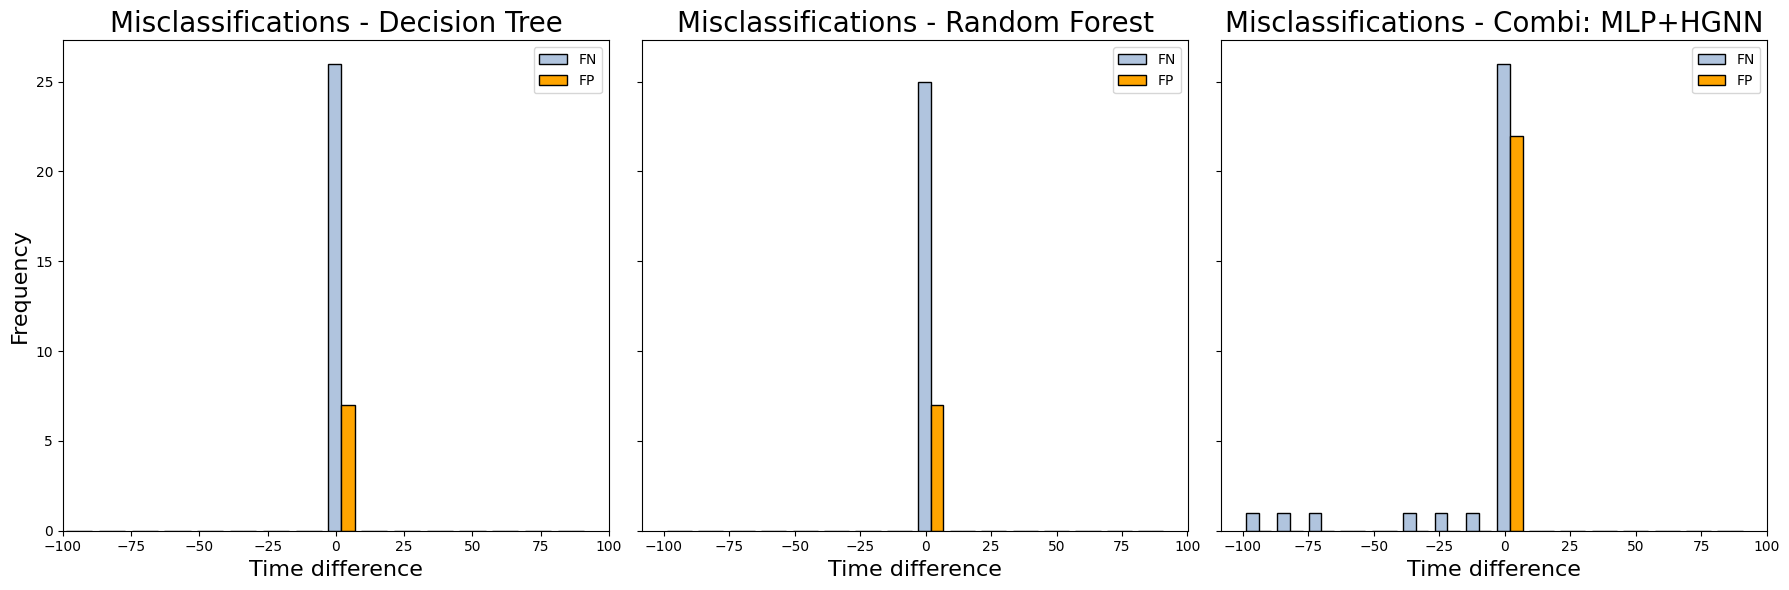

In [64]:
import matplotlib.pyplot as plt

diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']
diff_0_forest = misclass_forest[misclass_forest['pred label'] == 0]['diff rewr-orig']
diff_1_forest = misclass_forest[misclass_forest['pred label'] == 1]['diff rewr-orig']
diff_0_combi = misclass_combi[misclass_combi['pred label'] == 0]['diff rewr-orig']
diff_1_combi = misclass_combi[misclass_combi['pred label'] == 1]['diff rewr-orig']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

bins=list(range(-100, 101, 12))
axes[0].hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[0].set_xlabel('Time difference', fontsize = 16)
axes[0].set_ylabel('Frequency', fontsize = 16)
axes[0].set_title('Misclassifications - Decision Tree', fontsize = 20)
axes[0].legend(title='')
axes[0].set_xlim([-100,100])
axes[1].hist([diff_0_forest, diff_1_forest], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[1].set_xlabel('Time difference', fontsize = 16)
axes[1].set_title('Misclassifications - Random Forest', fontsize = 20)
axes[1].legend(title='')
axes[2].hist([diff_0_combi, diff_1_combi], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[2].set_xlabel('Time difference', fontsize = 16)
axes[2].set_title('Misclassifications - Combi: MLP+HGNN', fontsize = 20)
axes[2].legend(title='')

plt.tight_layout()
plt.savefig("results/res_spa_extrapos_mis", dpi=300)
plt.show()

## Final model on test set (with statistical tests)

We apply the final model (= the decision tree) on the untouched test set and observe the metrics and misclassifications on it (= how well it generalizes). Additionally, we compare the mean/median between the original runtimes on the test set and the decided runtimes on the test set (either the rewritten or the original one, based on the decision program).

In [65]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [66]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.9013605442176871
0.910958904109589
0.8926174496644296


array([[132,  13],
       [ 16, 133]])

We inspect the misclassifications of this final model.

In [67]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                      query  \
1412           0           1  STATS        115-144-augF2-augA3   
2536           0           1  HETIO         3-17-CuGdCtD-augA1   
1684           1           0  STATS        133-052-augF2-augA1   
512            1           0  STATS              042-006-augF2   
2692           1           0  HETIO        9-07-DuGcGpMF-augA2   
2335           0           1    JOB            20a-augF1-augA1   
354            1           0  STATS        028-062-augF1-augA5   
975            1           0  STATS        079-112-augF2-augA4   
382            0           1  STATS              031-025-augA3   
2613           0           1  HETIO        7-01-DaGiGpBP-augF1   
2632           0           1  HETIO       8-01-CCpGdCcSE-augA5   
1437           1           0  STATS        117-114-augF2-augA2   
2611           0           1  HETIO        7-01-DaGiGpBP-augA5   
353            1           0  STATS        028-062-augF1-augA4   
440            1           0  STATS              036-100-augF1   
2145           1           0    JOB                   2b-augF2   
1348           0           1  STATS                    111-056   
1055           0           1  STATS        086-083-augF2-augA1   
488            0           1  STATS        040-101-augF2-augA2   
248            0           1  STATS        019-130-augF1-augA3   
1115           0           1  STATS              091-035-augF1   
1686           1           0  STATS        133-052-augF2-augA3   
554            0           1  STATS              045-046-augA4   
956            0           1  STATS        078-082-augF1-augA1   
579            0           1  STATS        046-128-augF2-augA4   
2132           1           0    JOB             2a-augF2-augA2   
2621           1           0  HETIO  7-01-DaGiGpBP-augF2-augA1   
736            0           1  STATS        060-042-augF1-augA2   
1687           1           0  STATS        133-052-augF2-augA4   

     orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  rewr mean  \
1412            rewr                 orig   0.668111   0.666179   
2536            rewr                 orig   0.623178   0.598952   
1684            orig                 orig   0.509872   0.557117   
512             orig                 orig   0.163077   0.178428   
2692            orig                 orig   1.923481   2.035968   
2335            rewr                 orig  14.335614  13.860463   
354             orig                 orig   0.466282   0.476302   
975             orig                 orig   0.585297   0.617747   
382             rewr                 orig   0.451071   0.385170   
2613            rewr                 orig   2.401645   2.174763   
2632            rewr                 orig   2.173825   2.086451   
1437            orig                 orig   0.366607   0.386868   
2611            rewr                 orig   2.083080   2.034319   
353             orig                 orig   0.454534   0.584163   
440             orig                 orig   0.501897   0.590860   
2145            orig                 orig   6.441141   6.444036   
1348            rewr                 orig   0.585661   0.521762   
1055            rewr                 orig   0.525639   0.403110   
488             rewr                 orig   0.521375   0.447288   
248             rewr                 orig   0.525307   0.450182   
1115            rewr                 orig   0.290568   0.275750   
1686            orig                 orig   0.470533   0.542690   
554             rewr                 orig   0.580235   0.512736   
956             rewr                 orig   0.532655   0.419929   
579             rewr                 orig   0.584494   0.524198   
2132            orig                 orig   6.688609   7.077094   
2621            orig                 orig   2.130950   2.200876   
736             rewr                 orig   0.556196   0.551689   
1687            orig                 orig   0.480860   0.540853   

      rewr mea

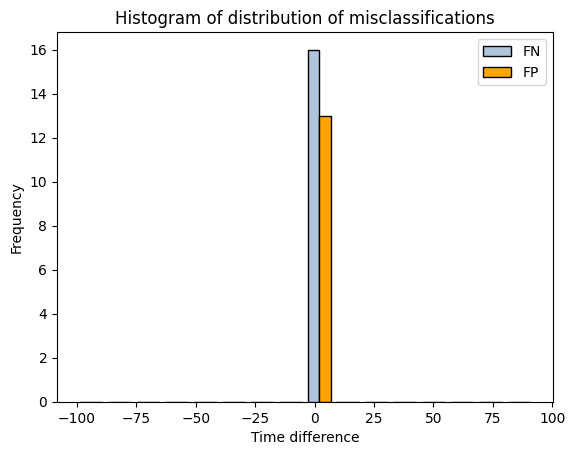

In [68]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference')
plt.ylabel('Frequency')
plt.title('Histogram of distribution of misclassifications')
plt.legend(title='')

# Show the plot
plt.show()

In [69]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_3978448/2236301608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3978448/2236301608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3978448/2236301608.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

cut  0.01  0.1  1  10  100  TO
FP      1    9  3   0    0   0
FN      2   10  4   0    0   0

We perform the statistical tests here.

In [70]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [71]:
test_set['pred mean'] = np.where(test_set['pred label'] == 0, test_set['orig mean'], test_set['rewr mean'])
test_set.head()

pred label  true label  bench                query orig/rewr(mean)  \
574            0           0  STATS  046-128-augF1-augA4            orig   
2086           1           1   SNAP    wiki-path07-augA2            rewr   
1621           1           1  STATS        129-140-augF2            rewr   
1653           0           0  STATS  131-143-augF1-augA6            orig   
2668           1           1  HETIO  9-03-DaGrGpMF-augA6            rewr   

     orig/rewr+rewr(mean)   orig mean  rewr mean  rewr mean+rewr  \
574                  orig    0.591848   0.604455        2.668834   
2086                 rewr  100.000000  83.424965       85.298854   
1621                 orig    0.911721   0.755924        1.982493   
1653                 orig    0.514398   0.614337        1.721684   
2668                 rewr    6.209357   1.834116        3.915546   

      diff rewr-orig  ...  max(join rows)  mean(join rows)  q25(join rows)  \
574         0.012607  ...    1.633900e+04     5.910250e+03    1.388500e+03   
2086      -16.575035  ...    5.236163e+22     7.480232e+21    4.896690e+09   
1621       -0.155797  ...    3.015610e+05     5.080600e+04    1.922500e+02   
1653        0.099939  ...    5.959000e+03     1.033000e+03    7.250000e+00   
2668       -4.375241  ...    2.911490e+05     9.114783e+04    4.684500e+03   

      median(join rows)  q75(join rows)  orig/rewr/equal 0.5  \
574        3.007000e+03    7.528750e+03                equal   
2086       4.896690e+09    1.023091e+14                 rewr   
1621       4.065000e+02    1.721000e+03                equal   
1653       2.850000e+01    1.397500e+02                equal   
2668       6.790100e+04    1.189420e+05                 rewr   

      orig/rewr/equal 0.1  orig/rewr/equal 0.05  orig/rewr/equal 0.01  \
574                 equal                 equal                  orig   
2086                 rewr                  rewr                  rewr   
1621                 rewr                  rewr                  rewr   
1653                equal                  orig                  orig   
2668                 rewr                  rewr                  rewr   

      pred mean  
574    0.591848  
2086  83.424965  
1621   0.755924  
1653   0.514398  
2668   1.834116  

[5 rows x 51 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [72]:
w_stat, p_val = stats.wilcoxon(test_set["orig mean"], test_set["pred mean"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 171.0
P-value: 3.3822296981526126e-24


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [73]:
t_stat, p_val = stats.ttest_rel(test_set["orig mean"], test_set["pred mean"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 7.239365265541206
P-value: 3.98163883331369e-12


Finally, we inspect the decision tree as graphic and provide the feature importances (based on the Gini importance) for all features.

In [74]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

#relations  #conditions  #filters  #joins     depth  \
Importance         0.0     0.004042  0.157783     0.0  0.006276   

            min(container counts)  max(container counts)  \
Importance                    0.0               0.024547   

            mean(container counts)  q25(container counts)  \
Importance                0.053083                    0.0   

            median(container counts)  ...  mean(table rows)  q25(table rows)  \
Importance                       0.0  ...           0.03468         0.035148   

            median(table rows)  q75(table rows)  min(join rows)  \
Importance            0.006461            0.053        0.028861   

            max(join rows)  mean(join rows)  q25(join rows)  \
Importance        0.287186          0.04082        0.043857   

            median(join rows)  q75(join rows)  
Importance           0.026628        0.033572  

[1 rows x 30 columns]

In [75]:
df_importances

Importance
#relations                   0.000000
#conditions                  0.004042
#filters                     0.157783
#joins                       0.000000
depth                        0.006276
min(container counts)        0.000000
max(container counts)        0.024547
mean(container counts)       0.053083
q25(container counts)        0.000000
median(container counts)     0.000000
q75(container counts)        0.000000
min(branching factors)       0.003574
max(branching factors)       0.002858
mean(branching factors)      0.001613
median(branching factors)    0.005366
q25(branching factors)       0.010581
q75(branching factors)       0.008580
total cost                   0.089817
min(table rows)              0.002870
max(table rows)              0.038798
mean(table rows)             0.034680
q25(table rows)              0.035148
median(table rows)           0.006461
q75(table rows)              0.053000
min(join rows)               0.028861
max(join rows)               0.287186
mean(join rows)              0.040820
q25(join rows)               0.043857
median(join rows)            0.026628
q75(join rows)               0.033572

In [76]:
clf.tree_.max_depth

17

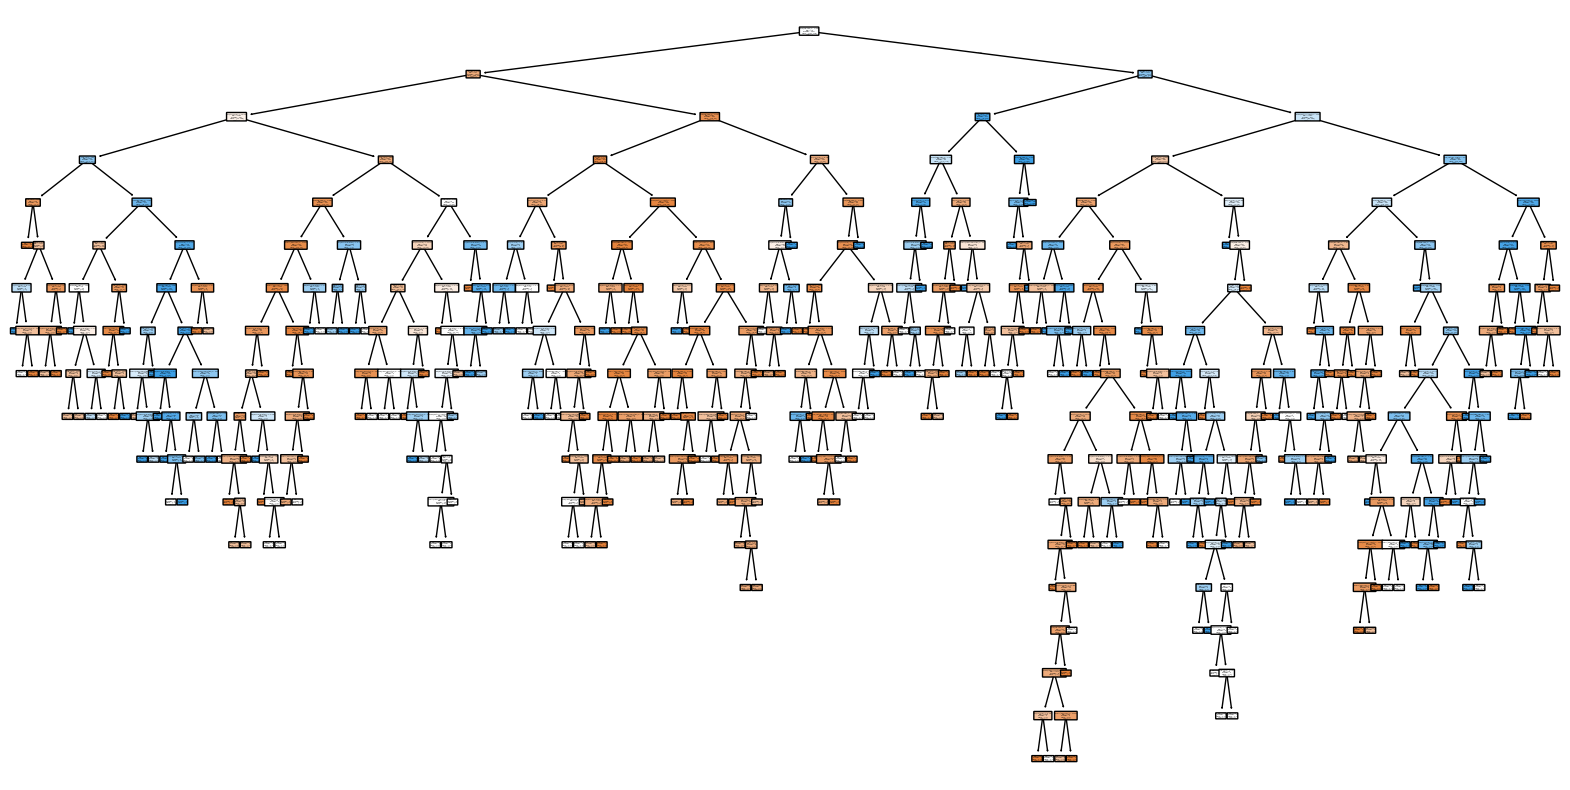

In [77]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.show()